# Feature Exploration (all instances): us-east-1e, LINUX/UNIX

**Author: Sumaia Parveen Shupti**

Updated on: 05/03/2021

* **39 instance price changed during these 2 months, 26 of them didn't change**

* First set of plots show the average price for each instance with respect to a specific feature like Hour, Month, Weekday etc

* Second set of plots first show the summary of the first set of plots i.e., first we show the distribution of price considering all instances with respect to several features (Hour, Month etc)

* Then we plotted the difference of average price of each instance with respect to that feature so we can look closely but briefly at the change in price (sometimes its around $5 and sometimes its less than 1 cent) and decision whether we want this feature to include in our model or not

### Feature Description

* **Month**: Month extracted from the date of the spot-price data.

* **Day**: Day extracted from the date of the spot-price data.

* **Day_name**: Which day of the week? -- Saturday, Sunday, Monday etc

* **Hour**: Which hour of the day? -- 9 am, 12 pm etc

* **Day_parts**: Afternoon, morning etc. 

* **Weekend_(y/n)**: Weekend or not? 

* **DayofYear**: Which day of the year? 1, 2... 365.

* **Holiday_(y/n)**: Is it a public holiday in US-east? 

* **Timedel**: Integer representation of Timestamp.



In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import datetime as dt
from datetime import datetime, timedelta
from datetime import date
import holidays

import matplotlib.pyplot as plt
import seaborn as sns

import itertools
plt.style.use('seaborn-dark')
import statsmodels.api as sm
import matplotlib
matplotlib.rcParams['axes.labelsize'] = 12
matplotlib.rcParams['xtick.labelsize'] = 11
matplotlib.rcParams['ytick.labelsize'] = 11
matplotlib.rcParams['text.color'] = 'k'
plt.rcParams["figure.figsize"] = [8, 6]
plt.rcParams['lines.linewidth'] = 2
import matplotlib.dates as mdates

import warnings
warnings.filterwarnings('ignore')

### Data Preprocessing (Not Sampled, Raw dataset collected through AWS CLI)

In [2]:
df = pd.read_csv('../input/aws-spot-price-15th-feb16th-april-2021/us-east-1_Feb15-Apr16.csv')
df['Timestamp'] = pd.to_datetime(df['Timestamp'], format = '%Y-%m-%d %H:%M:%S.%f', utc=True)
df = df.sort_values(by="Timestamp")

# Filtering the dataset for OS-type = 'Linux/UNIX' only
df = df[(df.ProductDescription == 'Linux/UNIX')].sort_values(by="Timestamp") 
df.drop('ProductDescription', axis=1, inplace=True)  

df = df.set_index(['AvailabilityZone', 'InstanceType', 'Timestamp'])
print(df.shape)
df.head()

(226586, 1)


SpotPrice
AvailabilityZone InstanceType Timestamp                           
us-east-1c       c5d.metal    2021-02-15 05:39:29+00:00     1.5546
us-east-1d       c5d.metal    2021-02-15 05:39:29+00:00     1.5546
us-east-1a       c5d.metal    2021-02-15 05:39:29+00:00     1.5546
                 d2.4xlarge   2021-02-15 05:44:53+00:00     0.8280
us-east-1f       d2.4xlarge   2021-02-15 05:44:53+00:00     0.8280

In [3]:
us_east_1e = df.reset_index()
us_east_1e = us_east_1e[(us_east_1e.AvailabilityZone == 'us-east-1e')]

instances = us_east_1e.InstanceType.unique().tolist()

### Feature Engineering 

In [4]:
us_east_1e['Date'] = us_east_1e['Timestamp'].dt.date
us_east_1e['Date'] = pd.to_datetime(us_east_1e['Date'])

us_east_1e['Year'] = us_east_1e['Timestamp'].dt.year
us_east_1e['Month'] = us_east_1e['Timestamp'].dt.month
us_east_1e['Day'] = us_east_1e['Timestamp'].dt.day
us_east_1e['Day_name'] = us_east_1e['Timestamp'].dt.day_name()
us_east_1e['Hour'] = us_east_1e['Timestamp'].dt.hour

# daypart function
def daypart(hour):
    if hour in [2,3,4,5]:
        return "Dawn"
    elif hour in [6,7,8,9]:
        return "Morning"
    elif hour in [10,11,12,13]:
        return "Noon"
    elif hour in [14,15,16,17]:
        return "Afternoon"
    elif hour in [18,19,20,21]:
        return "Evening"
    else: return "Midnight"
    
us_east_1e['Day_parts'] = raw_dayparts = us_east_1e.Timestamp.dt.hour.apply(daypart)


us_east_1e['Weekday'] = us_east_1e['Timestamp'].dt.weekday
us_east_1e['Weekend_(y/n)'] = ((us_east_1e['Timestamp'].dt.dayofweek) // 5 == 1).astype(float)
us_east_1e['DayofYear'] = us_east_1e['Timestamp'].dt.dayofyear


us_holidays = holidays.UnitedStates() 
hd = []

# Print all the holidays in UnitedKingdom in year 2018
for ptr in holidays.US(years = 2021).items():
    print(ptr)
    hd.append(ptr[0])

def extractServiceName(x):
    if x in hd:
        return 1
    else:
        return 0

us_east_1e['Holiday_(y/n)'] = us_east_1e['Date'].apply(lambda x : extractServiceName(x))

# Convert the date into a number (of days since some point)
fromDate = min(us_east_1e['Timestamp'])
us_east_1e['Timedel'] = (us_east_1e['Timestamp'] - fromDate).astype(np.int64)/100000000000

us_east_1e.drop('Timestamp', axis = 1, inplace = True)

us_east_1e = us_east_1e.reset_index(drop = True)

print (us_east_1e.shape)
us_east_1e.head()

(datetime.date(2021, 1, 1), "New Year's Day")
(datetime.date(2021, 12, 31), "New Year's Day (Observed)")
(datetime.date(2021, 1, 18), 'Martin Luther King Jr. Day')
(datetime.date(2021, 2, 15), "Washington's Birthday")
(datetime.date(2021, 5, 31), 'Memorial Day')
(datetime.date(2021, 7, 4), 'Independence Day')
(datetime.date(2021, 7, 5), 'Independence Day (Observed)')
(datetime.date(2021, 9, 6), 'Labor Day')
(datetime.date(2021, 10, 11), 'Columbus Day')
(datetime.date(2021, 11, 11), 'Veterans Day')
(datetime.date(2021, 11, 25), 'Thanksgiving')
(datetime.date(2021, 12, 25), 'Christmas Day')
(datetime.date(2021, 12, 24), 'Christmas Day (Observed)')
(8388, 15)


AvailabilityZone InstanceType  SpotPrice       Date  Year  Month  Day  \
0       us-east-1e   d2.4xlarge     0.8280 2021-02-15  2021      2   15   
1       us-east-1e   i2.4xlarge     1.0230 2021-02-15  2021      2   15   
2       us-east-1e   g3.4xlarge     0.3420 2021-02-15  2021      2   15   
3       us-east-1e  f1.16xlarge     3.9600 2021-02-15  2021      2   15   
4       us-east-1e    t2.xlarge     0.0607 2021-02-15  2021      2   15   

  Day_name  Hour Day_parts  Weekday  Weekend_(y/n)  DayofYear  Holiday_(y/n)  \
0   Monday     5      Dawn        0            0.0         46              1   
1   Monday     8   Morning        0            0.0         46              1   
2   Monday     8   Morning        0            0.0         46              1   
3   Monday     8   Morning        0            0.0         46              1   
4   Monday     9   Morning        0            0.0         46              1   

   Timedel  
0     0.00  
1   104.74  
2   104.88  
3   108.91  
4   117.22

In [5]:
change = []
no_change = []
amount_change = []

for ins in instances:
    
    df = us_east_1e[(us_east_1e.InstanceType == ins)]
    
    if (df.SpotPrice.max() - df.SpotPrice.min()) == 0:
        no_change.append(ins)
    else:
        change.append(ins)
        amount_change.append(abs(df.SpotPrice.max() - df.SpotPrice.min()))
        
print (len (change))
print (len (no_change))

39
26


Instance: t2.xlarge
Hour: Max avg price - min avg price = 0.00187
Day_parts: Max avg price - min avg price = 0.00103
Day_name: Max avg price - min avg price = 0.00028
Day: Max avg price - min avg price = 0.00094


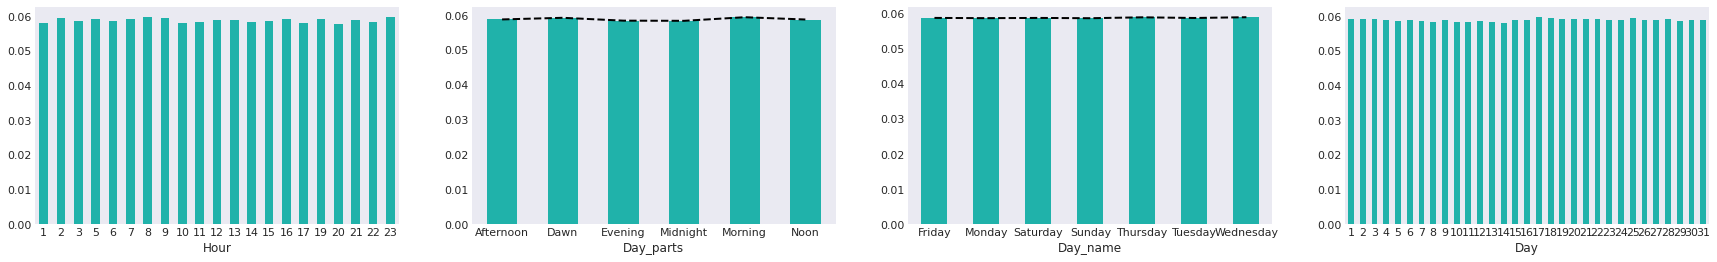

Instance: i2.xlarge
Hour: Max avg price - min avg price = 0.0209
Day_parts: Max avg price - min avg price = 0.00557
Day_name: Max avg price - min avg price = 0.00226
Day: Max avg price - min avg price = 0.01419


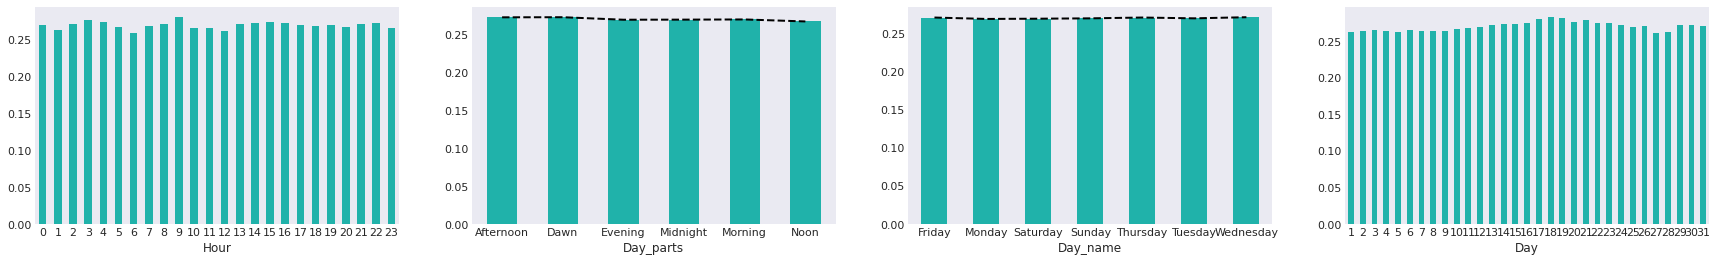

Instance: i2.8xlarge
Hour: Max avg price - min avg price = 0.5242
Day_parts: Max avg price - min avg price = 0.27655
Day_name: Max avg price - min avg price = 0.10186
Day: Max avg price - min avg price = 0.39651


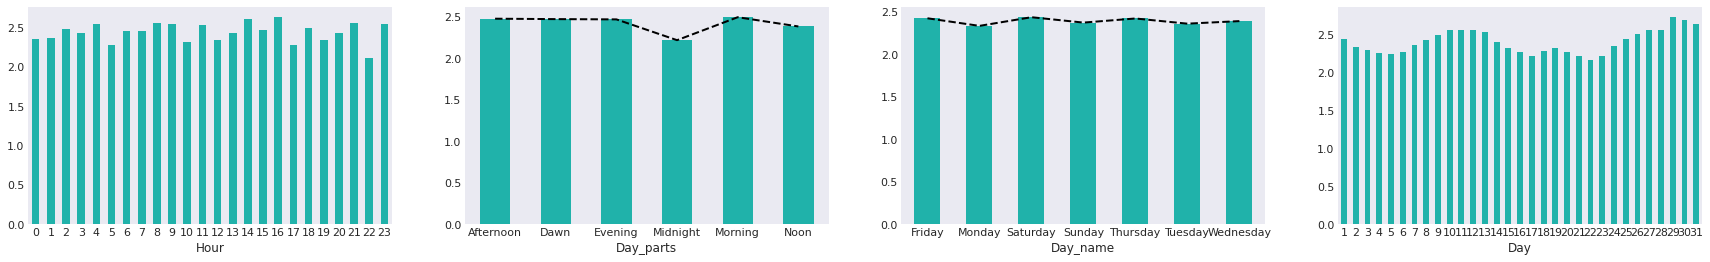

Instance: c4.xlarge
Hour: Max avg price - min avg price = 0.00373
Day_parts: Max avg price - min avg price = 0.0016
Day_name: Max avg price - min avg price = 0.00089
Day: Max avg price - min avg price = 0.00304


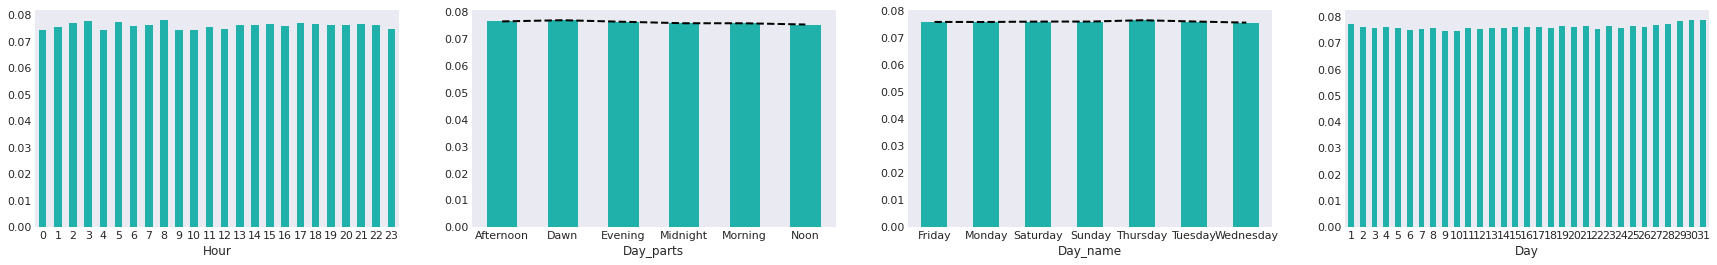

Instance: c4.large
Hour: Max avg price - min avg price = 0.00442
Day_parts: Max avg price - min avg price = 0.00066
Day_name: Max avg price - min avg price = 0.00102
Day: Max avg price - min avg price = 0.00713


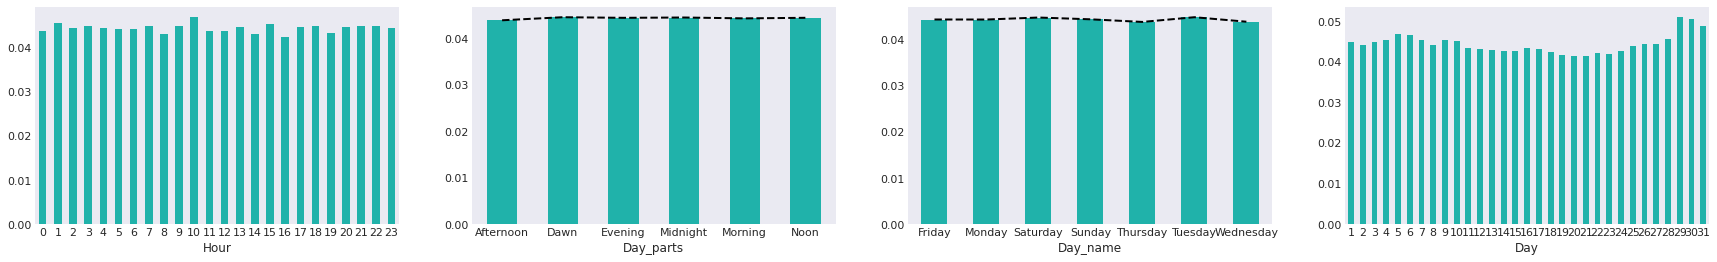

Instance: c4.8xlarge
Hour: Max avg price - min avg price = 0.0475
Day_parts: Max avg price - min avg price = 0.01725
Day_name: Max avg price - min avg price = 0.00996
Day: Max avg price - min avg price = 0.03378


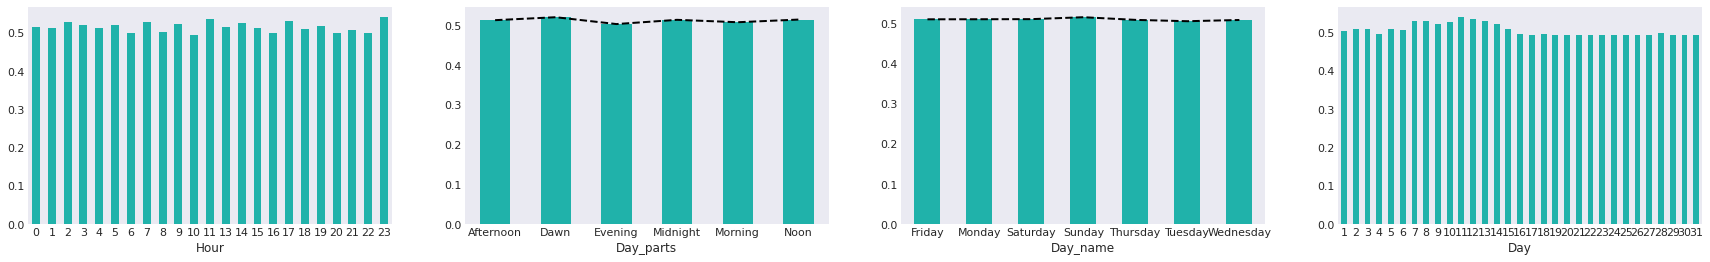

Instance: t2.small
Hour: Max avg price - min avg price = 0.0001
Day_parts: Max avg price - min avg price = 0.0001
Day_name: Max avg price - min avg price = 3e-05
Day: Max avg price - min avg price = 6e-05


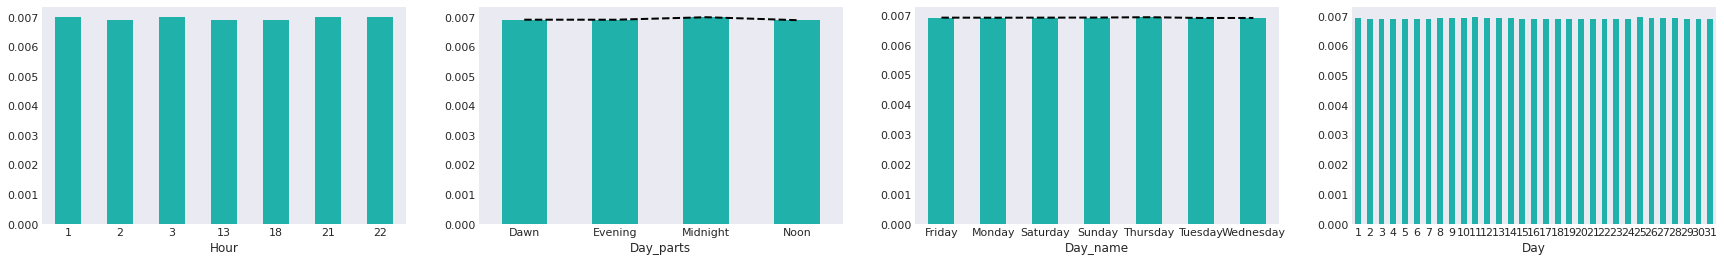

Instance: c3.4xlarge
Hour: Max avg price - min avg price = 0.01839
Day_parts: Max avg price - min avg price = 0.00511
Day_name: Max avg price - min avg price = 0.00883
Day: Max avg price - min avg price = 0.01575


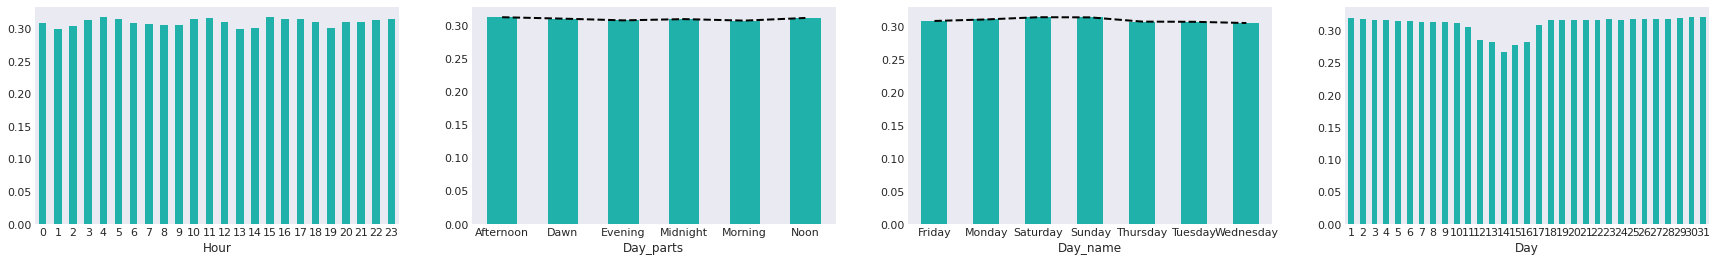

Instance: m3.xlarge
Hour: Max avg price - min avg price = 0.0017
Day_parts: Max avg price - min avg price = 0.00088
Day_name: Max avg price - min avg price = 0.00011
Day: Max avg price - min avg price = 0.00044


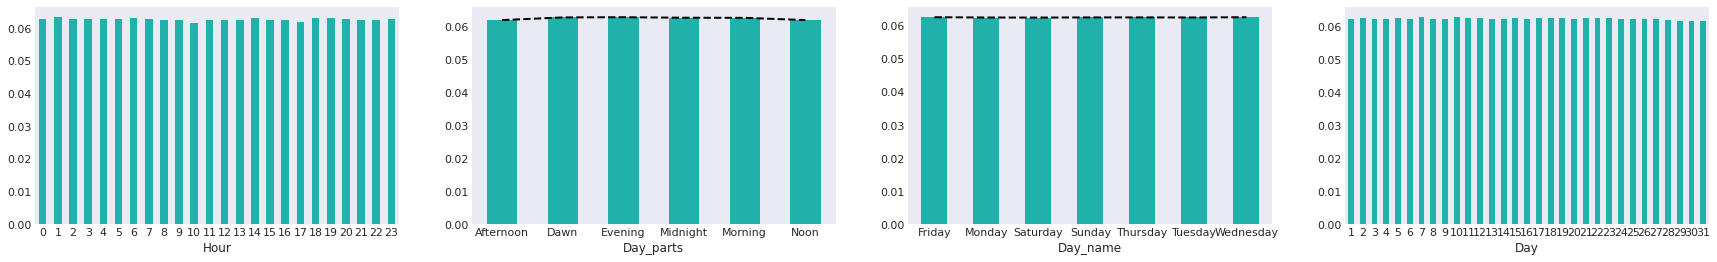

Instance: t2.large
Hour: Max avg price - min avg price = 0.00208
Day_parts: Max avg price - min avg price = 0.00043
Day_name: Max avg price - min avg price = 0.00042
Day: Max avg price - min avg price = 0.00178


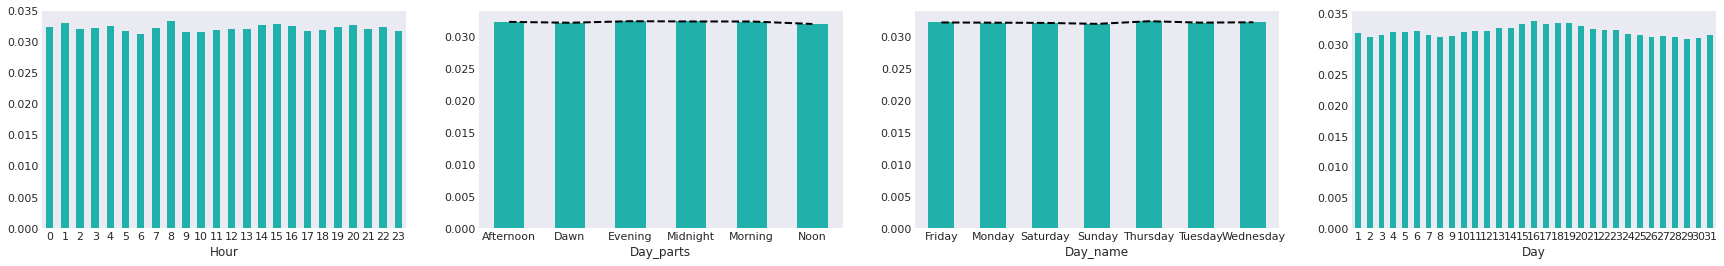

Instance: r4.large
Hour: Max avg price - min avg price = 0.01663
Day_parts: Max avg price - min avg price = 0.00318
Day_name: Max avg price - min avg price = 0.00432
Day: Max avg price - min avg price = 0.0123


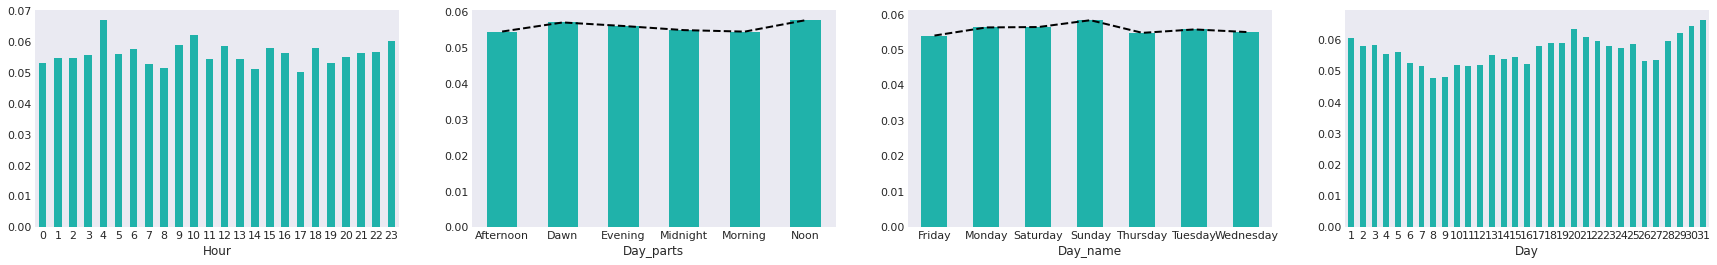

Instance: i3.2xlarge
Hour: Max avg price - min avg price = 0.00631
Day_parts: Max avg price - min avg price = 0.00122
Day_name: Max avg price - min avg price = 0.00168
Day: Max avg price - min avg price = 0.00594


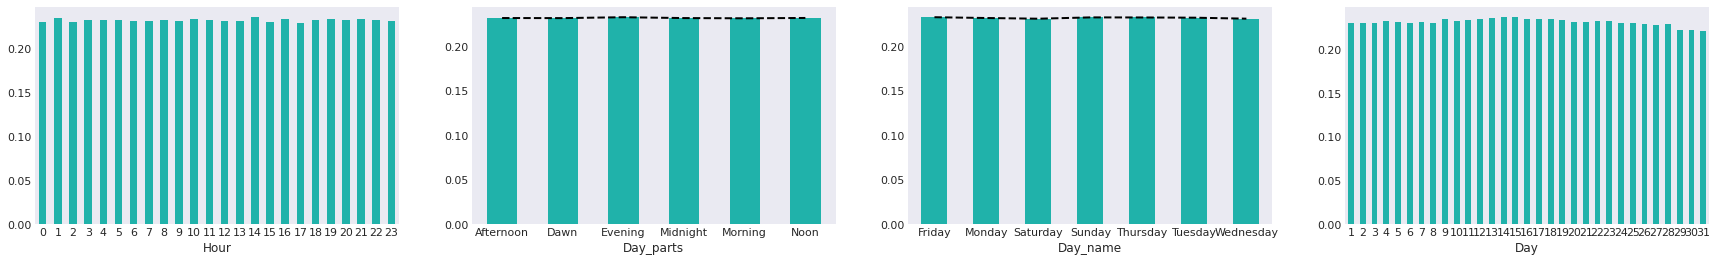

Instance: r4.16xlarge
Hour: Max avg price - min avg price = 0.06243
Day_parts: Max avg price - min avg price = 0.00976
Day_name: Max avg price - min avg price = 0.01716
Day: Max avg price - min avg price = 0.05223


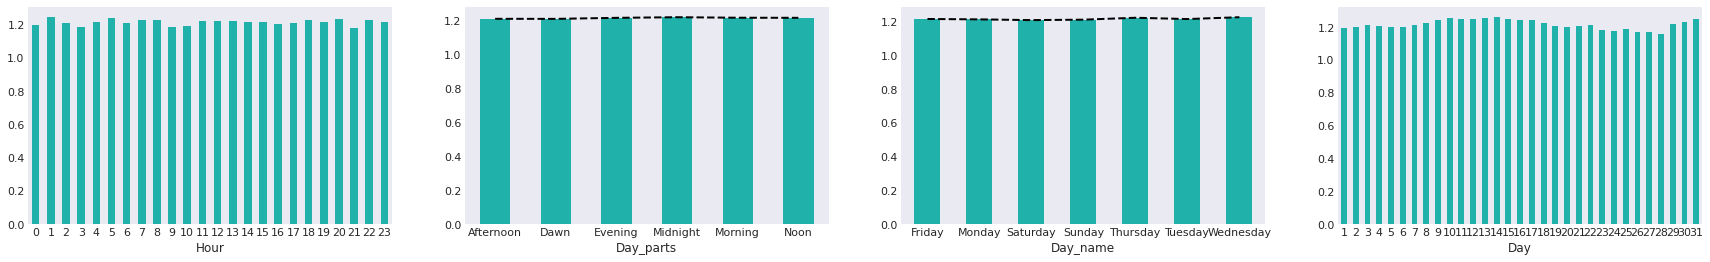

Instance: i3.large
Hour: Max avg price - min avg price = 0.00649
Day_parts: Max avg price - min avg price = 0.00345
Day_name: Max avg price - min avg price = 0.00087
Day: Max avg price - min avg price = 0.00385


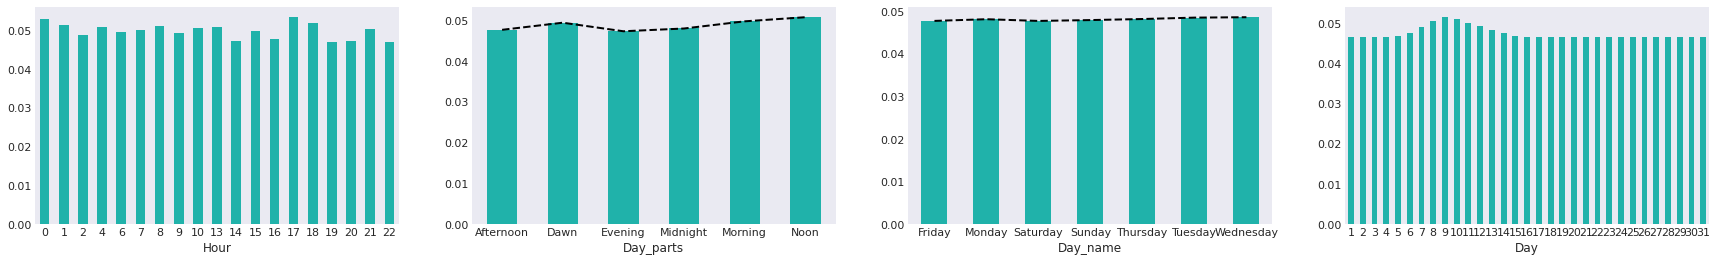

Instance: c3.xlarge
Hour: Max avg price - min avg price = 0.00082
Day_parts: Max avg price - min avg price = 0.0004
Day_name: Max avg price - min avg price = 0.00017
Day: Max avg price - min avg price = 0.00055


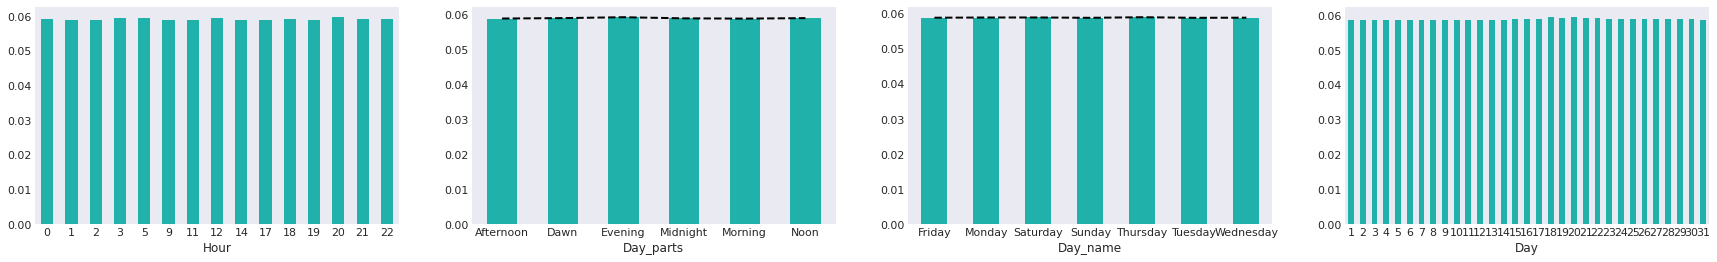

Instance: i3.xlarge
Hour: Max avg price - min avg price = 0.00404
Day_parts: Max avg price - min avg price = 0.00146
Day_name: Max avg price - min avg price = 0.00081
Day: Max avg price - min avg price = 0.00211


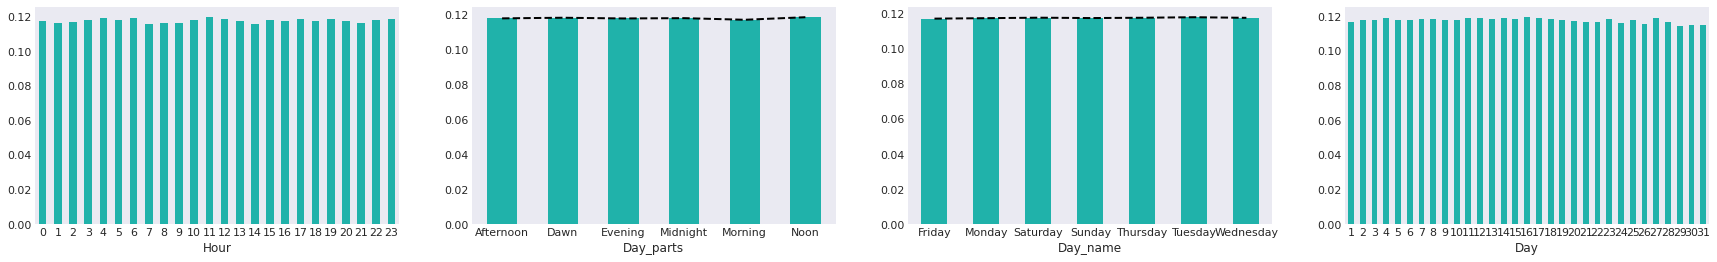

Instance: c3.large
Hour: Max avg price - min avg price = 0.00055
Day_parts: Max avg price - min avg price = 0.00022
Day_name: Max avg price - min avg price = 0.0001
Day: Max avg price - min avg price = 0.00028


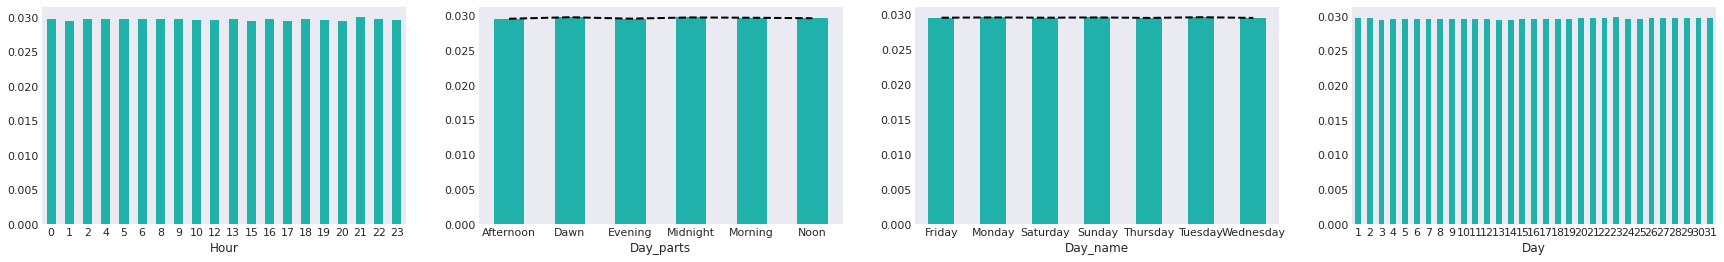

Instance: r3.4xlarge
Hour: Max avg price - min avg price = 0.00871
Day_parts: Max avg price - min avg price = 0.00241
Day_name: Max avg price - min avg price = 0.00478
Day: Max avg price - min avg price = 0.01438


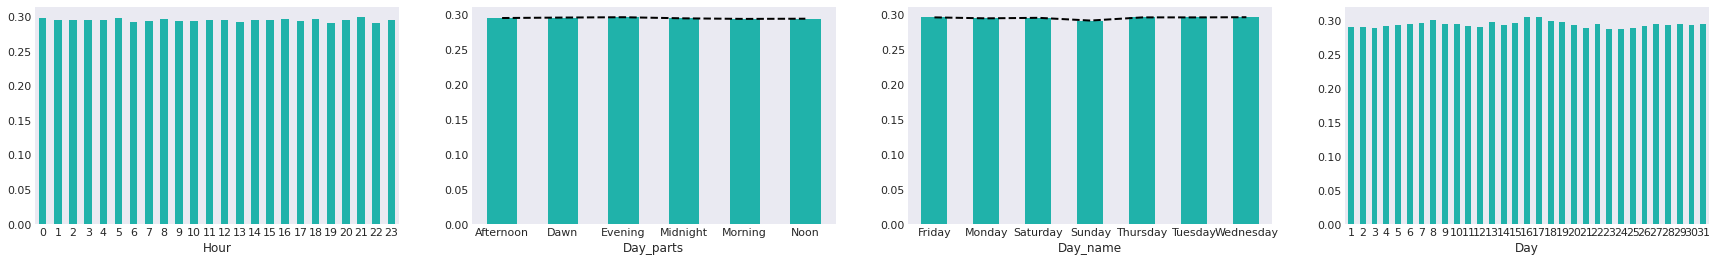

Instance: g2.8xlarge
Hour: Max avg price - min avg price = 0.07011
Day_parts: Max avg price - min avg price = 0.0314
Day_name: Max avg price - min avg price = 0.01311
Day: Max avg price - min avg price = 0.04213


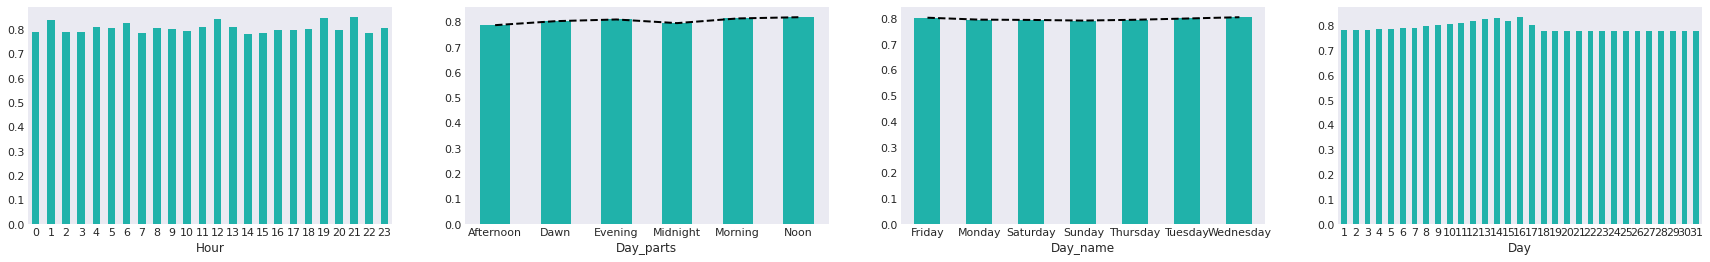

Instance: r3.large
Hour: Max avg price - min avg price = 0.00651
Day_parts: Max avg price - min avg price = 0.00213
Day_name: Max avg price - min avg price = 0.00189
Day: Max avg price - min avg price = 0.00401


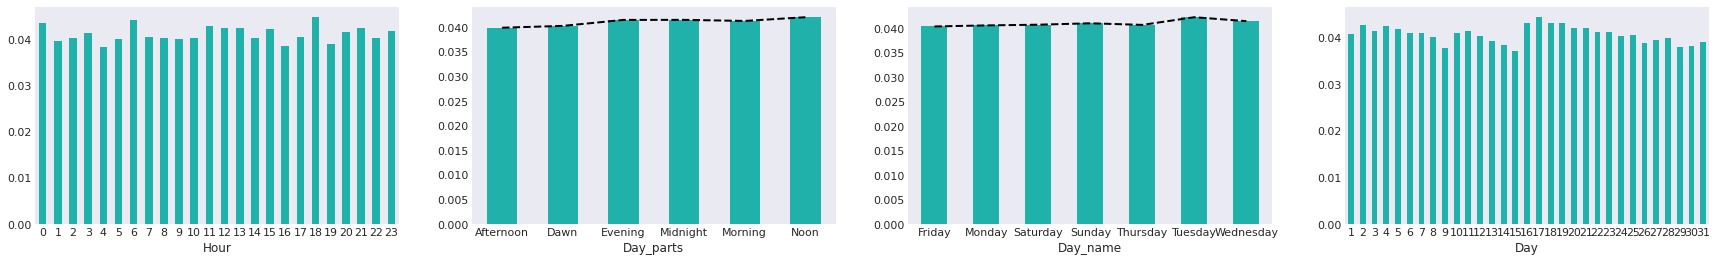

Instance: m4.10xlarge
Hour: Max avg price - min avg price = 0.04832
Day_parts: Max avg price - min avg price = 0.01445
Day_name: Max avg price - min avg price = 0.01007
Day: Max avg price - min avg price = 0.02182


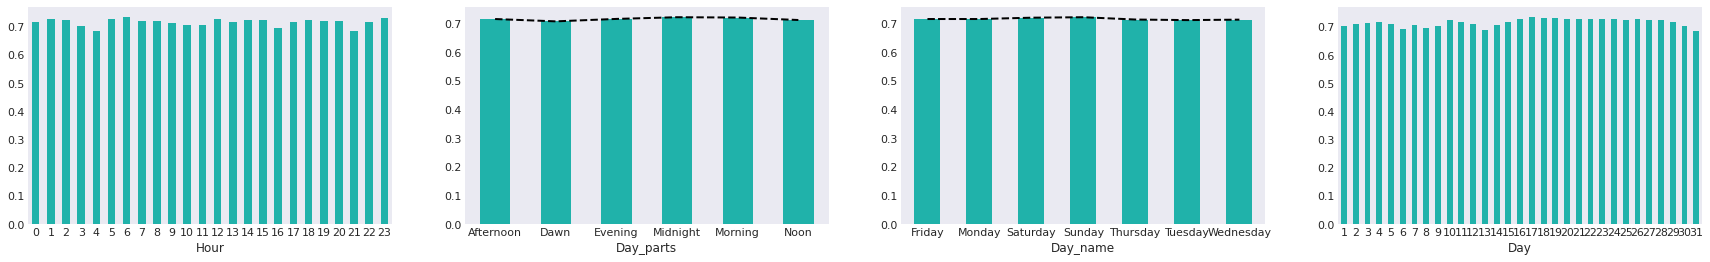

Instance: c3.2xlarge
Hour: Max avg price - min avg price = 0.00299
Day_parts: Max avg price - min avg price = 0.00054
Day_name: Max avg price - min avg price = 0.0008
Day: Max avg price - min avg price = 0.00333


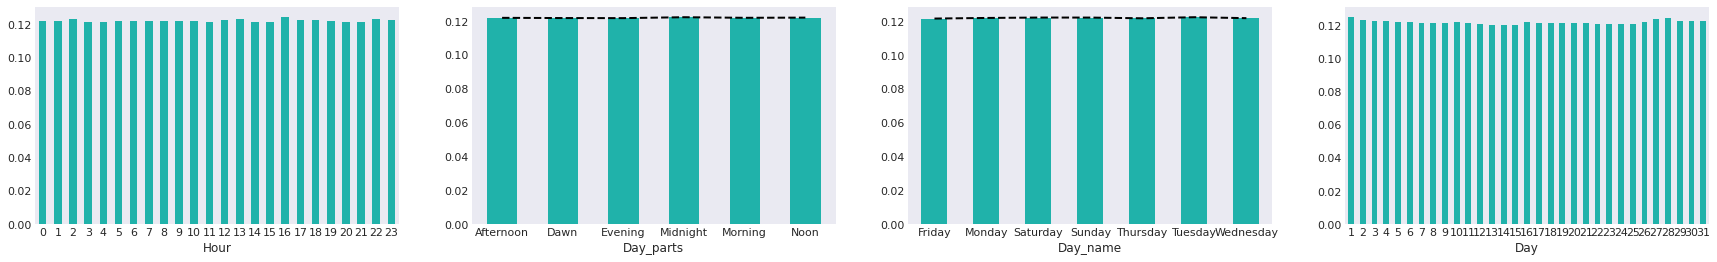

Instance: r4.8xlarge
Hour: Max avg price - min avg price = 0.00893
Day_parts: Max avg price - min avg price = 0.00362
Day_name: Max avg price - min avg price = 0.00446
Day: Max avg price - min avg price = 0.01274


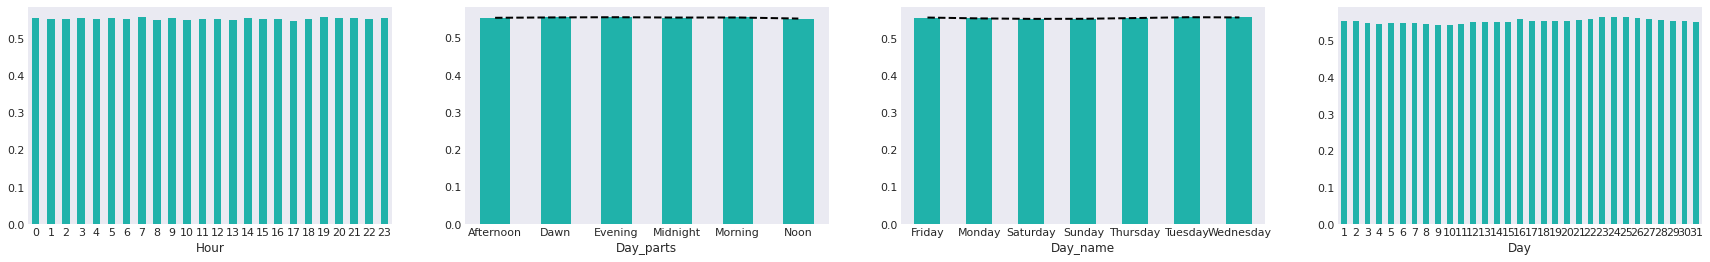

Instance: m4.4xlarge
Hour: Max avg price - min avg price = 0.0215
Day_parts: Max avg price - min avg price = 0.00245
Day_name: Max avg price - min avg price = 0.00532
Day: Max avg price - min avg price = 0.01149


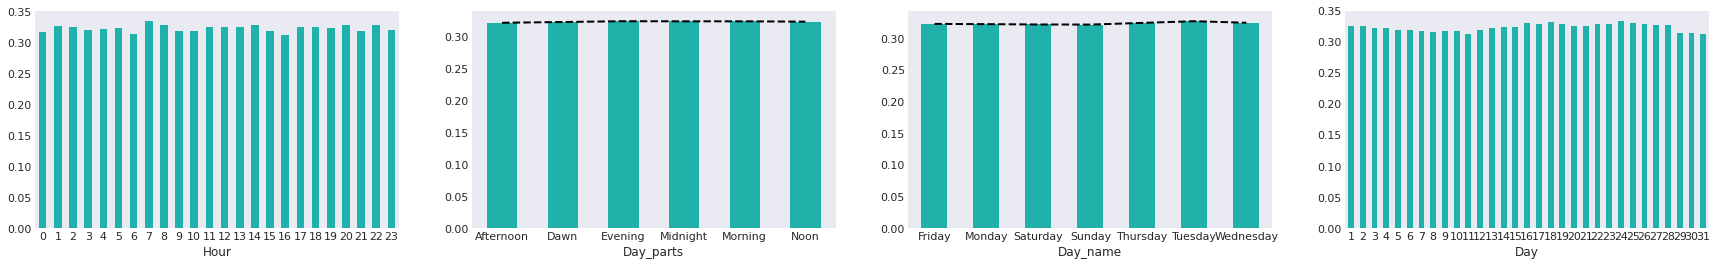

Instance: r4.xlarge
Hour: Max avg price - min avg price = 0.00948
Day_parts: Max avg price - min avg price = 0.00229
Day_name: Max avg price - min avg price = 0.00218
Day: Max avg price - min avg price = 0.00741


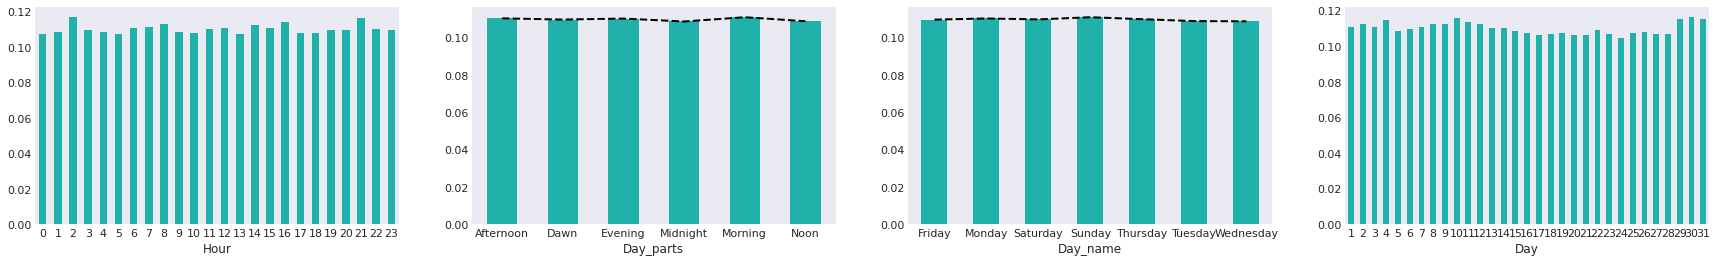

Instance: i3.4xlarge
Hour: Max avg price - min avg price = 0.01067
Day_parts: Max avg price - min avg price = 0.00243
Day_name: Max avg price - min avg price = 0.0022
Day: Max avg price - min avg price = 0.0082


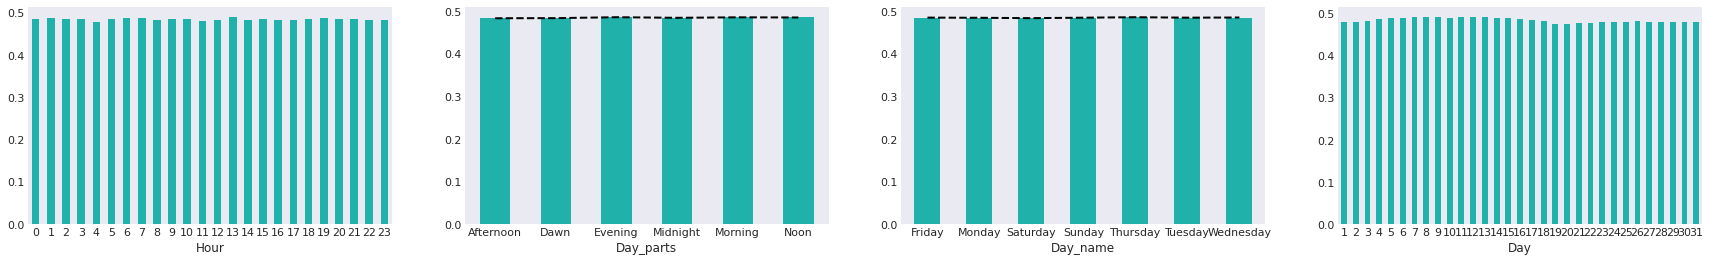

Instance: m4.16xlarge
Hour: Max avg price - min avg price = 0.06331
Day_parts: Max avg price - min avg price = 0.0088
Day_name: Max avg price - min avg price = 0.01933
Day: Max avg price - min avg price = 0.04373


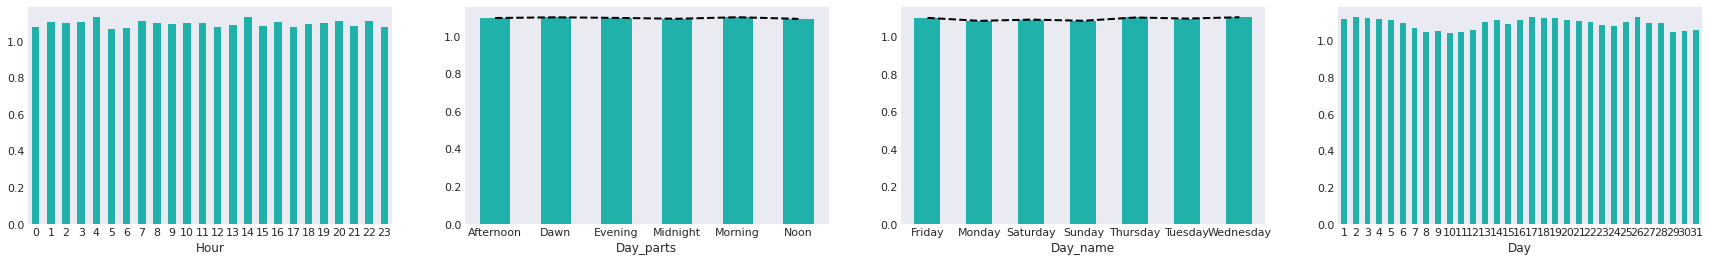

Instance: m4.2xlarge
Hour: Max avg price - min avg price = 0.00539
Day_parts: Max avg price - min avg price = 0.00082
Day_name: Max avg price - min avg price = 0.00146
Day: Max avg price - min avg price = 0.0036


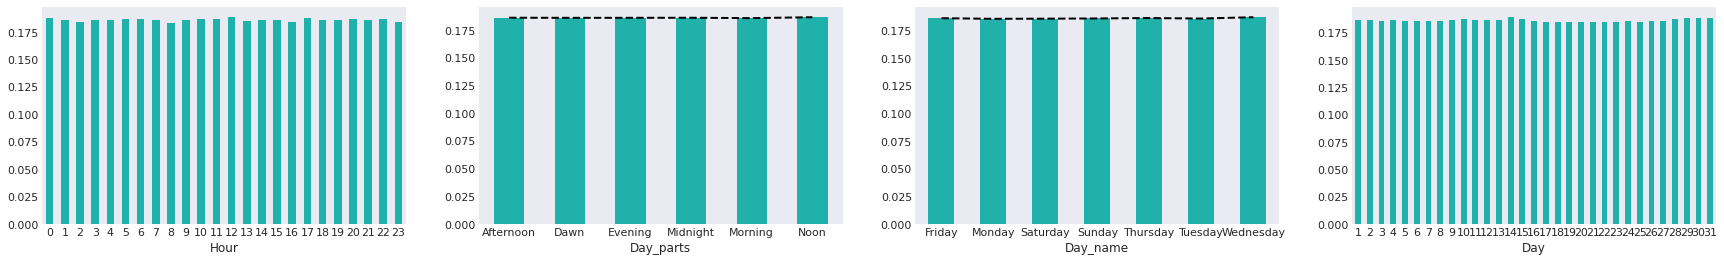

Instance: t2.medium
Hour: Max avg price - min avg price = 0.00318
Day_parts: Max avg price - min avg price = 0.00127
Day_name: Max avg price - min avg price = 0.00046
Day: Max avg price - min avg price = 0.00157


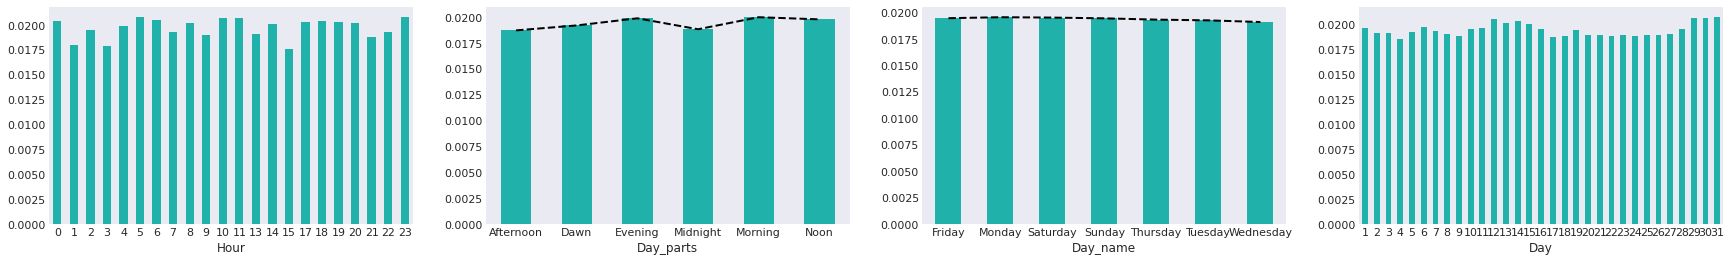

Instance: m3.2xlarge
Hour: Max avg price - min avg price = 0.0041
Day_parts: Max avg price - min avg price = 0.00156
Day_name: Max avg price - min avg price = 0.00096
Day: Max avg price - min avg price = 0.00372


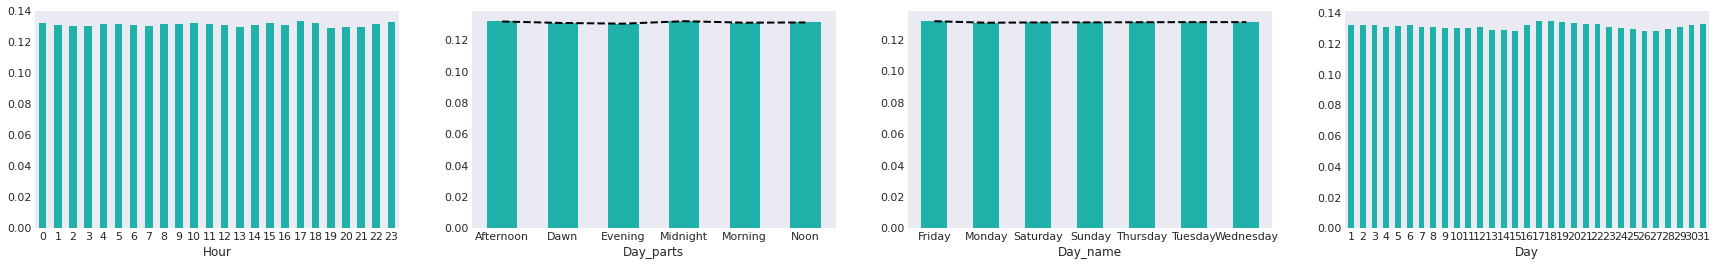

Instance: c4.2xlarge
Hour: Max avg price - min avg price = 0.00312
Day_parts: Max avg price - min avg price = 0.00124
Day_name: Max avg price - min avg price = 0.00095
Day: Max avg price - min avg price = 0.00596


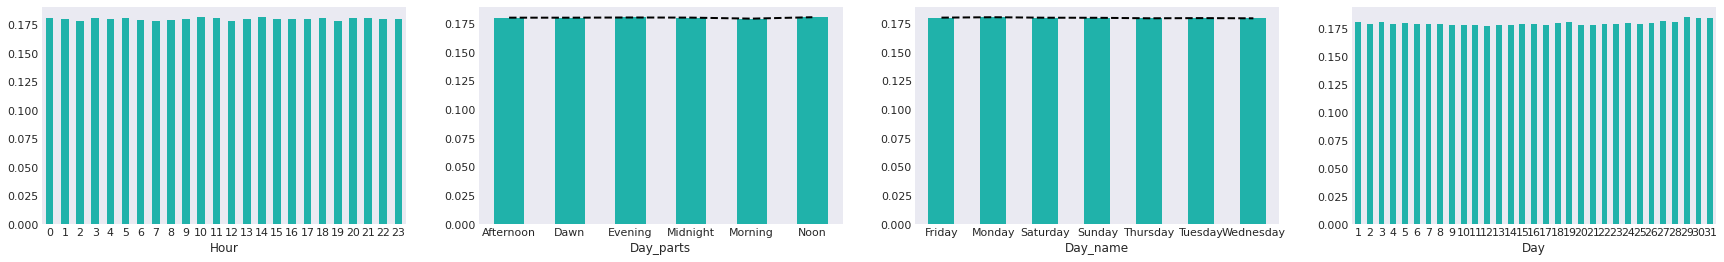

Instance: m4.xlarge
Hour: Max avg price - min avg price = 0.00575
Day_parts: Max avg price - min avg price = 0.00094
Day_name: Max avg price - min avg price = 0.00091
Day: Max avg price - min avg price = 0.0024


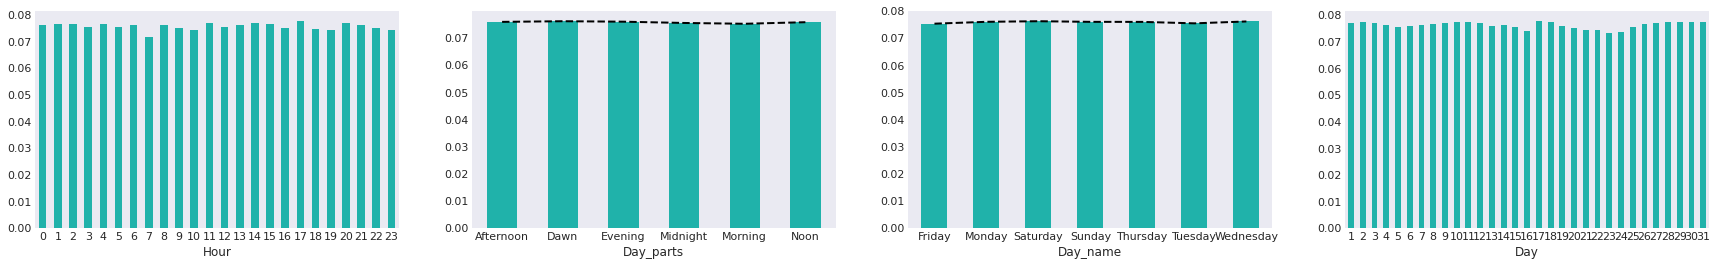

Instance: c3.8xlarge
Hour: Max avg price - min avg price = 0.05087
Day_parts: Max avg price - min avg price = 0.02416
Day_name: Max avg price - min avg price = 0.01603
Day: Max avg price - min avg price = 0.02849


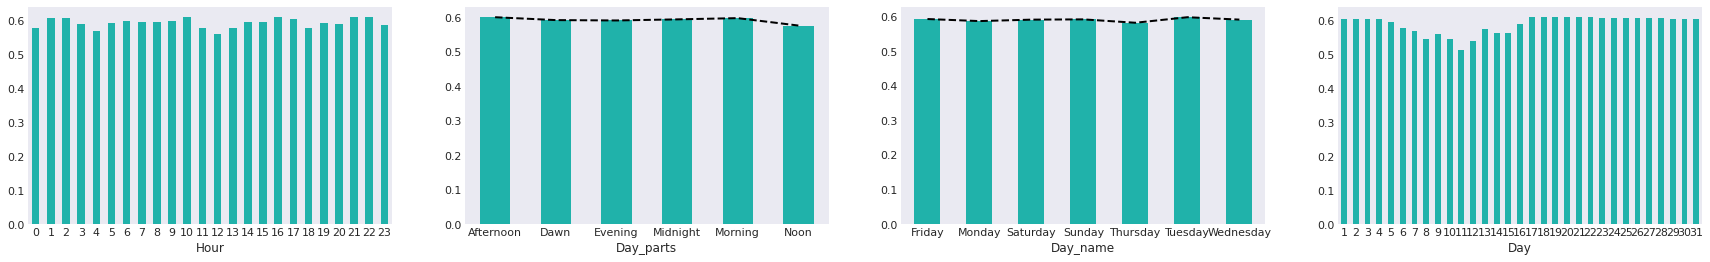

Instance: r4.2xlarge
Hour: Max avg price - min avg price = 0.01094
Day_parts: Max avg price - min avg price = 0.00181
Day_name: Max avg price - min avg price = 0.00114
Day: Max avg price - min avg price = 0.00643


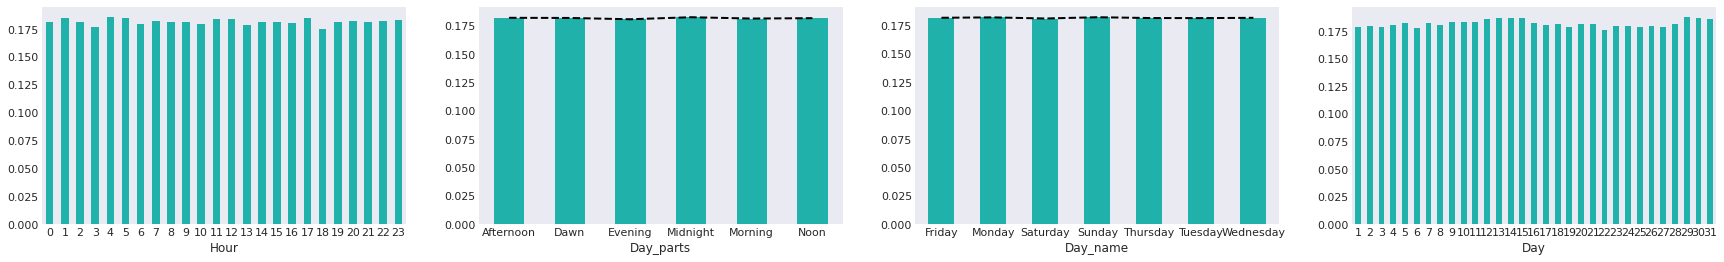

Instance: r3.2xlarge
Hour: Max avg price - min avg price = 0.00095
Day_parts: Max avg price - min avg price = 0.00015
Day_name: Max avg price - min avg price = 0.00021
Day: Max avg price - min avg price = 0.00116


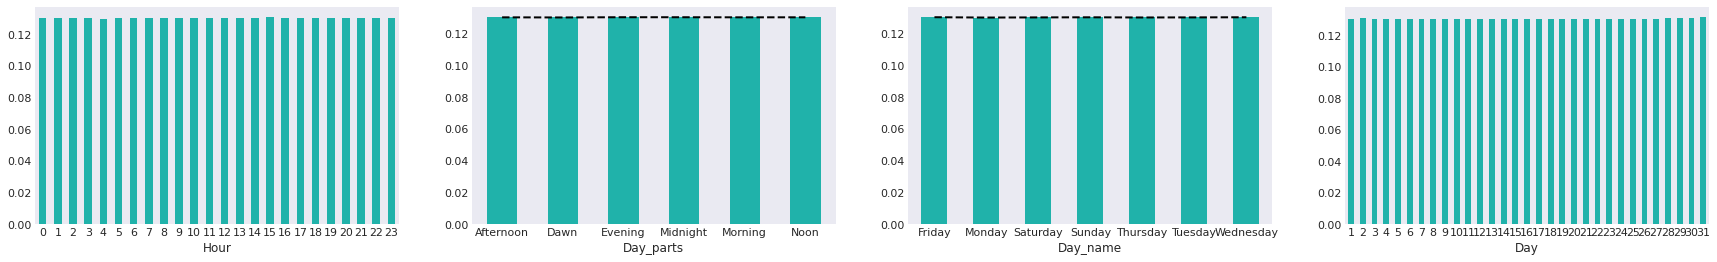

Instance: c4.4xlarge
Hour: Max avg price - min avg price = 0.01856
Day_parts: Max avg price - min avg price = 0.00607
Day_name: Max avg price - min avg price = 0.00798
Day: Max avg price - min avg price = 0.0356


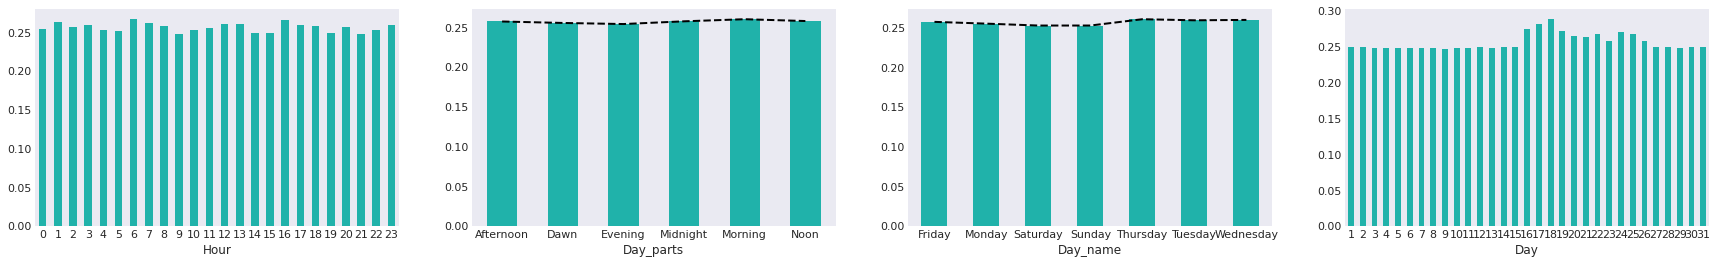

Instance: m4.large
Hour: Max avg price - min avg price = 0.01503
Day_parts: Max avg price - min avg price = 0.00393
Day_name: Max avg price - min avg price = 0.003
Day: Max avg price - min avg price = 0.01375


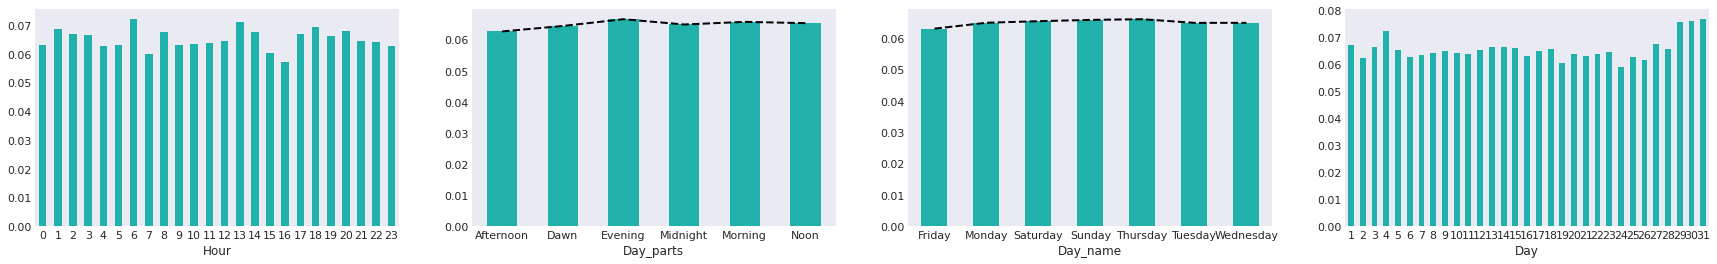

Instance: r3.xlarge
Hour: Max avg price - min avg price = 0.08736
Day_parts: Max avg price - min avg price = 0.0126
Day_name: Max avg price - min avg price = 0.00761
Day: Max avg price - min avg price = 0.06378


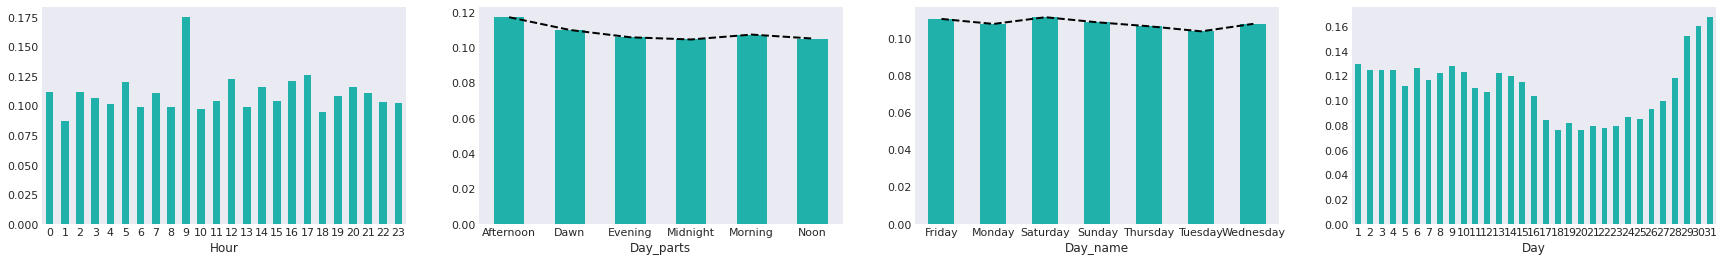

Instance: r4.4xlarge
Hour: Max avg price - min avg price = 0.00656
Day_parts: Max avg price - min avg price = 0.00313
Day_name: Max avg price - min avg price = 0.00189
Day: Max avg price - min avg price = 0.00516


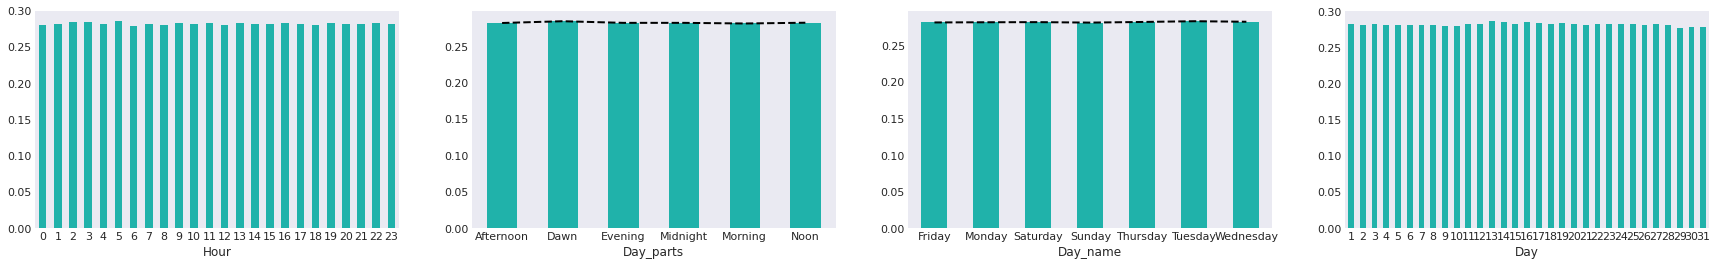

In [6]:
plt.rcParams["figure.figsize"] = [30, 4]

diff_Hour = []
diff_Day_parts = []
diff_Day_name = []
diff_Day = []

for ins in change:
    
    df = us_east_1e[(us_east_1e.InstanceType == ins)]
    
    fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4) 
    
    df.groupby(df["Hour"])["SpotPrice"].mean().plot(kind = 'bar', rot=0, ax = ax1, color = 'lightseagreen')
    
    df.groupby(df["Day_parts"])["SpotPrice"].mean().plot(rot=0, ax = ax2, color = 'black', linestyle = "--")
    df.groupby(df["Day_parts"])["SpotPrice"].mean().plot(kind = 'bar', rot=0, ax = ax2, color = 'lightseagreen')
    
    df.groupby(df["Day_name"])["SpotPrice"].mean().plot(rot=0, ax = ax3, color = 'black', linestyle = "--")
    df.groupby(df["Day_name"])["SpotPrice"].mean().plot(kind = 'bar', rot=0, ax = ax3, color = 'lightseagreen')
    
    df.groupby(df["Day"])["SpotPrice"].mean().plot(kind = 'bar', rot=0, ax = ax4, color = 'lightseagreen')
    
    diff1 = round(df.groupby(df["Hour"])["SpotPrice"].mean().values.max()- df.groupby(df["Hour"])["SpotPrice"].mean().values.min(), 5)
    diff2 = round(df.groupby(df["Day_parts"])["SpotPrice"].mean().values.max()- df.groupby(df["Day_parts"])["SpotPrice"].mean().values.min(), 5)
    diff3 = round(df.groupby(df["Day_name"])["SpotPrice"].mean().values.max()- df.groupby(df["Day_name"])["SpotPrice"].mean().values.min(), 5)
    diff4 = round(df.groupby(df["Day"])["SpotPrice"].mean().values.max()- df.groupby(df["Day_name"])["SpotPrice"].mean().values.min(), 5)
    
    diff_Hour.append(diff1)
    diff_Day_parts.append(diff2)
    diff_Day_name.append(diff3)
    diff_Day.append(diff4)
    
    print ('Instance: {}'.format(ins))
    print ('Hour: Max avg price - min avg price = {}'.format(diff1))
    print ('Day_parts: Max avg price - min avg price = {}'.format(diff2))
    print ('Day_name: Max avg price - min avg price = {}'.format(diff3))
    print ('Day: Max avg price - min avg price = {}'.format(diff4))
    
    plt.show()


In [7]:
plt.rcParams["figure.figsize"] = [12, 3]

diff_Weekend_ = []
diff_Holiday_ = []
diff_Month = []
diff_DayofYear = []
diff_Timedel = []

for ins in change:
    
    df = us_east_1e[(us_east_1e.InstanceType == ins)]
    
    diff5 = round(df.groupby(df["Weekend_(y/n)"])["SpotPrice"].mean().values.max()- df.groupby(df["Weekend_(y/n)"])["SpotPrice"].mean().values.min(), 5)
    diff6 = round(df.groupby(df["Holiday_(y/n)"])["SpotPrice"].mean().values.max()- df.groupby(df["Holiday_(y/n)"])["SpotPrice"].mean().values.min(), 5)
    diff7 = round(df.groupby(df["Month"])["SpotPrice"].mean().values.max()- df.groupby(df["Month"])["SpotPrice"].mean().values.min(), 5)
    diff8 = round(df.groupby(df["DayofYear"])["SpotPrice"].mean().values.max()- df.groupby(df["Month"])["SpotPrice"].mean().values.min(), 5)
    diff9 = round(df.groupby(df["Timedel"])["SpotPrice"].mean().values.max()- df.groupby(df["Timedel"])["SpotPrice"].mean().values.min(), 5)
    
    diff_Weekend_.append(diff5)
    diff_Holiday_.append(diff6)
    diff_Month.append(diff7)
    diff_DayofYear.append(diff8)
    diff_Timedel.append(diff9)

Hour: Distribution of average price of all the instances in us-east-1e


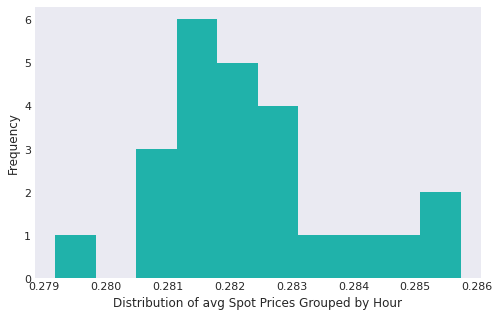

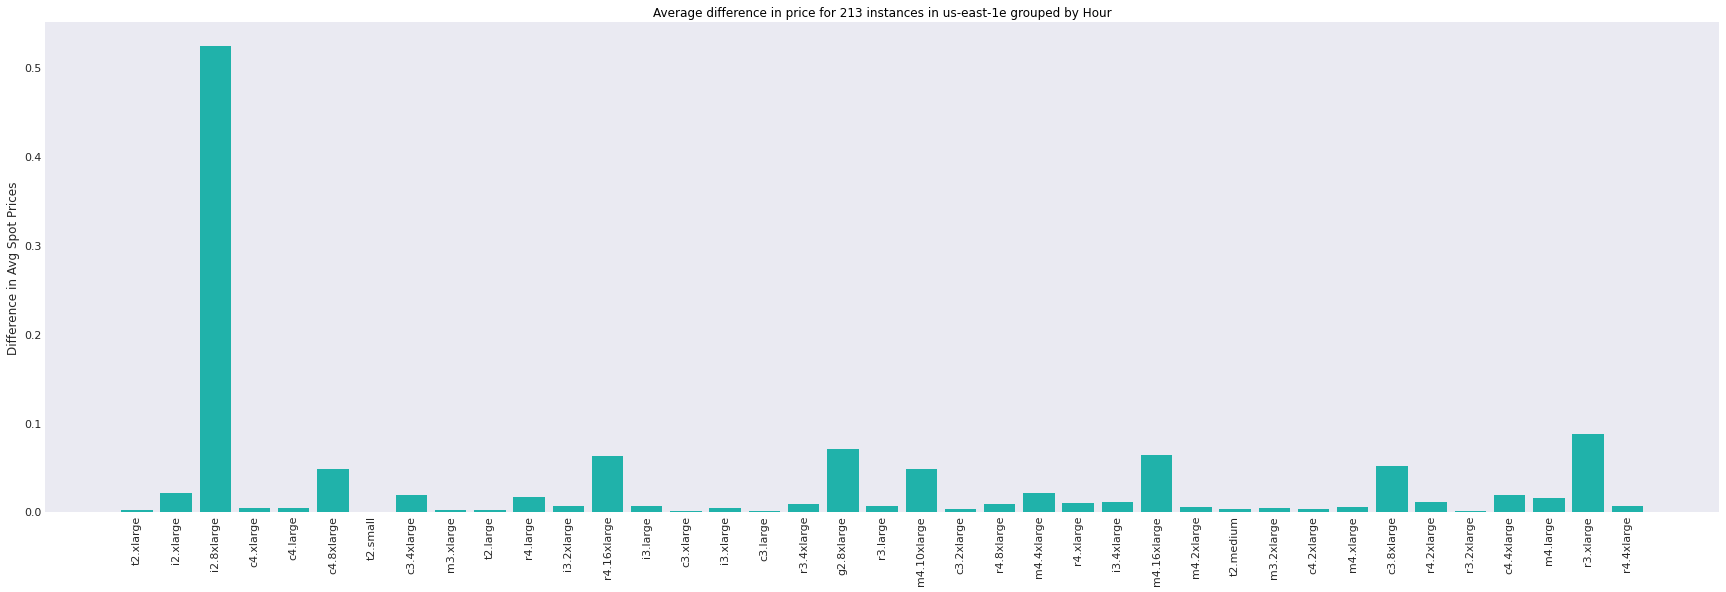

Day_parts: Distribution of average price of all the instances in us-east-1e


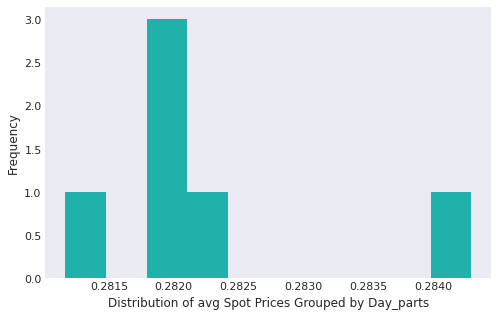

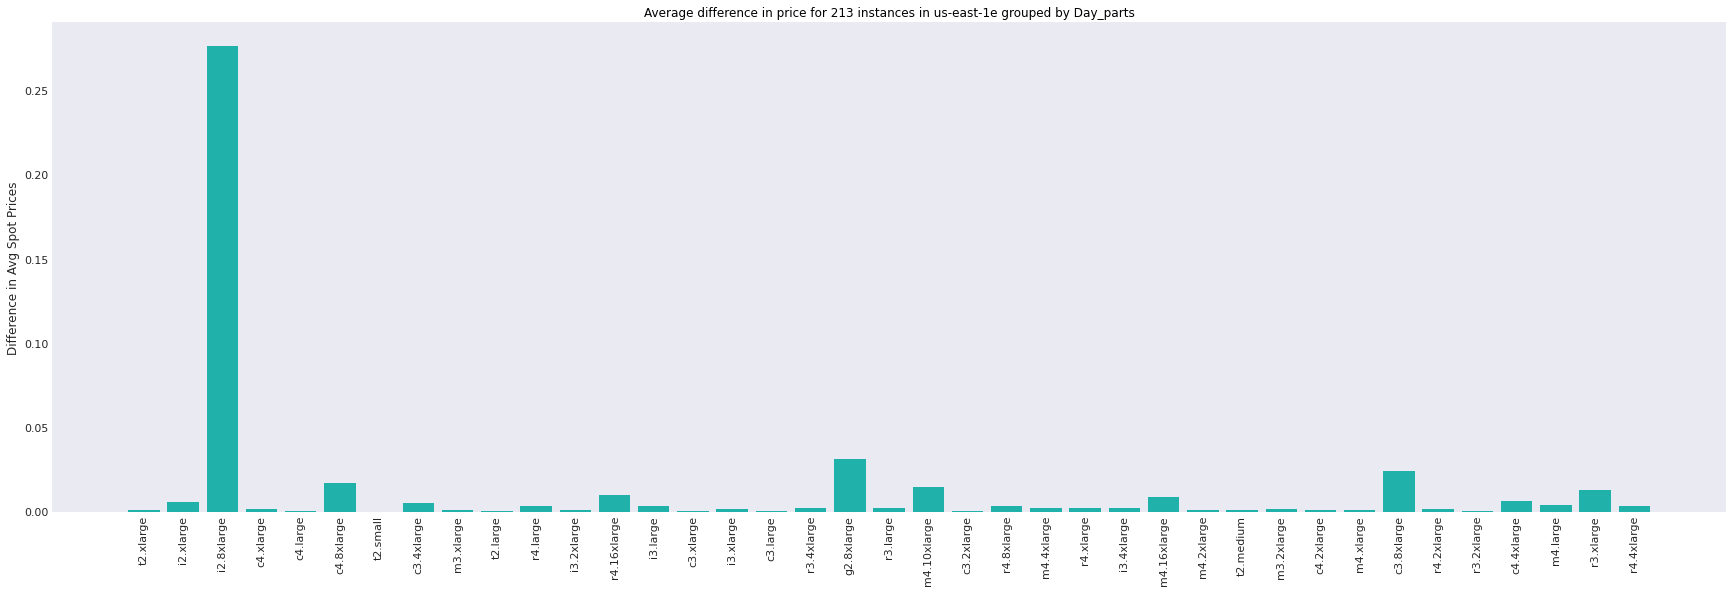

Day_name: Distribution of average price of all the instances in us-east-1e


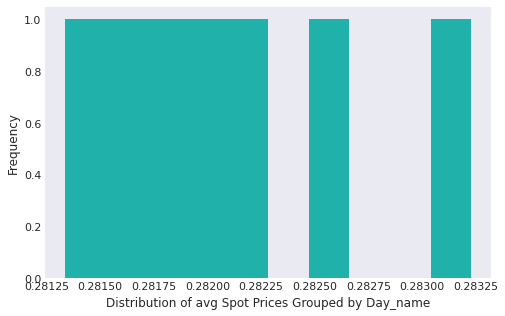

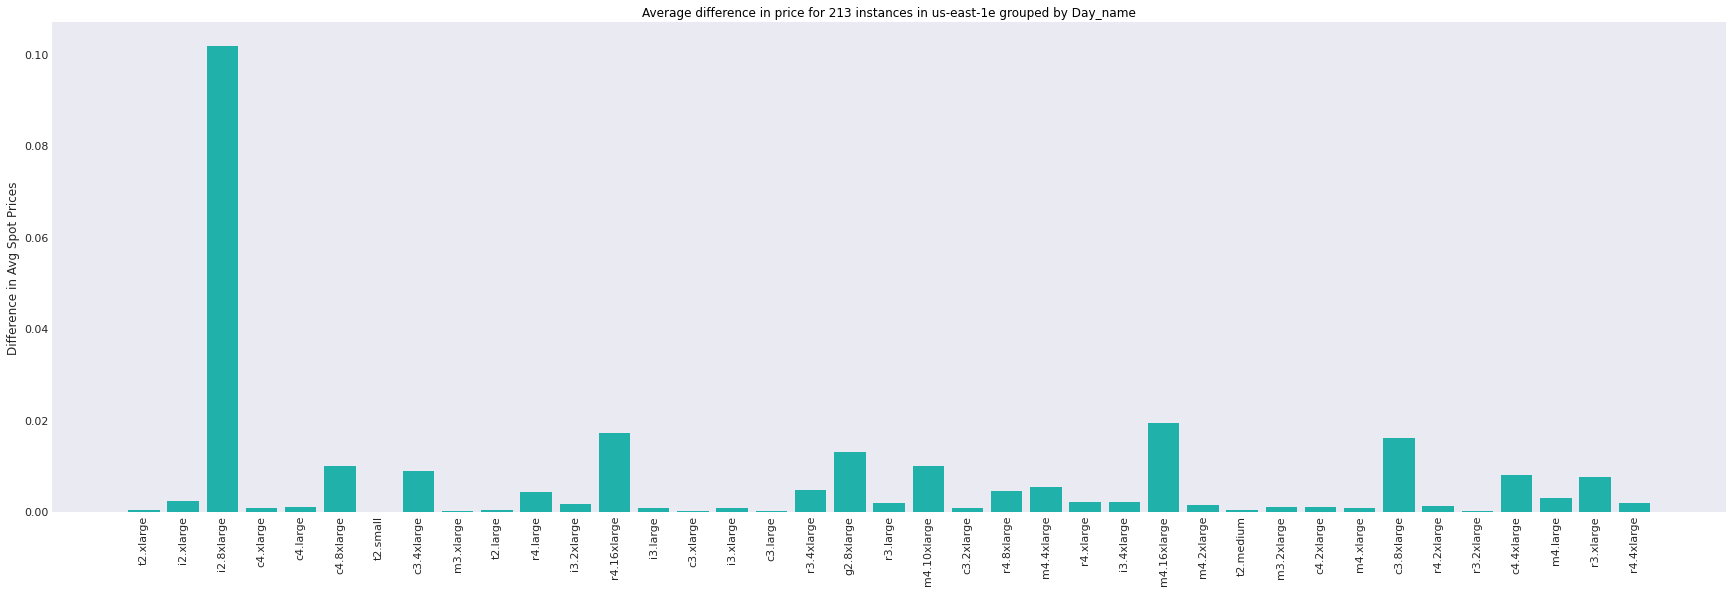

Day: Distribution of average price of all the instances in us-east-1e


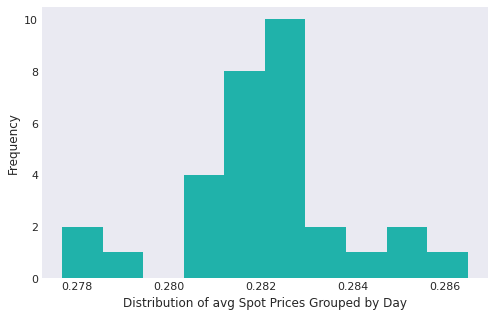

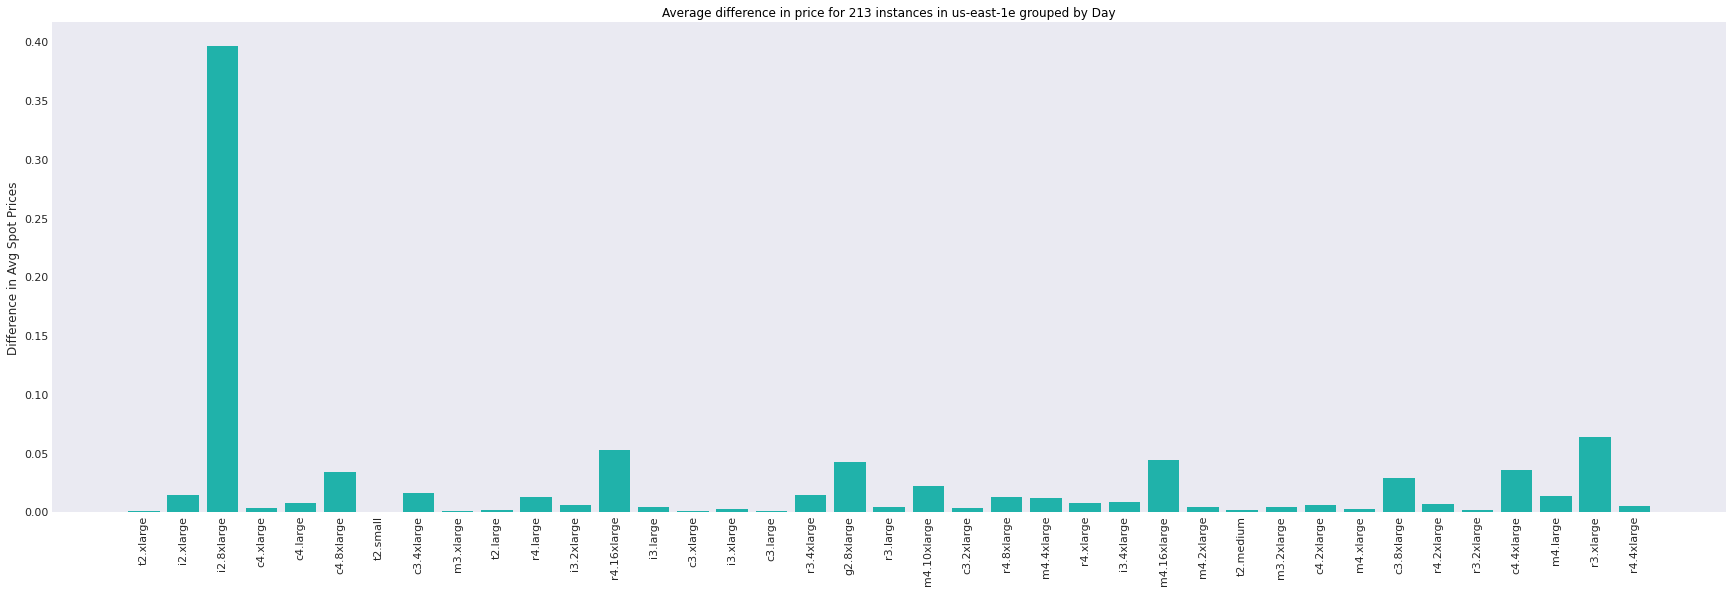

Weekend_(y/n): Distribution of average price of all the instances in us-east-1e


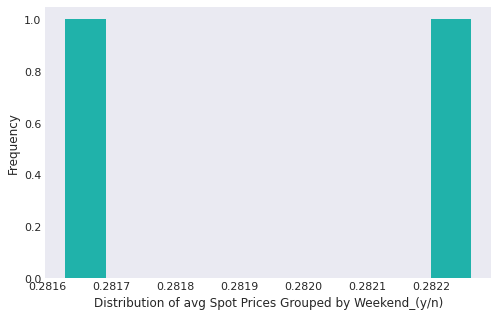

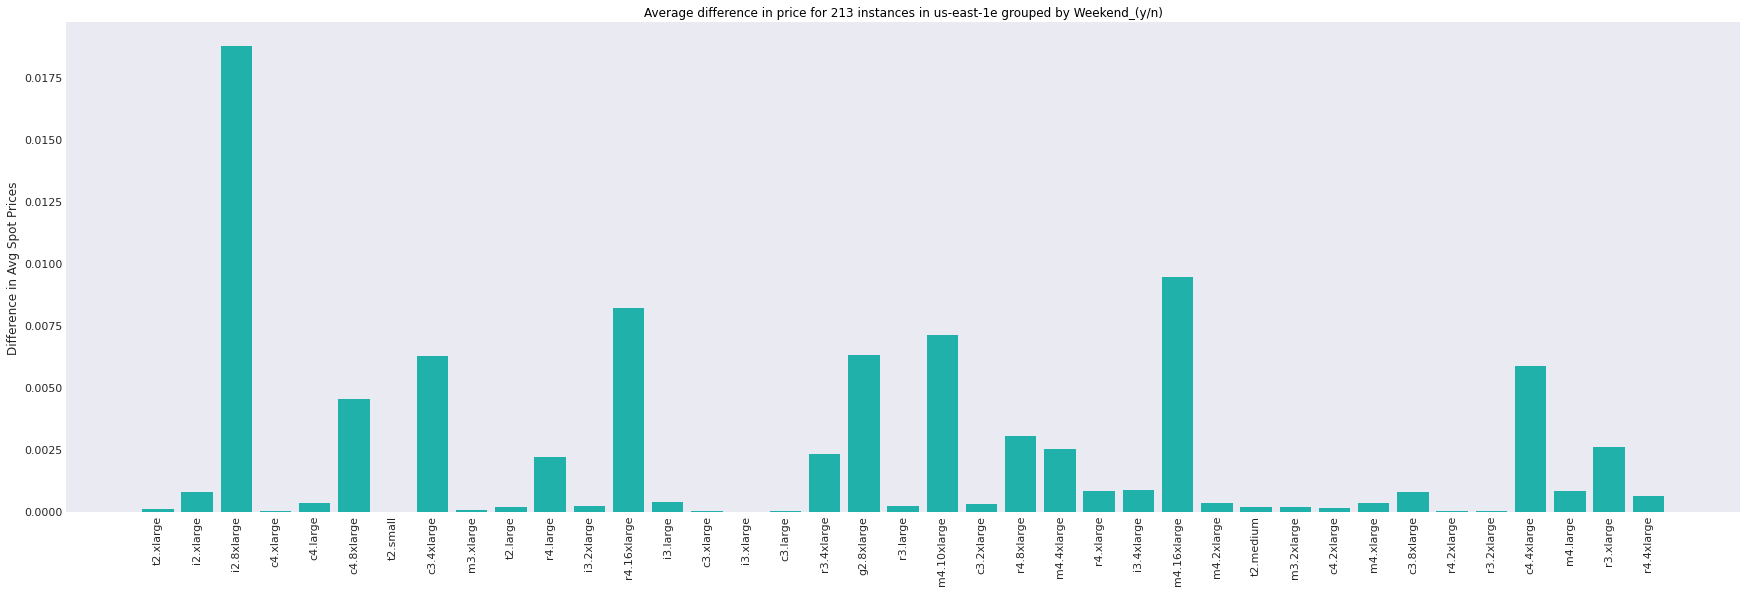

Holiday_(y/n): Distribution of average price of all the instances in us-east-1e


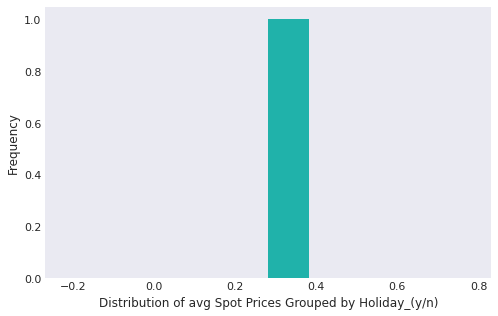

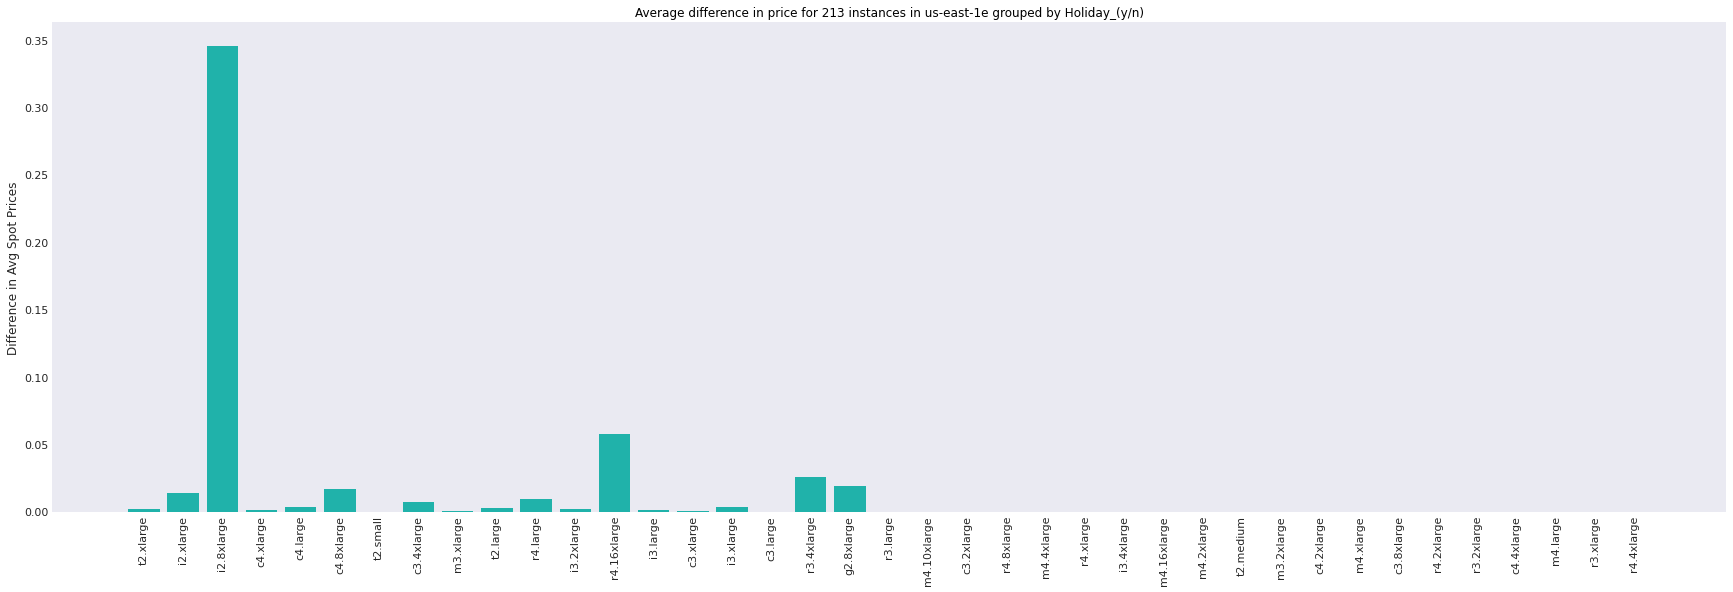

Month: Distribution of average price of all the instances in us-east-1e


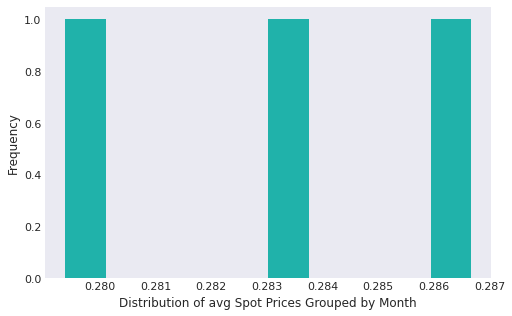

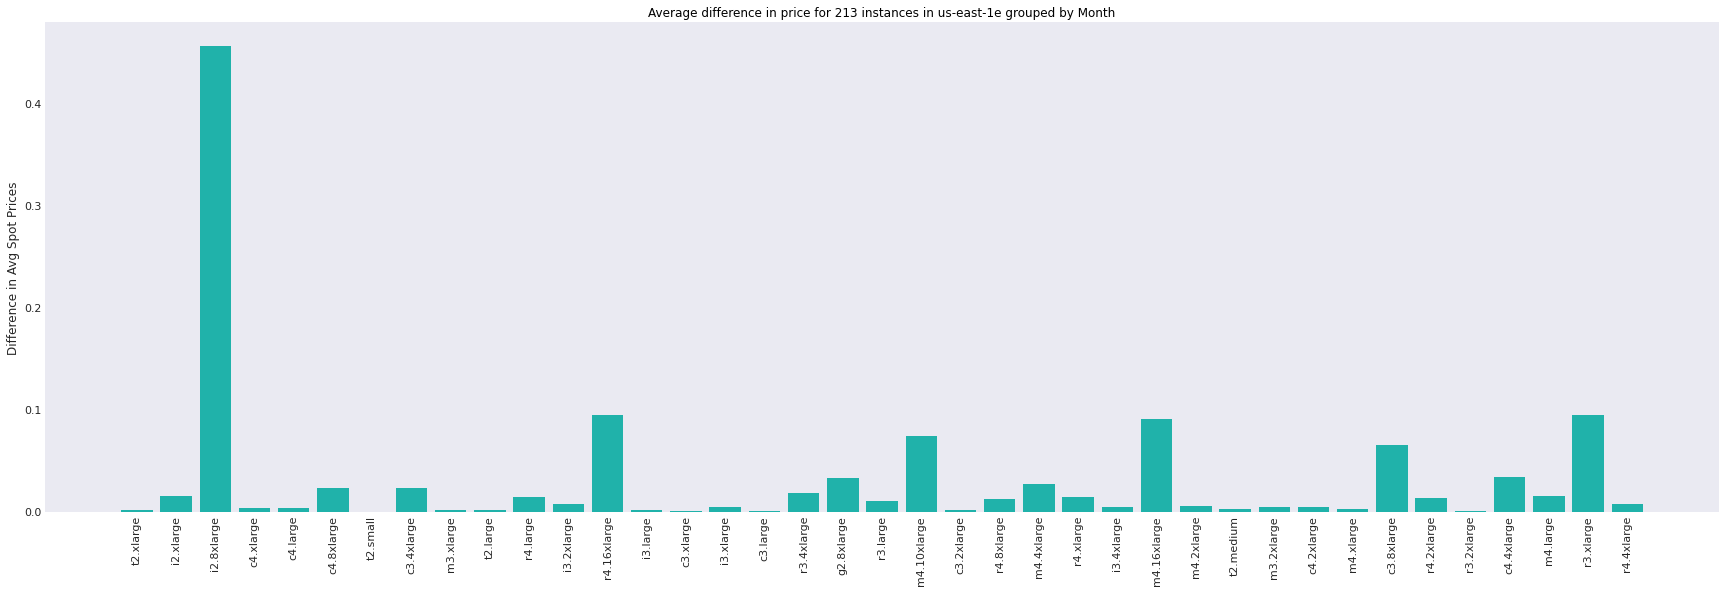

DayofYear: Distribution of average price of all the instances in us-east-1e


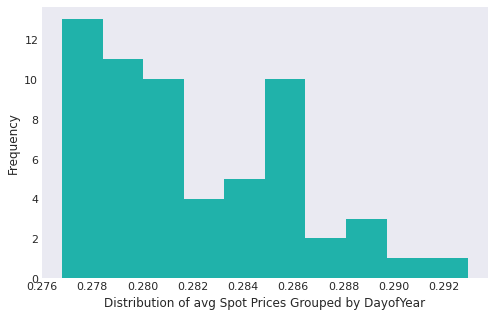

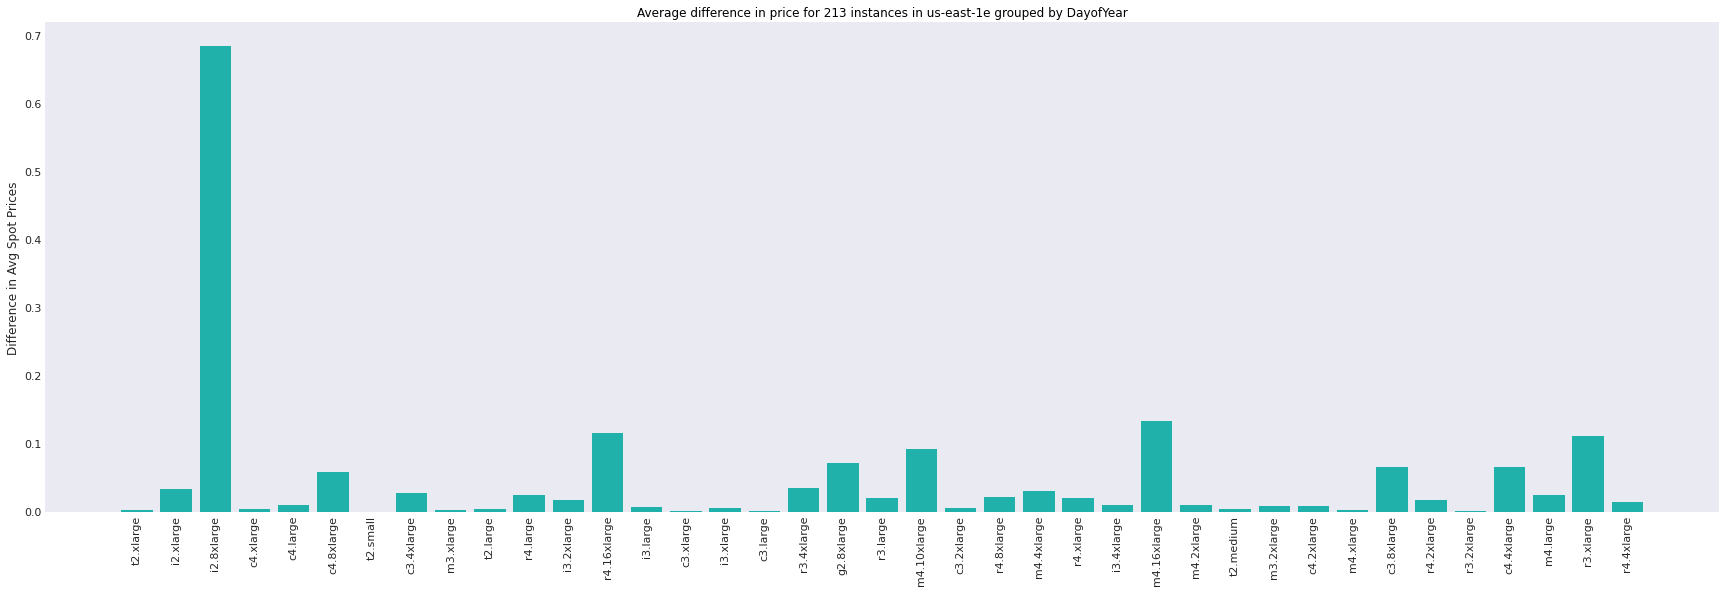

Timedel: Distribution of average price of all the instances in us-east-1e


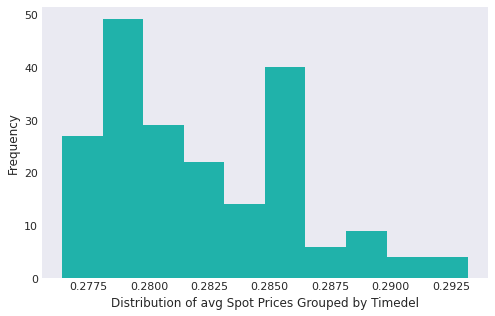

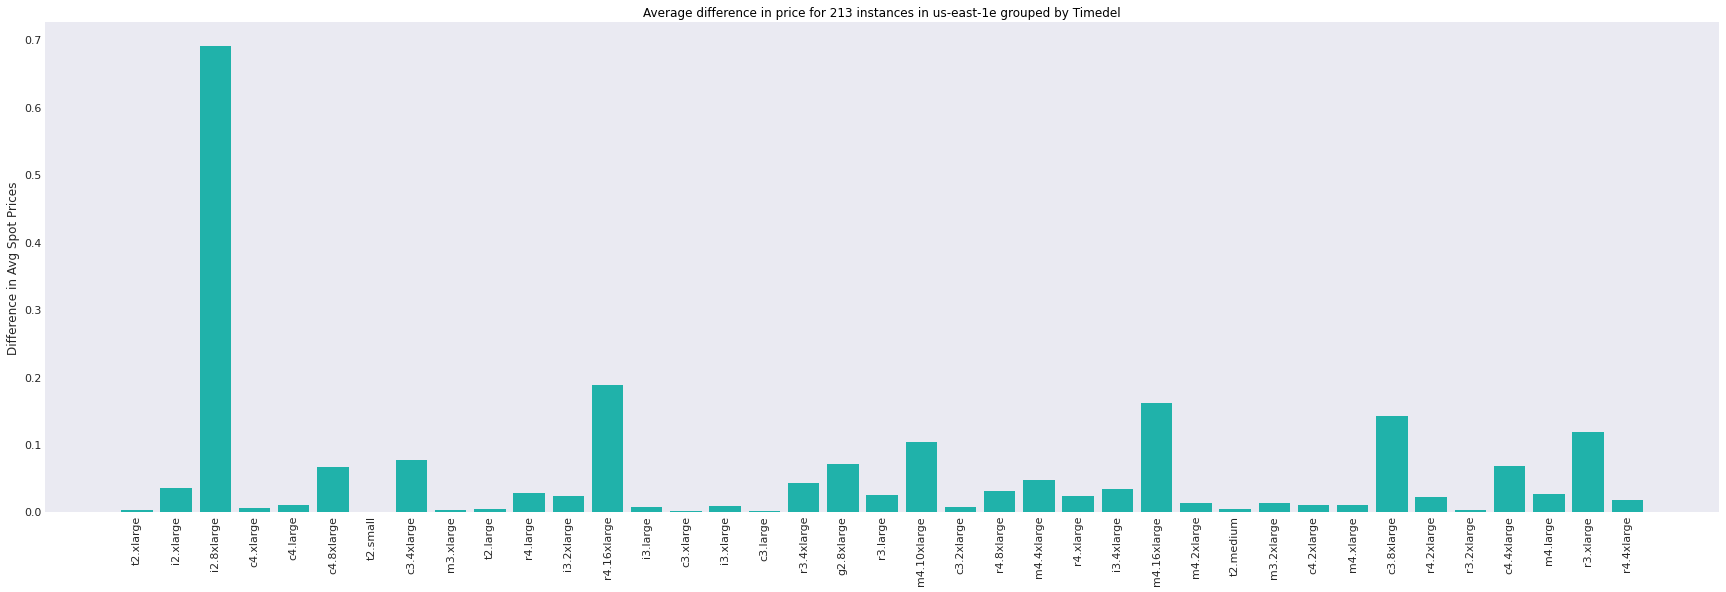

In [8]:
diff = [diff_Hour, diff_Day_parts, diff_Day_name, diff_Day, diff_Weekend_, diff_Holiday_, diff_Month, diff_DayofYear, diff_Timedel]
cols = ['Hour', 'Day_parts', 'Day_name', 'Day', 'Weekend_(y/n)', 'Holiday_(y/n)', 'Month', 'DayofYear', 'Timedel']

for d, col in zip(diff, cols):
    
    print ('{}: Distribution of average price of all the instances in us-east-1e'.format(col))
    
    plt.rcParams["figure.figsize"] = [8,5]
    avg = us_east_1e.groupby(df[col])["SpotPrice"].mean()
    avg.plot(kind = 'hist', color = 'lightseagreen')
    plt.xlabel('Distribution of avg Spot Prices Grouped by {}'.format(col))
    plt.show()

    plt.rcParams["figure.figsize"] = [30, 9]

    plt.bar(change, d, color = 'lightseagreen')
    plt.title('Average difference in price for 213 instances in us-east-1e grouped by {}'.format(col), fontsize = 'large')
    plt.ylabel('Difference in Avg Spot Prices')
    plt.xticks(rotation=90)
    plt.show()

In [9]:
diff = [diff_Hour, diff_Day_parts, diff_Day_name, diff_Day, diff_Weekend_, diff_Holiday_, diff_Month, diff_DayofYear, diff_Timedel]
cols = ['Hour', 'Day_parts', 'Day_name', 'Day', 'Weekend_(y/n)', 'Holiday_(y/n)', 'Month', 'DayofYear', 'Timedel']

all_feat_max = []

for d in diff:
    
    all_feat_max.append(max(d))

<BarContainer object of 9 artists>

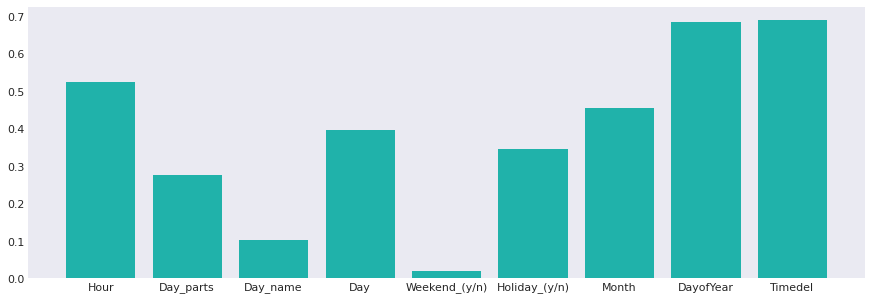

In [10]:
plt.rcParams["figure.figsize"] = [15, 5]

plt.bar(cols, all_feat_max, color = 'lightseagreen')

## Feature exploration (brief version) of all instances 

#### dataset 1 contains datapoints through: 02/14/2021- 04/17/2021
#### dataset 2 contains datapoints through: 03/03/2021- 05/03/2021 

In [11]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import datetime as dt
from datetime import datetime, timedelta
from datetime import date
import holidays

import matplotlib.pyplot as plt
import seaborn as sns

import itertools
plt.style.use('seaborn-paper')
import statsmodels.api as sm
import matplotlib
matplotlib.rcParams['axes.labelsize'] = 12
matplotlib.rcParams['xtick.labelsize'] = 11
matplotlib.rcParams['ytick.labelsize'] = 11
matplotlib.rcParams['text.color'] = 'k'
plt.rcParams["figure.figsize"] = [8, 6]
plt.rcParams['lines.linewidth'] = 2
import matplotlib.dates as mdates

import warnings
warnings.filterwarnings('ignore')

### Data Preprocessing (Not Sampled, Raw dataset collected through AWS CLI)

#### 02/14/2021- 04/17/2021

In [12]:
df1 = pd.read_csv('../input/aws-spot-price-15th-feb16th-april-2021/us-east-1_Feb15-Apr16.csv')
df1['Timestamp'] = pd.to_datetime(df1['Timestamp'], format = '%Y-%m-%d %H:%M:%S.%f', utc=True)
df1 = df1.sort_values(by="Timestamp")

# Filtering the dataset for OS-type = 'Linux/UNIX' only
df1 = df1[(df1.ProductDescription == 'Linux/UNIX')].sort_values(by="Timestamp") 
df1.drop('ProductDescription', axis=1, inplace=True)  

df1 = df1.set_index(['AvailabilityZone', 'InstanceType', 'Timestamp'])
print(df1.shape)
df1.head()

(226586, 1)


SpotPrice
AvailabilityZone InstanceType Timestamp                           
us-east-1c       c5d.metal    2021-02-15 05:39:29+00:00     1.5546
us-east-1d       c5d.metal    2021-02-15 05:39:29+00:00     1.5546
us-east-1a       c5d.metal    2021-02-15 05:39:29+00:00     1.5546
                 d2.4xlarge   2021-02-15 05:44:53+00:00     0.8280
us-east-1f       d2.4xlarge   2021-02-15 05:44:53+00:00     0.8280

In [13]:
us_east_1a1 = df1.reset_index()
us_east_1a1 = us_east_1a1[(us_east_1a1.AvailabilityZone == 'us-east-1a')]
instances_1a1 = us_east_1a1.InstanceType.unique().tolist()

us_east_1b1 = df1.reset_index()
us_east_1b1 = us_east_1b1[(us_east_1b1.AvailabilityZone == 'us-east-1b')]
instances_1b1 = us_east_1b1.InstanceType.unique().tolist()

us_east_1c1 = df1.reset_index()
us_east_1c1 = us_east_1c1[(us_east_1c1.AvailabilityZone == 'us-east-1c')]
instances_1c1 = us_east_1c1.InstanceType.unique().tolist()

us_east_1d1 = df1.reset_index()
us_east_1d1 = us_east_1d1[(us_east_1d1.AvailabilityZone == 'us-east-1d')]
instances_1d1 = us_east_1d1.InstanceType.unique().tolist()

us_east_1e1 = df1.reset_index()
us_east_1e1 = us_east_1e1[(us_east_1e1.AvailabilityZone == 'us-east-1e')]
instances_1e1 = us_east_1e1.InstanceType.unique().tolist()

us_east_1f1 = df1.reset_index()
us_east_1f1 = us_east_1f1[(us_east_1f1.AvailabilityZone == 'us-east-1f')]
instances_1f1 = us_east_1f1.InstanceType.unique().tolist()

#### 03/03/2021- 05/03/2021

In [14]:
df2 = pd.read_csv('../input/aws-spot-price-3rd-march3rd-may-2021/us-east-1_Mar03-May03.csv')
df2['Timestamp'] = pd.to_datetime(df2['Timestamp'], format = '%Y-%m-%d %H:%M:%S.%f', utc=True)
df2 = df2.sort_values(by="Timestamp")

# Filtering the dataset for OS-type = 'Linux/UNIX' only
df2 = df2[(df2.ProductDescription == 'Linux/UNIX')].sort_values(by="Timestamp") 
df2.drop('ProductDescription', axis=1, inplace=True)  

df2 = df2.set_index(['AvailabilityZone', 'InstanceType', 'Timestamp'])
print(df2.shape)
df2.head()

(230565, 1)


SpotPrice
AvailabilityZone InstanceType  Timestamp                           
us-east-1b       p3dn.24xlarge 2021-03-03 15:46:05+00:00     9.3636
us-east-1a       p3dn.24xlarge 2021-03-03 15:46:05+00:00     9.3636
us-east-1f       c5.9xlarge    2021-03-03 15:46:12+00:00     0.5830
us-east-1a       c4.large      2021-03-03 15:46:13+00:00     0.0315
                 c6g.2xlarge   2021-03-03 15:46:24+00:00     0.1360

In [15]:
us_east_1a2 = df2.reset_index()
us_east_1a2 = us_east_1a2[(us_east_1a2.AvailabilityZone == 'us-east-1a')]
instances_1a2 = us_east_1a2.InstanceType.unique().tolist()

us_east_1b2 = df2.reset_index()
us_east_1b2 = us_east_1b2[(us_east_1b2.AvailabilityZone == 'us-east-1b')]
instances_1b2 = us_east_1b2.InstanceType.unique().tolist()

us_east_1c2 = df2.reset_index()
us_east_1c2 = us_east_1c2[(us_east_1c2.AvailabilityZone == 'us-east-1c')]
instances_1c2 = us_east_1c2.InstanceType.unique().tolist()

us_east_1d2 = df2.reset_index()
us_east_1d2 = us_east_1d2[(us_east_1d2.AvailabilityZone == 'us-east-1d')]
instances_1d2 = us_east_1d2.InstanceType.unique().tolist()

us_east_1e2 = df2.reset_index()
us_east_1e2 = us_east_1e2[(us_east_1e2.AvailabilityZone == 'us-east-1e')]
instances_1e2 = us_east_1e2.InstanceType.unique().tolist()

us_east_1f2 = df2.reset_index()
us_east_1f2 = us_east_1f2[(us_east_1f2.AvailabilityZone == 'us-east-1f')]
instances_1f2 = us_east_1f2.InstanceType.unique().tolist()

### Feature Engineering

In [16]:
def feat_eng(df):
    
    df['Date'] = df['Timestamp'].dt.date
    df['Date'] = pd.to_datetime(df['Date'])

    df['Year'] = df['Timestamp'].dt.year
    df['Month'] = df['Timestamp'].dt.month
    df['Day'] = df['Timestamp'].dt.day
    df['Day_name'] = df['Timestamp'].dt.day_name()
    df['Hour'] = df['Timestamp'].dt.hour

    # daypart function
    def daypart(hour):
        if hour in [2,3,4,5]:
            return "Dawn"
        elif hour in [6,7,8,9]:
            return "Morning"
        elif hour in [10,11,12,13]:
            return "Noon"
        elif hour in [14,15,16,17]:
            return "Afternoon"
        elif hour in [18,19,20,21]:
            return "Evening"
        else: return "Midnight"
    
    df['Day_parts'] = raw_dayparts = df.Timestamp.dt.hour.apply(daypart)


    df['Weekday'] = df['Timestamp'].dt.weekday
    df['Weekend_(y/n)'] = ((df['Timestamp'].dt.dayofweek) // 5 == 1).astype(float)
    df['DayofYear'] = df['Timestamp'].dt.dayofyear


    us_holidays = holidays.UnitedStates() 
    hd = []

    # Print all the holidays in UnitedKingdom in year 2018
    for ptr in holidays.US(years = 2021).items():
        #print(ptr)
        hd.append(ptr[0])

    def extractServiceName(x):
        if x in hd:
            return 1
        else:
            return 0

    df['Holiday_(y/n)'] = df['Date'].apply(lambda x : extractServiceName(x))

    # Convert the date into a number (of days since some point)
    fromDate = min(df['Timestamp'])
    df['Timedel'] = (df['Timestamp'] - fromDate).astype(np.int64)/100000000000

    df.drop('Timestamp', axis = 1, inplace = True)

    df = df.reset_index(drop = True)

    print (df.shape)
    
    return df

In [17]:
# 1s are from 04/17/2021

us_east_1a1 = feat_eng(us_east_1a1)
us_east_1b1 = feat_eng(us_east_1b1)
us_east_1c1 = feat_eng(us_east_1c1)
us_east_1d1 = feat_eng(us_east_1d1)
us_east_1e1 = feat_eng(us_east_1e1)
us_east_1f1 = feat_eng(us_east_1f1)

# 2s are from 05/03/2021

us_east_1a2 = feat_eng(us_east_1a2)
us_east_1b2 = feat_eng(us_east_1b2)
us_east_1c2 = feat_eng(us_east_1c2)
us_east_1d2 = feat_eng(us_east_1d2)
us_east_1e2 = feat_eng(us_east_1e2)
us_east_1f2 = feat_eng(us_east_1f2)

(46872, 15)
(42505, 15)
(44455, 15)
(47920, 15)
(8388, 15)
(36446, 15)
(47619, 15)
(43371, 15)
(45391, 15)
(48316, 15)
(8461, 15)
(37407, 15)


In [18]:
us_east_1a1.head()

AvailabilityZone   InstanceType  SpotPrice       Date  Year  Month  Day  \
0       us-east-1a      c5d.metal     1.5546 2021-02-15  2021      2   15   
1       us-east-1a     d2.4xlarge     0.8280 2021-02-15  2021      2   15   
2       us-east-1a     c6g.xlarge     0.0680 2021-02-15  2021      2   15   
3       us-east-1a  i3en.12xlarge     1.6272 2021-02-15  2021      2   15   
4       us-east-1a      m6g.large     0.0357 2021-02-15  2021      2   15   

  Day_name  Hour Day_parts  Weekday  Weekend_(y/n)  DayofYear  Holiday_(y/n)  \
0   Monday     5      Dawn        0            0.0         46              1   
1   Monday     5      Dawn        0            0.0         46              1   
2   Monday     6   Morning        0            0.0         46              1   
3   Monday     6   Morning        0            0.0         46              1   
4   Monday     6   Morning        0            0.0         46              1   

   Timedel  
0     0.00  
1     3.24  
2    12.81  
3    16.89  
4    36.87

In [19]:
us_east_1f2.head()

AvailabilityZone  InstanceType  SpotPrice       Date  Year  Month  Day  \
0       us-east-1f    c5.9xlarge     0.5830 2021-03-03  2021      3    3   
1       us-east-1f   c6g.2xlarge     0.1360 2021-03-03  2021      3    3   
2       us-east-1f  i3en.3xlarge     0.4068 2021-03-03  2021      3    3   
3       us-east-1f     d2.xlarge     0.2070 2021-03-03  2021      3    3   
4       us-east-1f    r5n.xlarge     0.0732 2021-03-03  2021      3    3   

    Day_name  Hour  Day_parts  Weekday  Weekend_(y/n)  DayofYear  \
0  Wednesday    15  Afternoon        2            0.0         62   
1  Wednesday    15  Afternoon        2            0.0         62   
2  Wednesday    15  Afternoon        2            0.0         62   
3  Wednesday    15  Afternoon        2            0.0         62   
4  Wednesday    16  Afternoon        2            0.0         62   

   Holiday_(y/n)  Timedel  
0              0     0.00  
1              0     0.12  
2              0     1.36  
3              0     1.39  
4              0    20.91

In [20]:
def instance_variation_count_(df, instances_):
    
        change_ = []
        no_change_ = []
        amount_change_ = []

        for ins in instances_:
            
            df_ = df[(df.InstanceType == ins)]
            
            if (df_.SpotPrice.max() - df_.SpotPrice.min()) == 0:
                no_change_.append(ins)
            else:
                change_.append(ins)
                amount_change_.append(abs(df_.SpotPrice.max() - df_.SpotPrice.min()))
                
        print ('{}: {} to {}'.format(df.AvailabilityZone[0], str(df.Date.dt.date.min()), str(df.Date.dt.date.max())))
        print ('Number of instances having variable pricing during these 2 months: {}'.format(len(change_)))
        print ('Number of instances having constant pricing during these 2 months: {}'.format(len(no_change_)))
        print ('    ')
        
        return change_, no_change_, amount_change_

In [21]:
change_1a1, no_change_1a1, amount_change_1a1 = instance_variation_count_(us_east_1a1, instances_1a1)
change_1a2, no_change_1a2, amount_change_1a2 = instance_variation_count_(us_east_1a2, instances_1a2)

change_1b1, no_change_1b1, amount_change_1b1 = instance_variation_count_(us_east_1b1, instances_1b1)
change_1b2, no_change_1b2, amount_change_1b2 = instance_variation_count_(us_east_1b2, instances_1b2)

change_1c1, no_change_1c1, amount_change_1c1 = instance_variation_count_(us_east_1c1, instances_1c1)
change_1c2, no_change_1c2, amount_change_1c2 = instance_variation_count_(us_east_1c2, instances_1c2)

change_1d1, no_change_1d1, amount_change_1d1 = instance_variation_count_(us_east_1d1, instances_1d1)
change_1d2, no_change_1d2, amount_change_1d2 = instance_variation_count_(us_east_1d2, instances_1d2)

change_1e1, no_change_1e1, amount_change_1e1 = instance_variation_count_(us_east_1e1, instances_1e1)
change_1e2, no_change_1e2, amount_change_1e2 = instance_variation_count_(us_east_1e2, instances_1e2)

change_1f1, no_change_1f1, amount_change_1f1 = instance_variation_count_(us_east_1f1, instances_1f1)
change_1f2, no_change_1f2, amount_change_1f2 = instance_variation_count_(us_east_1f2, instances_1f2)

us-east-1a: 2021-02-15 to 2021-04-17
Number of instances having variable pricing during these 2 months: 213
Number of instances having constant pricing during these 2 months: 170
    
us-east-1a: 2021-03-03 to 2021-05-03
Number of instances having variable pricing during these 2 months: 215
Number of instances having constant pricing during these 2 months: 174
    
us-east-1b: 2021-02-15 to 2021-04-17
Number of instances having variable pricing during these 2 months: 195
Number of instances having constant pricing during these 2 months: 161
    
us-east-1b: 2021-03-03 to 2021-05-03
Number of instances having variable pricing during these 2 months: 195
Number of instances having constant pricing during these 2 months: 161
    
us-east-1c: 2021-02-15 to 2021-04-17
Number of instances having variable pricing during these 2 months: 206
Number of instances having constant pricing during these 2 months: 163
    
us-east-1c: 2021-03-03 to 2021-05-03
Number of instances having variable pricing

### Common instances from both timeframe with variable pricing

In [22]:
def common_elements(list1, list2):
    return [element for element in list1 if element in list2]

u_east_1a_var = common_elements(change_1a1, change_1a2)
print (len(u_east_1a_var))

u_east_1b_var = common_elements(change_1b1, change_1b2)
print (len(u_east_1b_var))

u_east_1c_var = common_elements(change_1c1, change_1c2)
print (len(u_east_1c_var))

u_east_1d_var = common_elements(change_1d1, change_1d2)
print (len(u_east_1d_var))

u_east_1e_var = common_elements(change_1e1, change_1e2)
print (len(u_east_1e_var))

u_east_1f_var = common_elements(change_1f1, change_1f2)
print (len(u_east_1f_var))

210
182
201
219
39
162


In [23]:
def plot_mean_difference(df1, df2, var):


        diff_Hour = []
        diff_Day_parts = []
        diff_Day_name = []
        diff_Day = []
        diff_Weekend_ = []
        diff_Holiday_ = []
        diff_Month = []
        diff_DayofYear = []
        diff_Timedel = []
        
        diff_Hour_ = []
        diff_Day_parts_ = []
        diff_Day_name_ = []
        diff_Day_ = []
        diff_Weekend__ = []
        diff_Holiday__ = []
        diff_Month_ = []
        diff_DayofYear_ = []
        diff_Timedel_ = []

        for ins in var:
            
            df = df1[(df1.InstanceType == ins)]
            df_ = df2[(df2.InstanceType == ins)]
            
            
            diff1 = round(df.groupby(df["Hour"])["SpotPrice"].mean().values.max()- df.groupby(df["Hour"])["SpotPrice"].mean().values.min(), 5)
            diff2 = round(df.groupby(df["Day_parts"])["SpotPrice"].mean().values.max()- df.groupby(df["Day_parts"])["SpotPrice"].mean().values.min(), 5)
            diff3 = round(df.groupby(df["Day_name"])["SpotPrice"].mean().values.max()- df.groupby(df["Day_name"])["SpotPrice"].mean().values.min(), 5)
            diff4 = round(df.groupby(df["Day"])["SpotPrice"].mean().values.max()- df.groupby(df["Day"])["SpotPrice"].mean().values.min(), 5)
            diff5 = round(df.groupby(df["Weekend_(y/n)"])["SpotPrice"].mean().values.max()- df.groupby(df["Weekend_(y/n)"])["SpotPrice"].mean().values.min(), 5)
            diff6 = round(df.groupby(df["Holiday_(y/n)"])["SpotPrice"].mean().values.max()- df.groupby(df["Holiday_(y/n)"])["SpotPrice"].mean().values.min(), 5)
            diff7 = round(df.groupby(df["Month"])["SpotPrice"].mean().values.max()- df.groupby(df["Month"])["SpotPrice"].mean().values.min(), 5)
            diff8 = round(df.groupby(df["DayofYear"])["SpotPrice"].mean().values.max()- df.groupby(df["DayofYear"])["SpotPrice"].mean().values.min(), 5)
            diff9 = round(df.groupby(df["Timedel"])["SpotPrice"].mean().values.max()- df.groupby(df["Timedel"])["SpotPrice"].mean().values.min(), 5)
            
            diff_Hour.append(diff1)
            diff_Day_parts.append(diff2)
            diff_Day_name.append(diff3)
            diff_Day.append(diff4)
            diff_Weekend_.append(diff5)
            diff_Holiday_.append(diff6)
            diff_Month.append(diff7)
            diff_DayofYear.append(diff8)
            diff_Timedel.append(diff9)
            
            diff1_ = round(df_.groupby(df_["Hour"])["SpotPrice"].mean().values.max()- df_.groupby(df_["Hour"])["SpotPrice"].mean().values.min(), 5)
            diff2_ = round(df_.groupby(df_["Day_parts"])["SpotPrice"].mean().values.max()- df_.groupby(df_["Day_parts"])["SpotPrice"].mean().values.min(), 5)
            diff3_ = round(df_.groupby(df_["Day_name"])["SpotPrice"].mean().values.max()- df_.groupby(df_["Day_name"])["SpotPrice"].mean().values.min(), 5)
            diff4_ = round(df_.groupby(df_["Day"])["SpotPrice"].mean().values.max()- df_.groupby(df_["Day"])["SpotPrice"].mean().values.min(), 5)
            diff5_ = round(df_.groupby(df_["Weekend_(y/n)"])["SpotPrice"].mean().values.max()- df_.groupby(df_["Weekend_(y/n)"])["SpotPrice"].mean().values.min(), 5)
            diff6_ = round(df_.groupby(df_["Holiday_(y/n)"])["SpotPrice"].mean().values.max()- df_.groupby(df_["Holiday_(y/n)"])["SpotPrice"].mean().values.min(), 5)
            diff7_ = round(df_.groupby(df_["Month"])["SpotPrice"].mean().values.max()- df_.groupby(df_["Month"])["SpotPrice"].mean().values.min(), 5)
            diff8_ = round(df_.groupby(df_["DayofYear"])["SpotPrice"].mean().values.max()- df_.groupby(df_["DayofYear"])["SpotPrice"].mean().values.min(), 5)
            diff9_ = round(df_.groupby(df_["Timedel"])["SpotPrice"].mean().values.max()- df_.groupby(df_["Timedel"])["SpotPrice"].mean().values.min(), 5)
            
            diff_Hour_.append(diff1_)
            diff_Day_parts_.append(diff2_)
            diff_Day_name_.append(diff3_)
            diff_Day_.append(diff4_)
            diff_Weekend__.append(diff5_)
            diff_Holiday__.append(diff6_)
            diff_Month_.append(diff7_)
            diff_DayofYear_.append(diff8_)
            diff_Timedel_.append(diff9_)
            
        
        plt.rcParams["figure.figsize"] = [30, 9]
        plt.bar(var, diff_Hour, color = 'lightseagreen', label = '04/17/2021')
        plt.plot(var, diff_Hour_, color = 'black', linestyle = '--', linewidth = 1.5, label = '05/03/2021')
        plt.title('Average difference in price of {} instances of {} grouped by Hour'.format(len(var), df2.AvailabilityZone[0]), fontsize=18)
        plt.ylabel('Average difference in spot price', fontsize=14)
        plt.xlabel('Instances', fontsize=14)
        plt.legend(fontsize = 'large')
        plt.xticks(rotation = 90)
        plt.show()
        
        plt.rcParams["figure.figsize"] = [30, 9]
        plt.bar(var, diff_Day_parts, color = 'lightgray', label = '04/17/2021')
        plt.plot(var, diff_Day_parts_, color = 'black', linestyle = '--', linewidth = 1.5, label = '05/03/2021')
        plt.title('Average difference in price of {} instances of {} grouped by Day_parts'.format(len(var), df2.AvailabilityZone[0]), fontsize=18)
        plt.ylabel('Average difference in spot price', fontsize=14)
        plt.xlabel('Instances', fontsize=14)
        plt.legend(fontsize = 'large')
        plt.xticks(rotation = 90)
        plt.show()
        
        plt.rcParams["figure.figsize"] = [30, 9]
        plt.bar(var, diff_Day_name, color = 'lightblue', label = '04/17/2021')
        plt.plot(var, diff_Day_name_, color = 'gray', linestyle = '--', linewidth = 1.5, label = '05/03/2021')
        plt.title('Average difference in price of {} instances of {} grouped by Day_name'.format(len(var), df2.AvailabilityZone[0]), fontsize=18)
        plt.ylabel('Average difference in spot price', fontsize=14)
        plt.xlabel('Instances', fontsize=14)
        plt.legend(fontsize = 'large')
        plt.xticks(rotation = 90)
        plt.show()
        
        plt.rcParams["figure.figsize"] = [30, 9]
        plt.bar(var, diff_Day, color = 'pink', label = '04/17/2021')
        plt.plot(var, diff_Day_, color = 'gray', linestyle = '--', linewidth = 1.5, label = '05/03/2021')
        plt.title('Average difference in price of {} instances of {} grouped by Day'.format(len(var), df2.AvailabilityZone[0]), fontsize=18)
        plt.ylabel('Average difference in spot price',fontsize=14)
        plt.xlabel('Instances', fontsize=14)
        plt.legend(fontsize = 'large')
        plt.xticks(rotation = 90)
        plt.show()
        
        plt.rcParams["figure.figsize"] = [30, 9]
        plt.bar(var, diff_Weekend_, color = 'lightseagreen', label = '04/17/2021')
        plt.plot(var, diff_Weekend__, color = 'coral', linestyle = '--', linewidth = 1.5, label = '05/03/2021')
        plt.title('Average difference in price of {} instances of {} grouped by Weekend'.format(len(var), df2.AvailabilityZone[0]), fontsize=18)
        plt.ylabel('Average difference in spot price', fontsize=14)
        plt.xlabel('Instances', fontsize=14)
        plt.legend(fontsize = 'large')
        plt.xticks(rotation = 90)
        plt.show()
        
        plt.rcParams["figure.figsize"] = [30, 9]
        plt.bar(var, diff_Holiday_, color = 'lightblue', label = '04/17/2021')
        plt.plot(var, diff_Holiday__, color = 'coral', linestyle = '--', linewidth = 5, label = '05/03/2021')
        plt.title('Average difference in price of {} instances of {} grouped by Holiday'.format(len(var), df2.AvailabilityZone[0]), fontsize=18)
        plt.ylabel('Average difference in spot price', fontsize=14)
        plt.xlabel('Instances', fontsize=14)
        plt.legend(fontsize = 'large')
        plt.xticks(rotation = 90)
        plt.show()
        
        plt.rcParams["figure.figsize"] = [30, 9]
        plt.bar(var, diff_Month, color = 'pink', label = '04/17/2021')
        plt.plot(var, diff_Month_, color = 'lightseagreen', linestyle = '--', linewidth = 1.5, label = '05/03/2021')
        plt.title('Average difference in price of {} instances of {} grouped by Month'.format(len(var), df2.AvailabilityZone[0]), fontsize=18)
        plt.ylabel('Average difference in spot price', fontsize=14)
        plt.xlabel('Instances', fontsize=14)
        plt.legend(fontsize = 'large')
        plt.xticks(rotation = 90)
        plt.show()
        
        plt.rcParams["figure.figsize"] = [30, 9]
        plt.bar(var, diff_DayofYear, color = 'mediumseagreen', label = '04/17/2021')
        plt.plot(var, diff_DayofYear_, color = 'gray', linestyle = '--', linewidth = 1.5, label = '05/03/2021')
        plt.title('Average difference in price of {} instances of {} grouped by DayofYear'.format(len(var), df2.AvailabilityZone[0]), fontsize=18)
        plt.ylabel('Average difference in spot price', fontsize=14)
        plt.xlabel('Instances', fontsize=14)
        plt.legend(fontsize = 'large')
        plt.xticks(rotation = 90)
        plt.show()
        
        plt.rcParams["figure.figsize"] = [30, 9]
        plt.bar(var, diff_Timedel, color = 'lightseagreen', label = '04/17/2021')
        plt.plot(var, diff_Timedel_, color = 'seagreen', linestyle = '--', linewidth = 1.5, label = '05/03/2021')
        plt.title('Average difference in price of {} instances of {} grouped by Timedel'.format(len(var), df2.AvailabilityZone[0]), fontsize=18)
        plt.ylabel('Average difference in spot price', fontsize=14)
        plt.xlabel('Instances', fontsize=14)
        plt.legend(fontsize = 'large')
        plt.xticks(rotation = 90)
        plt.show()
            
            

### us-east-1a

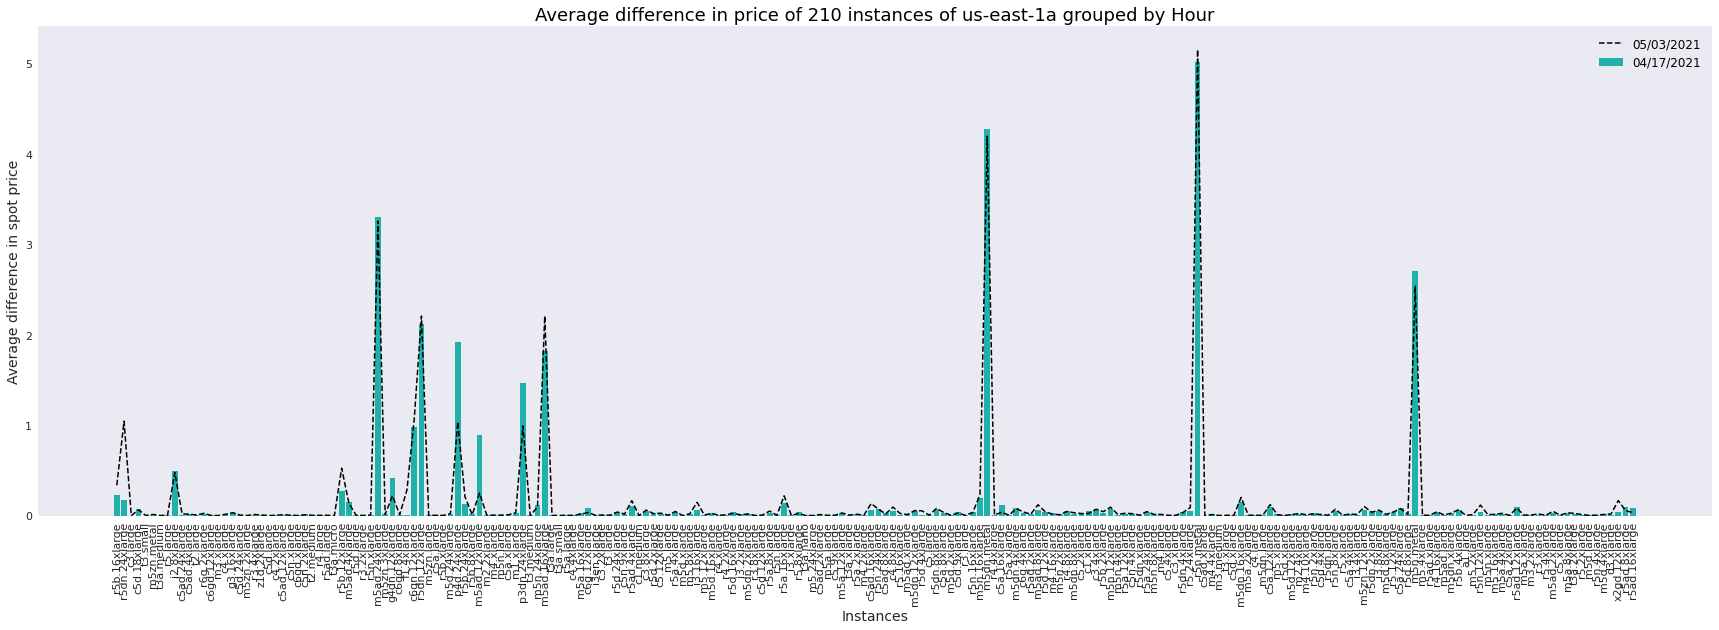

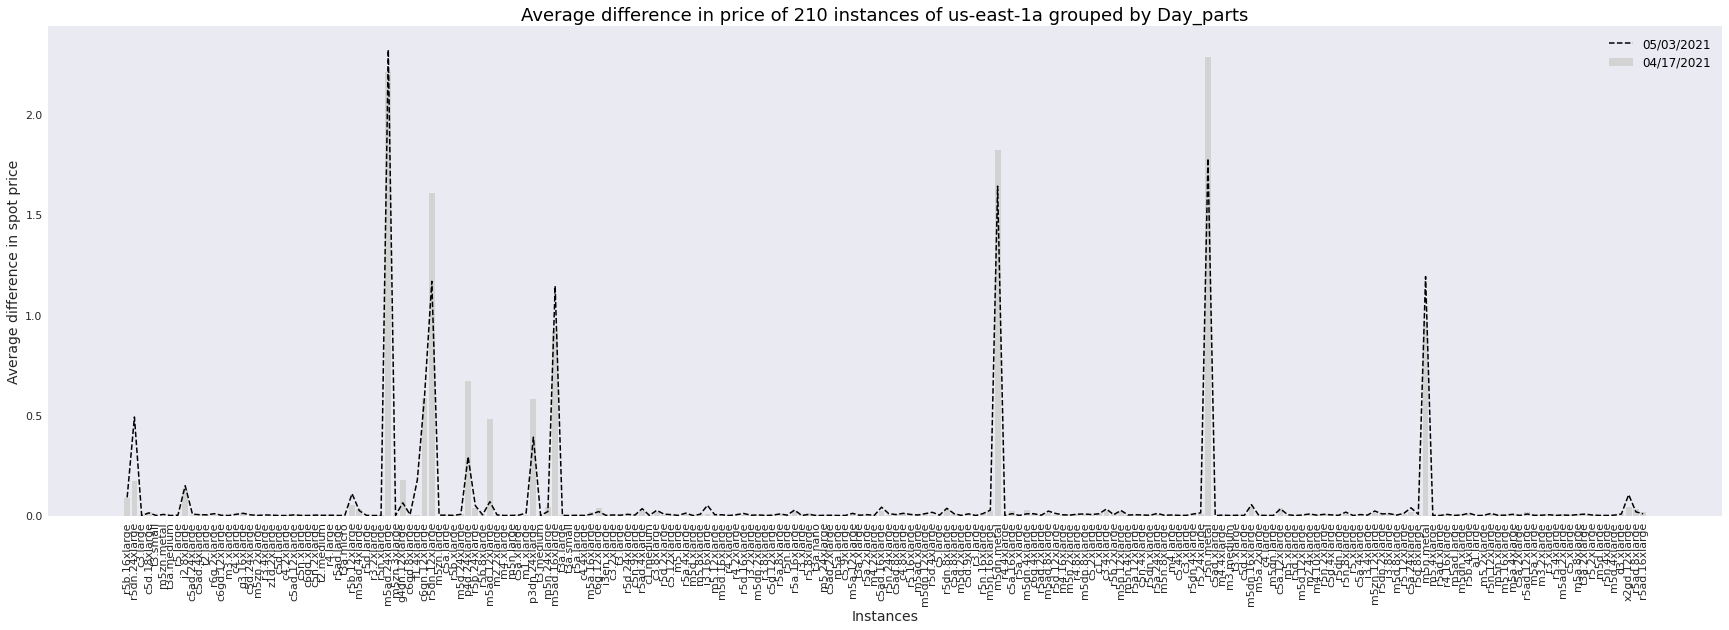

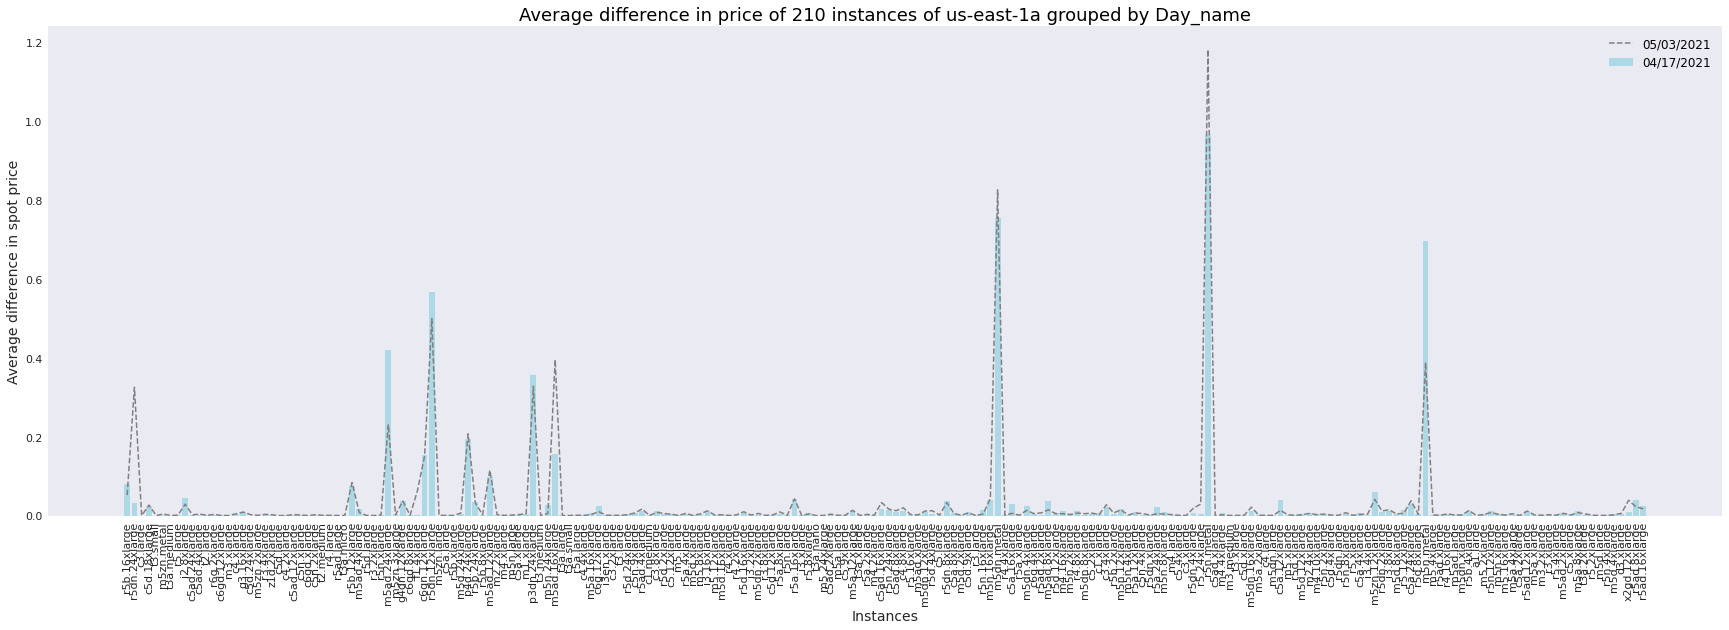

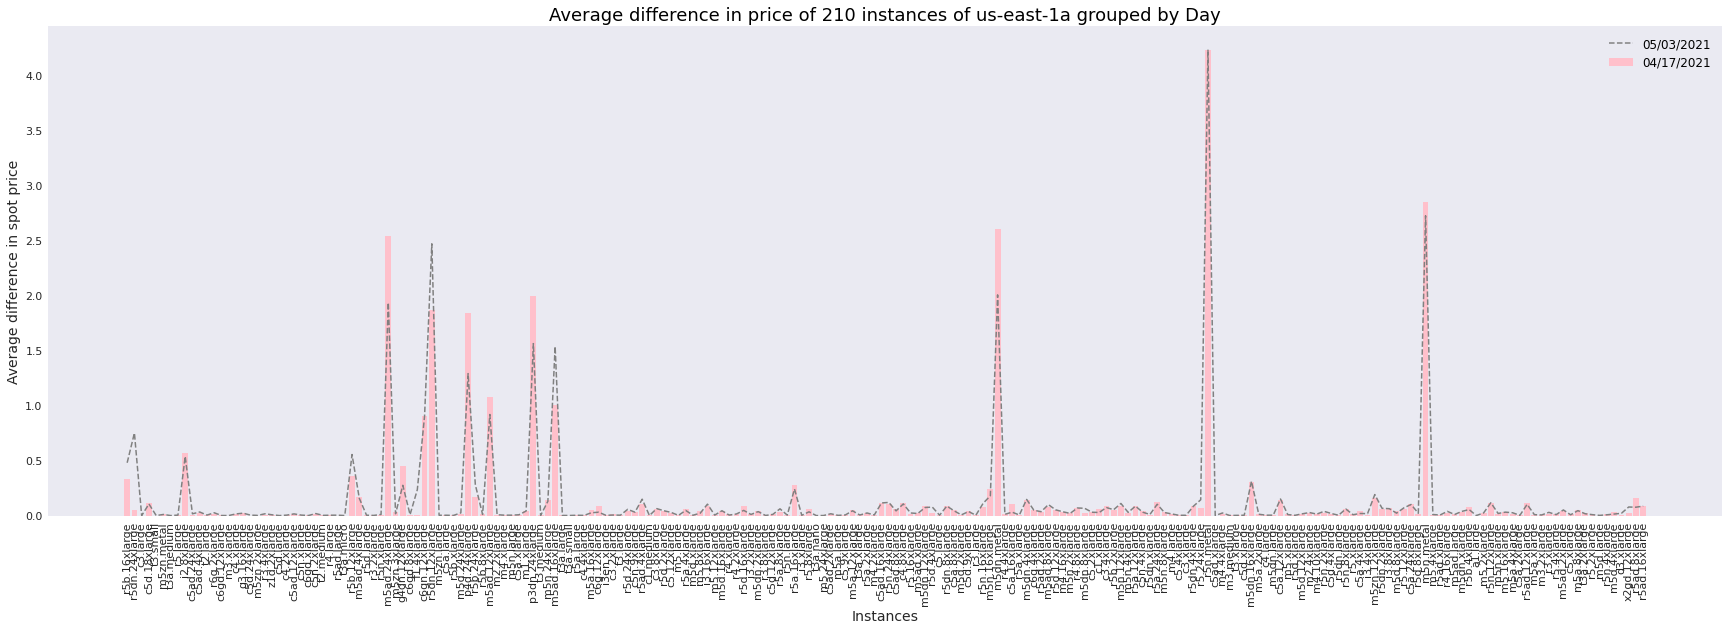

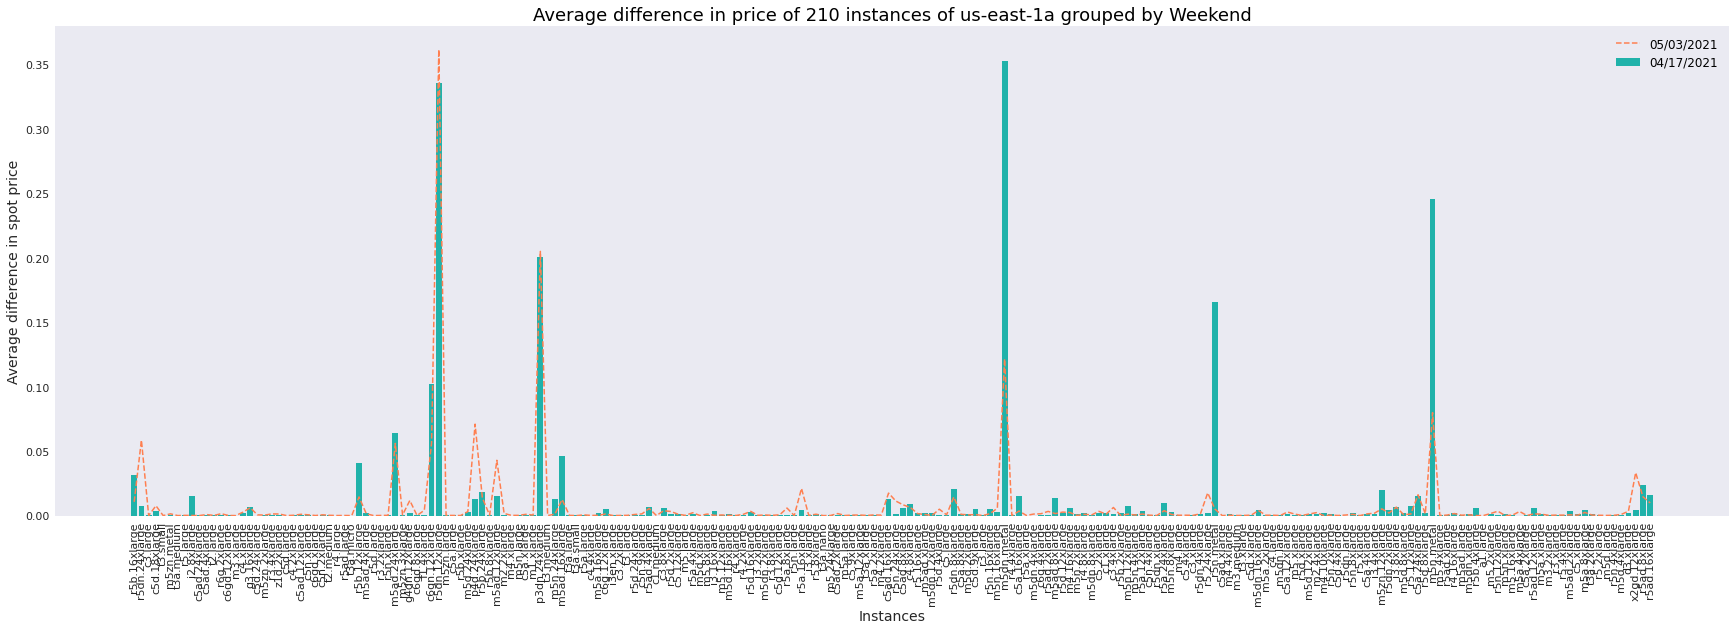

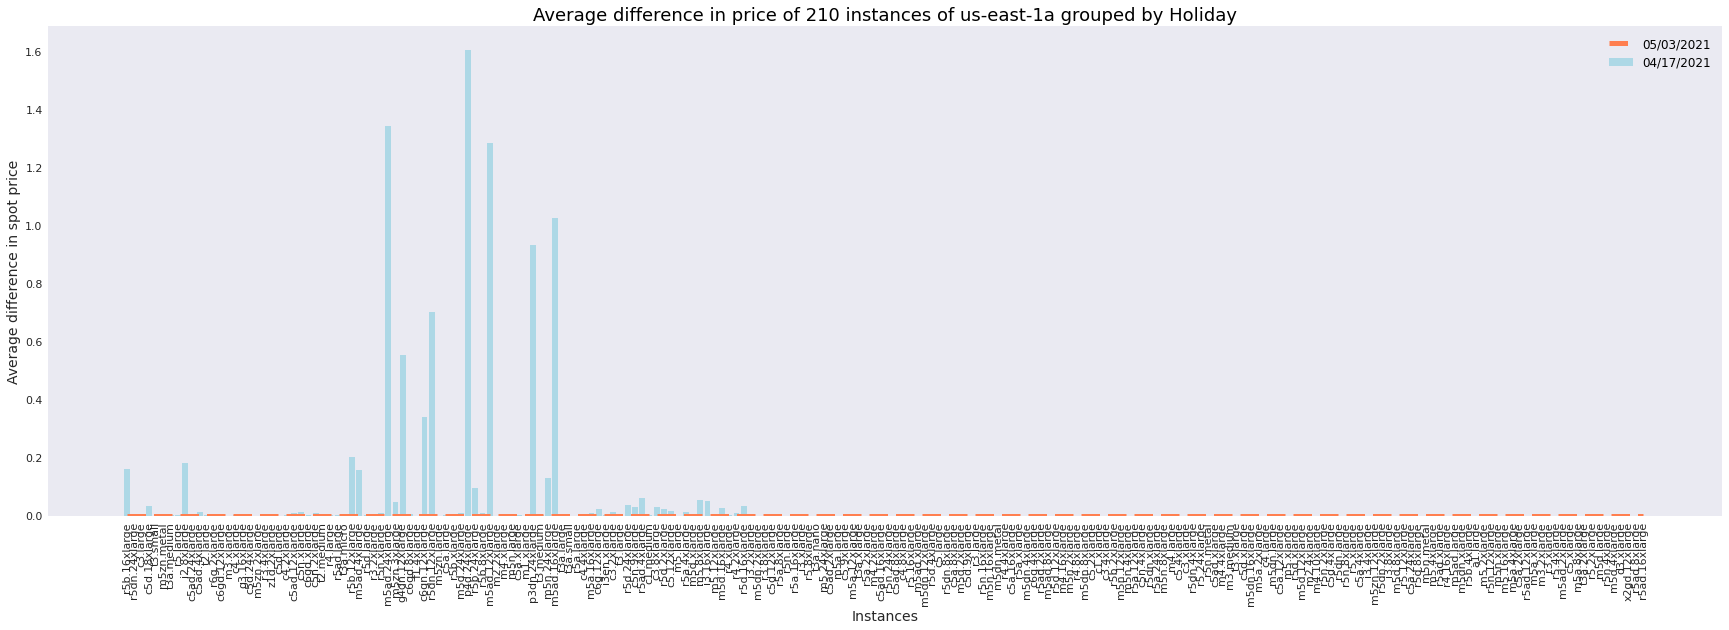

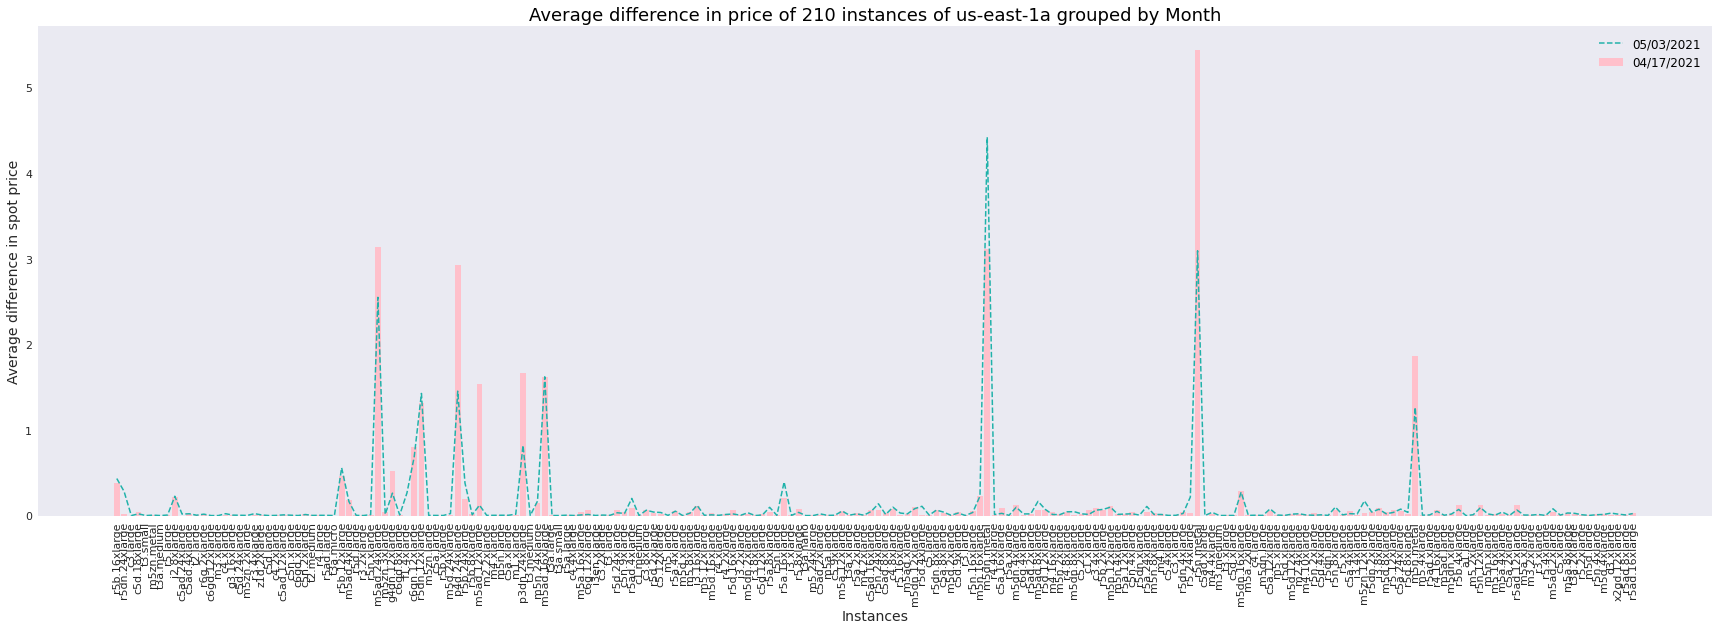

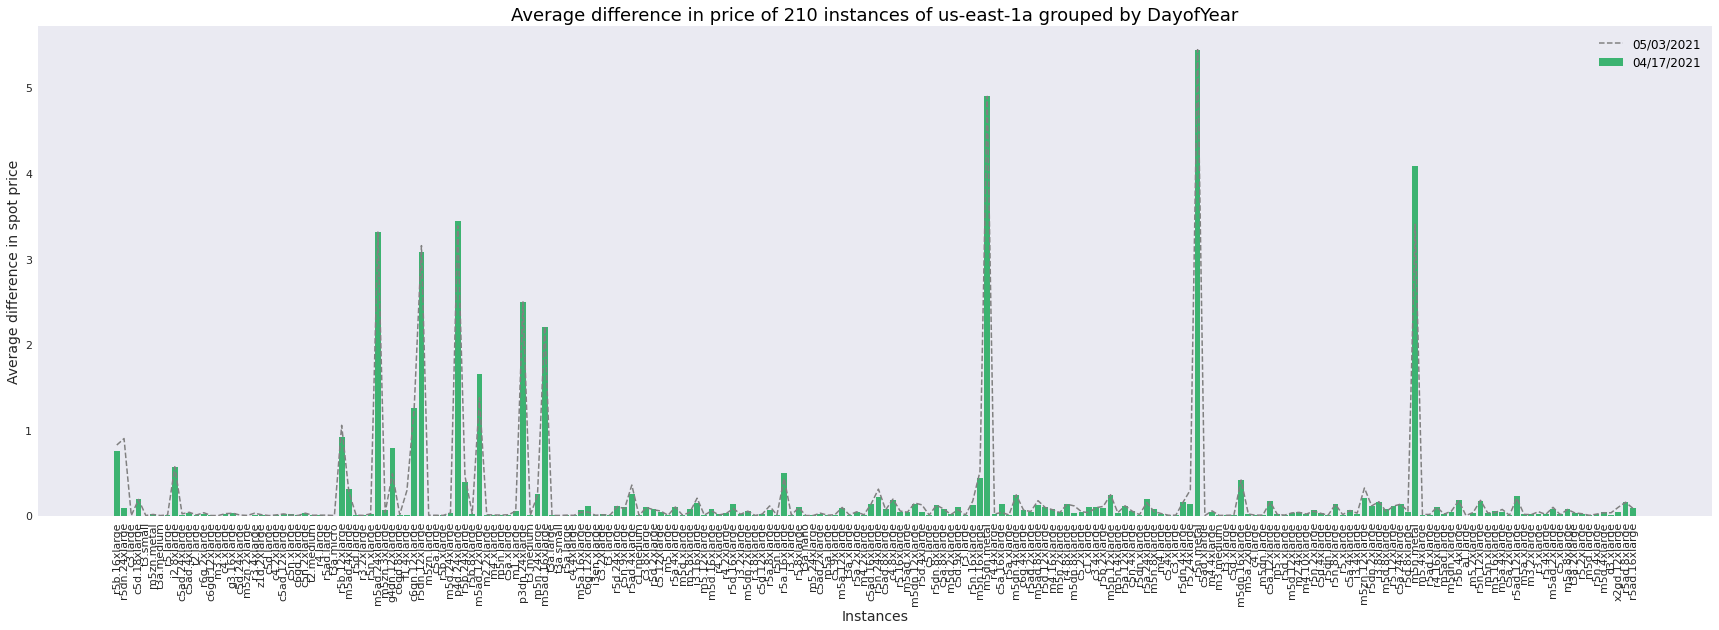

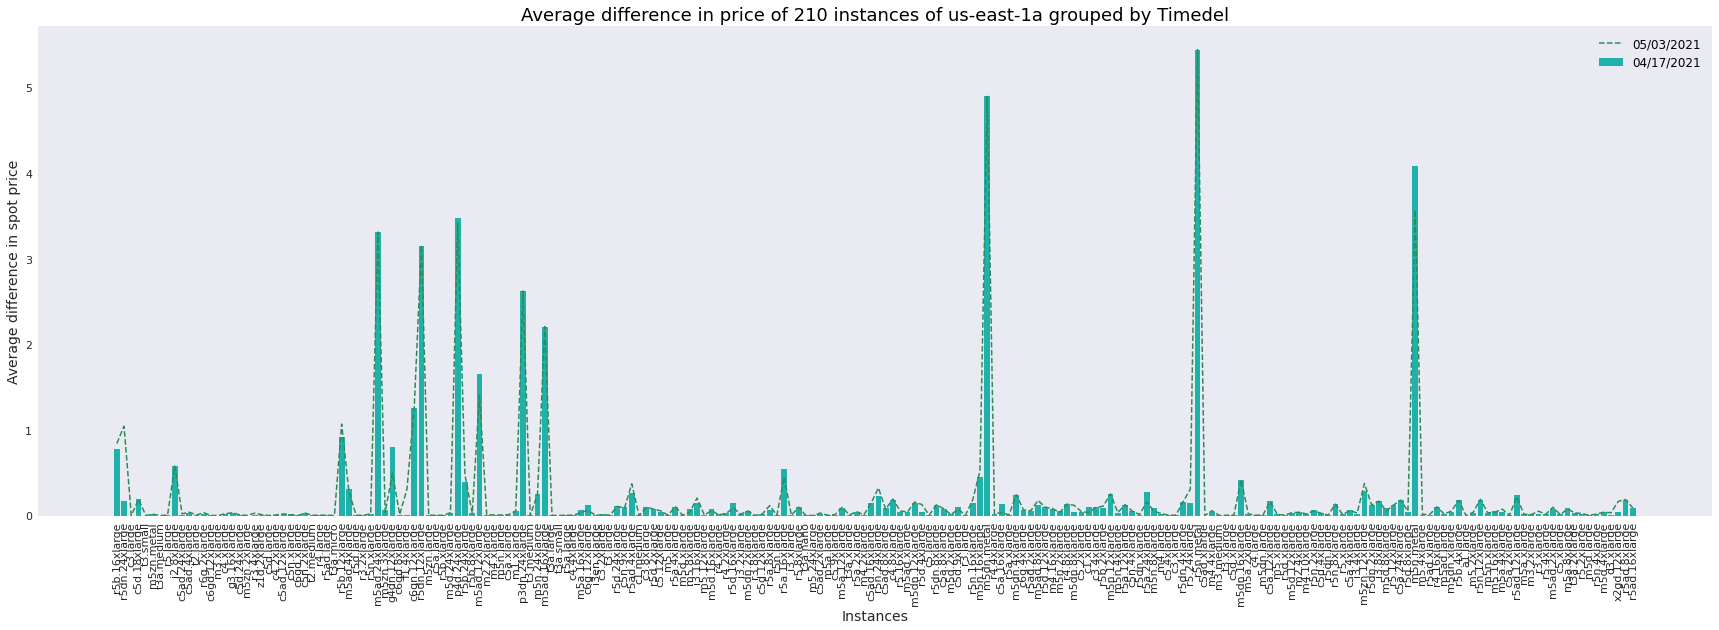

In [24]:
plot_mean_difference(us_east_1a1, us_east_1a2, u_east_1a_var)

### us-east-1b

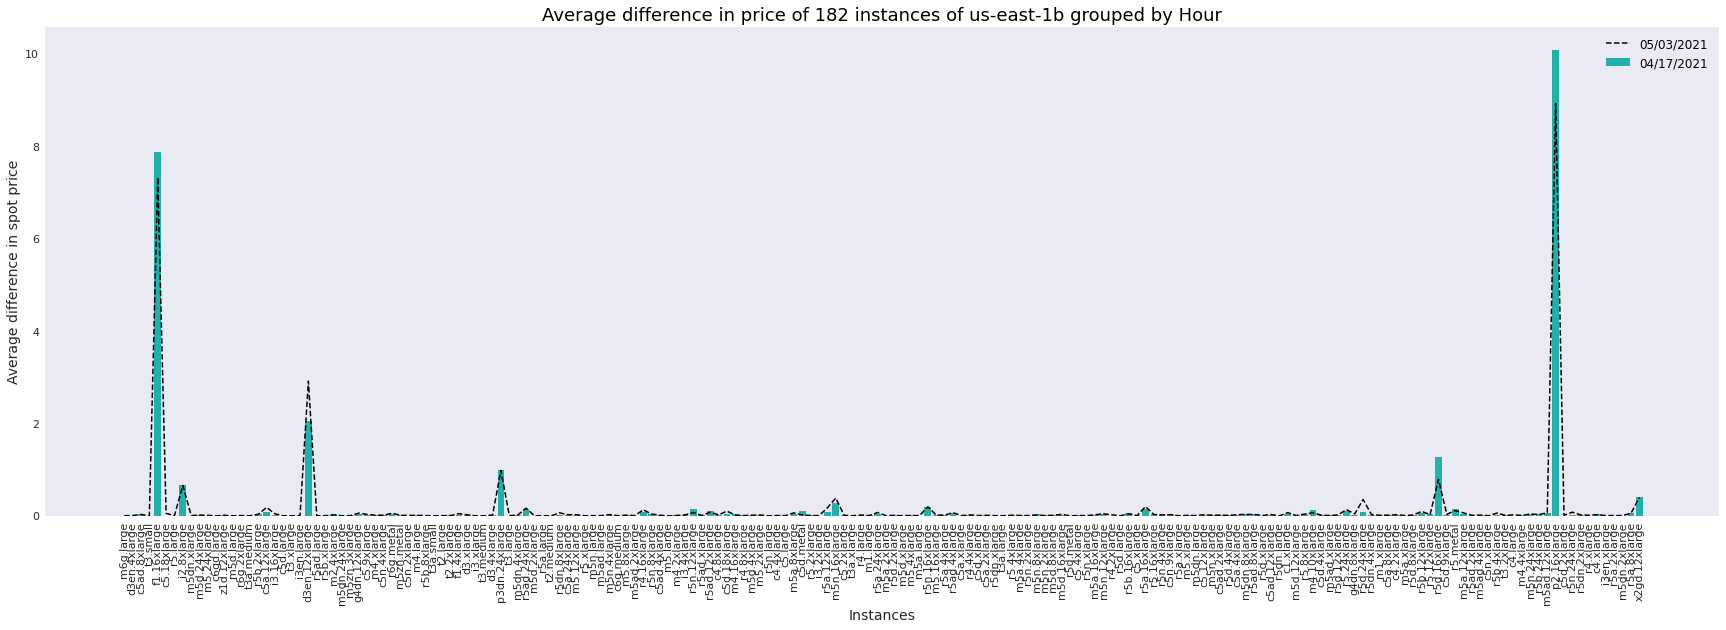

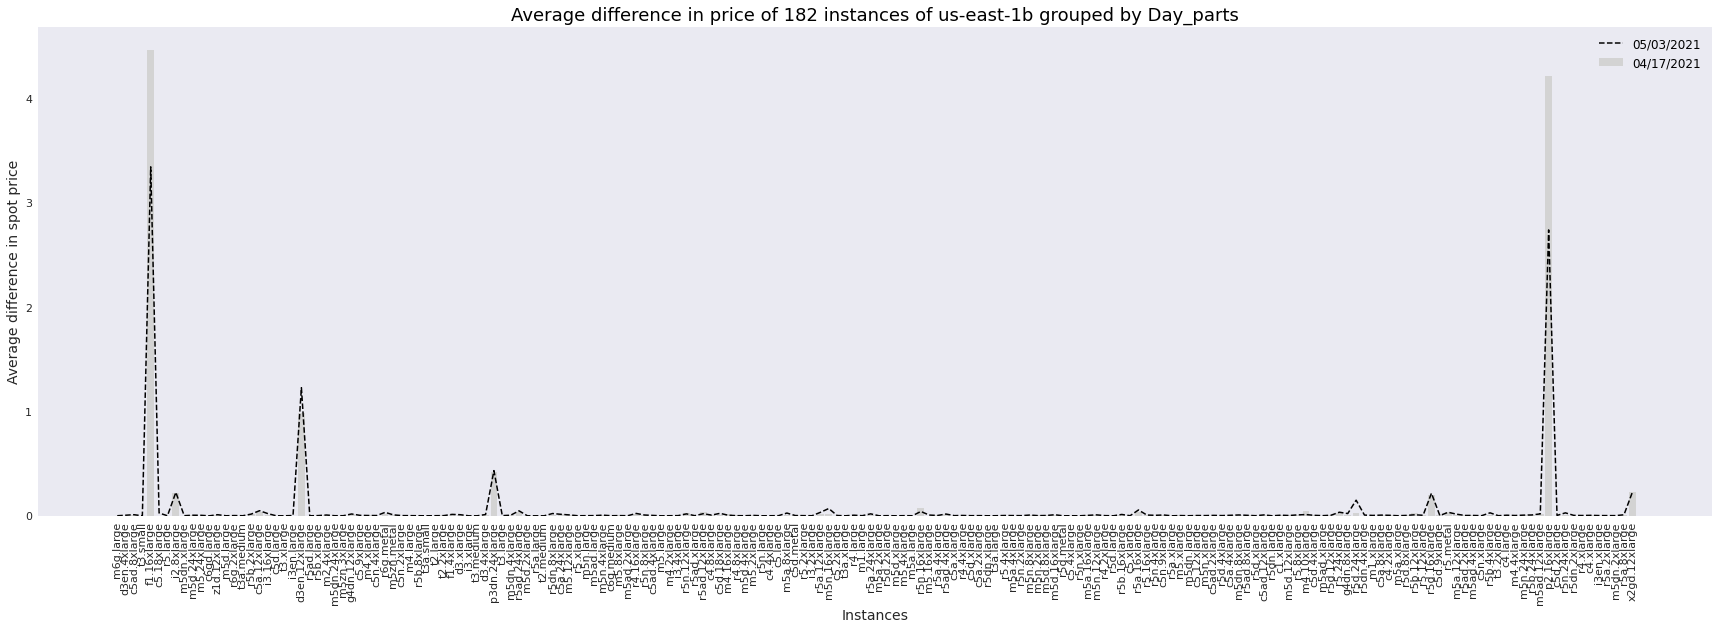

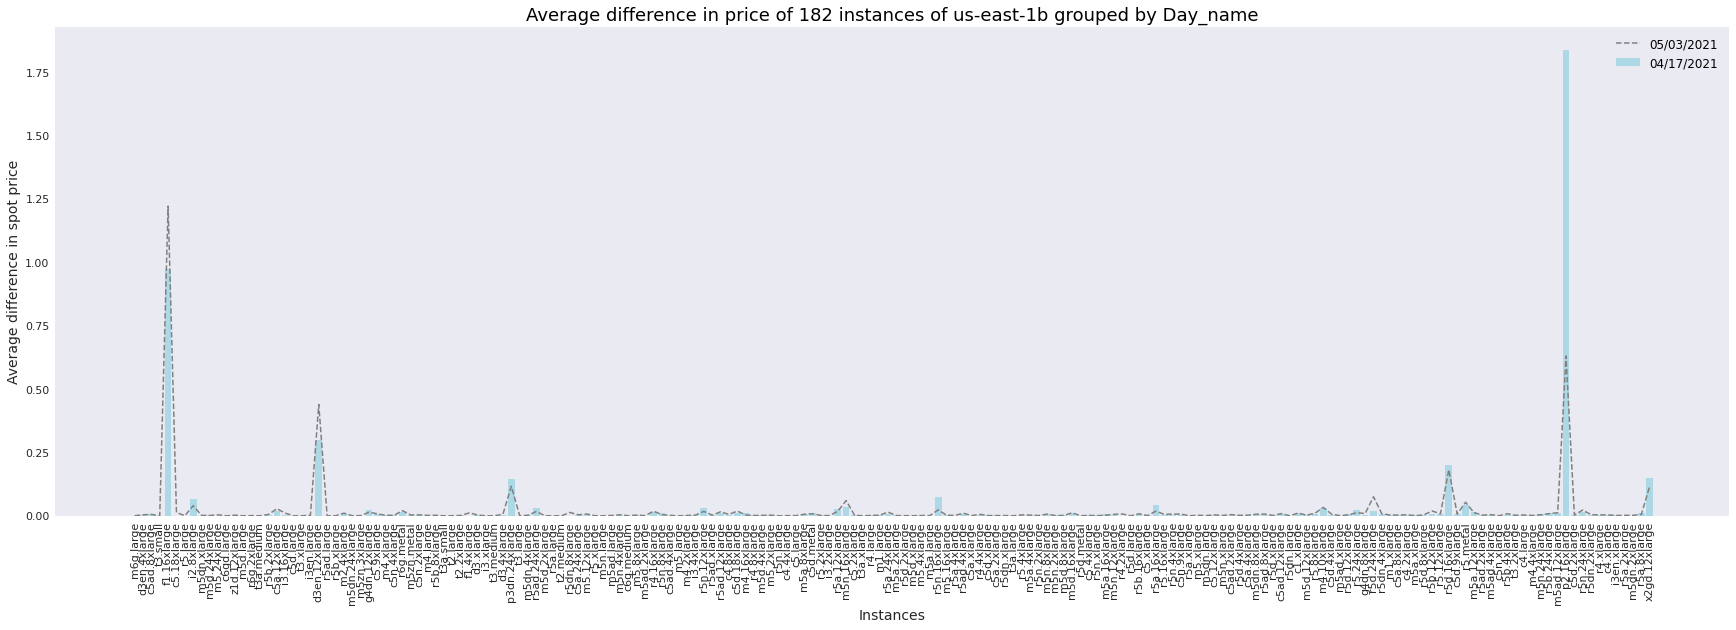

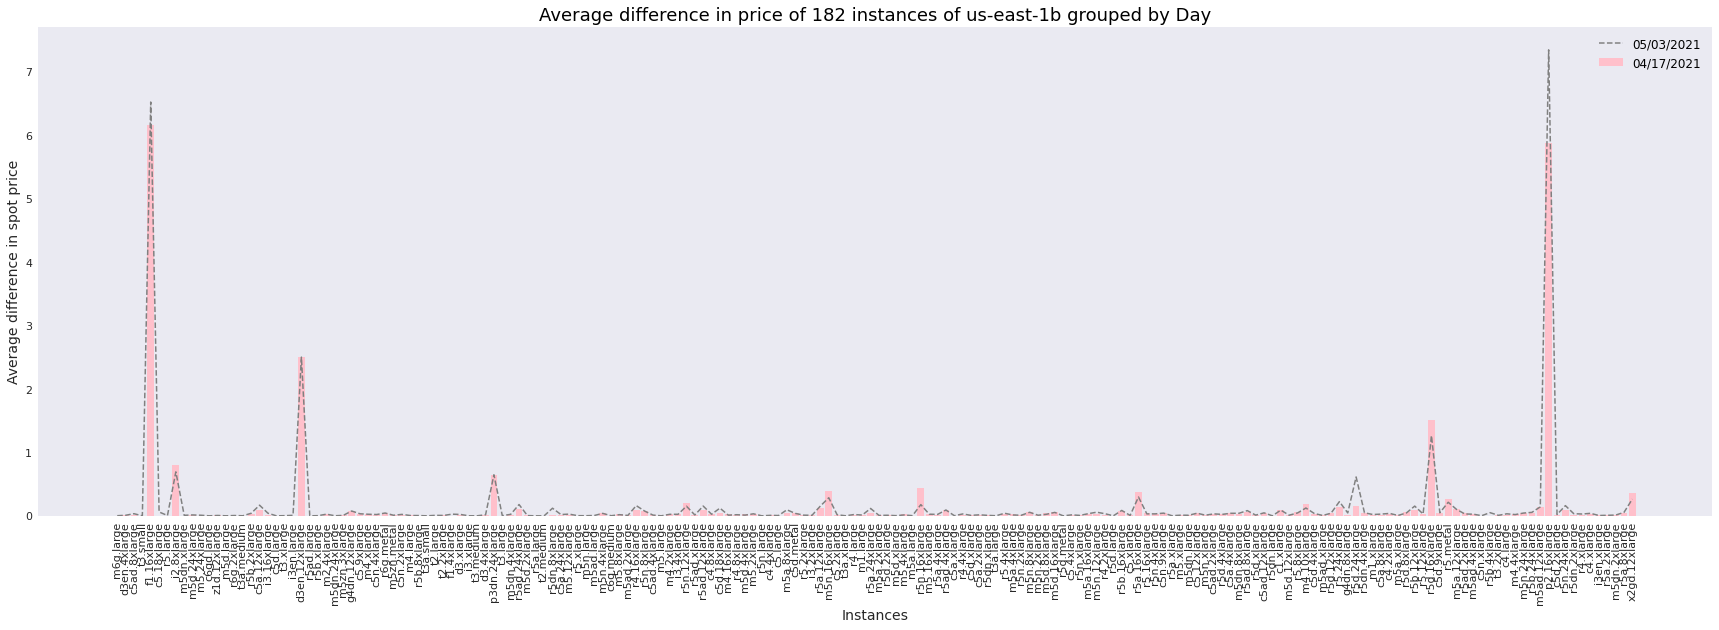

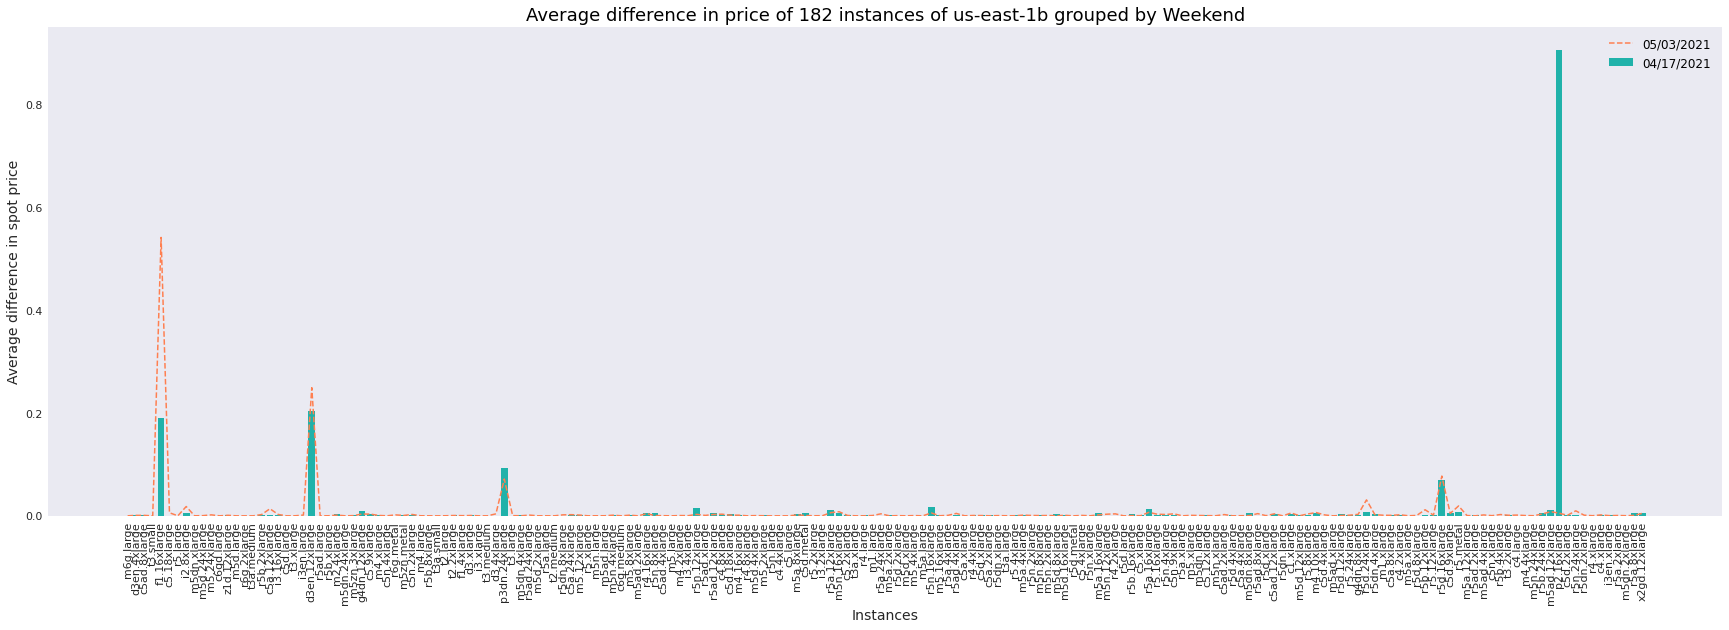

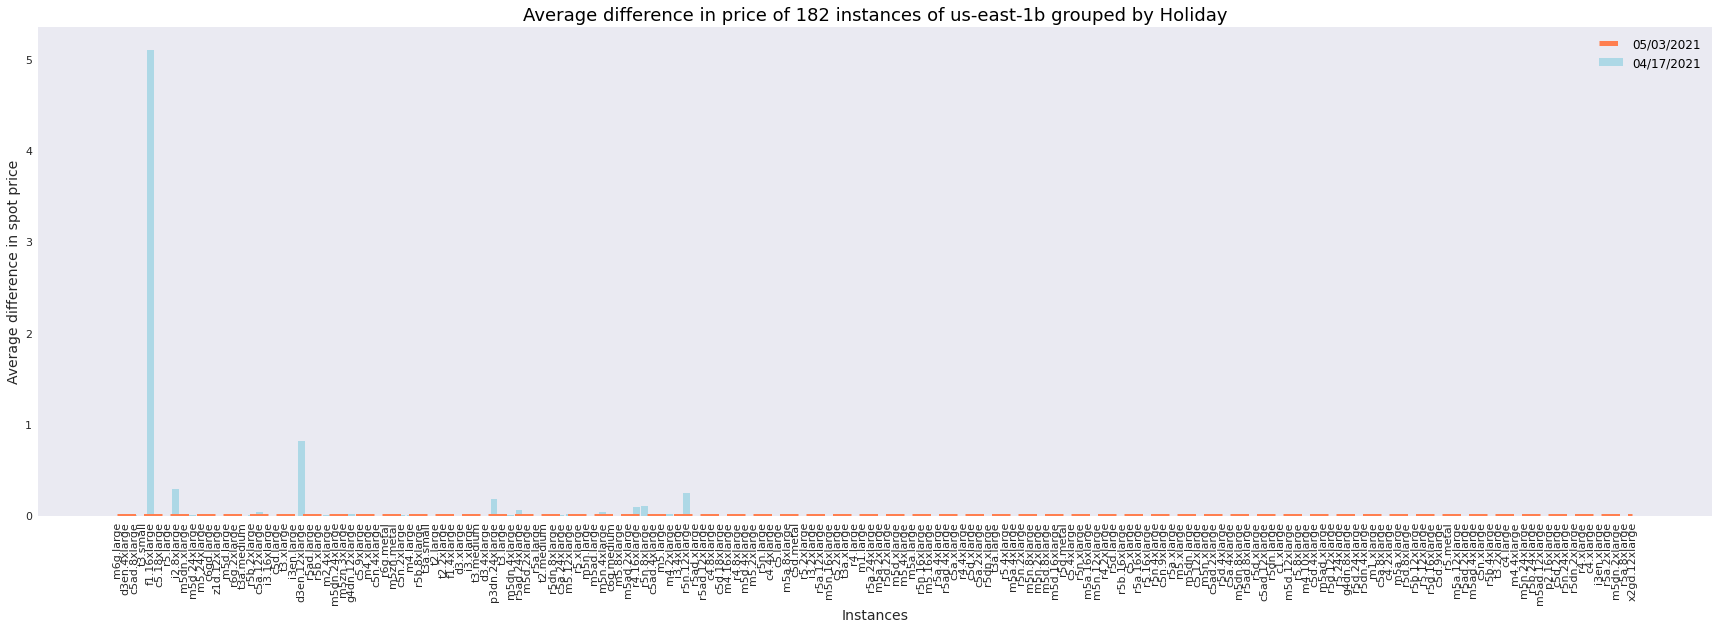

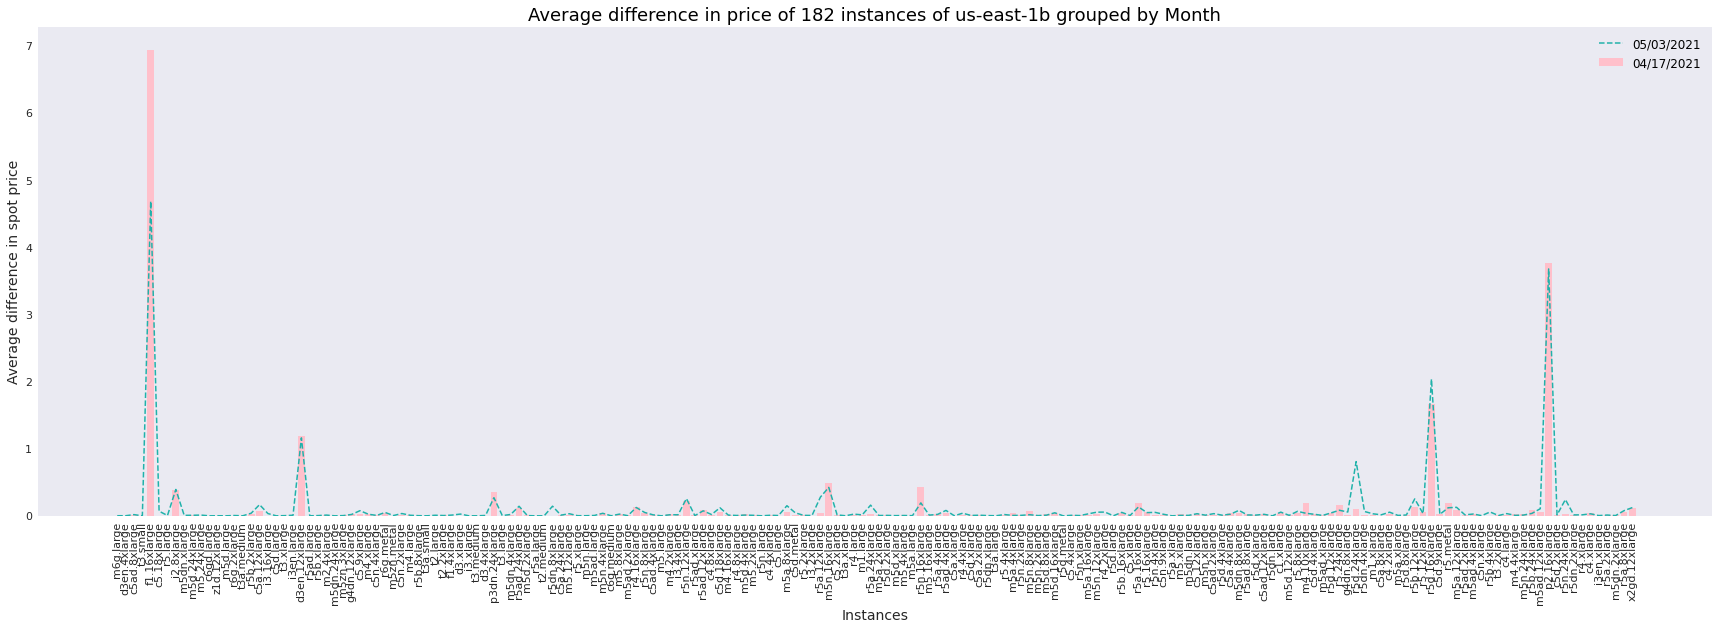

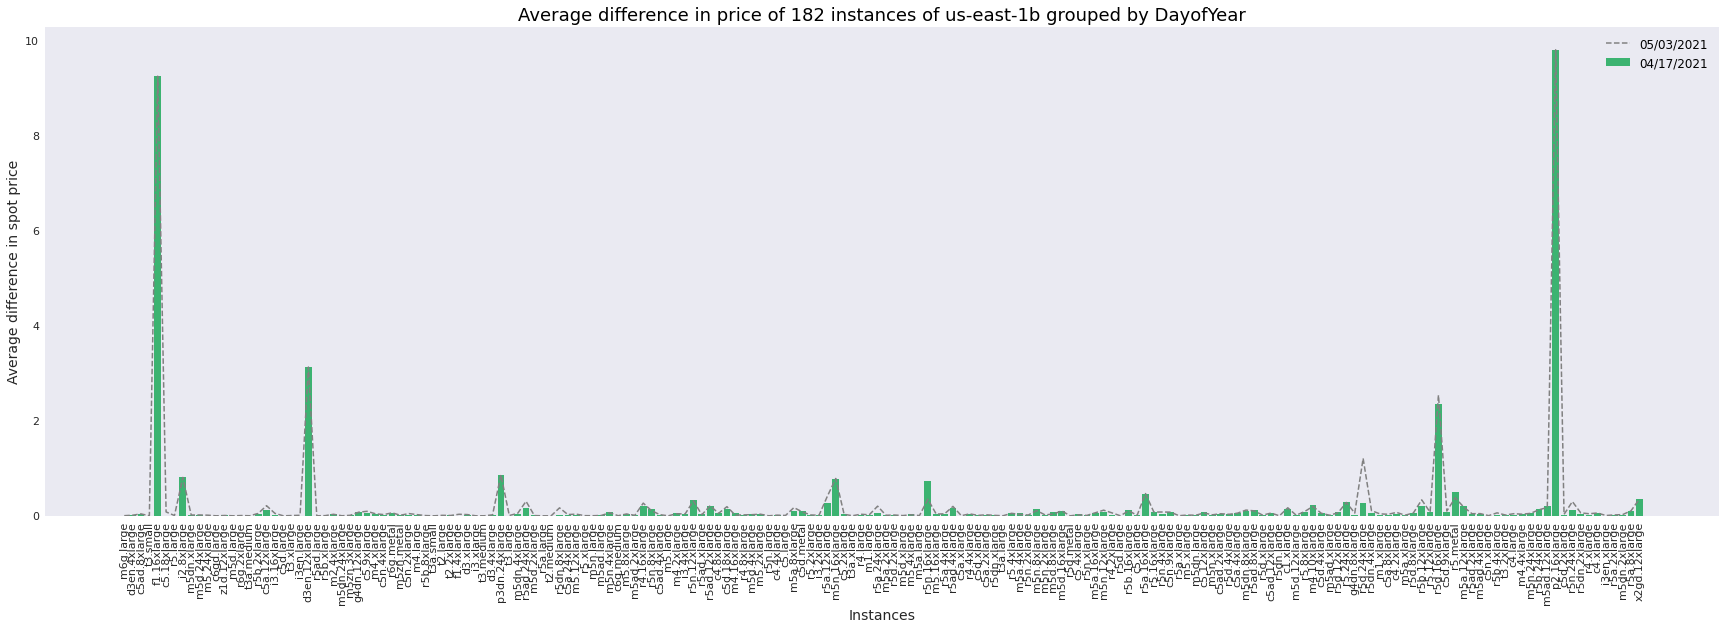

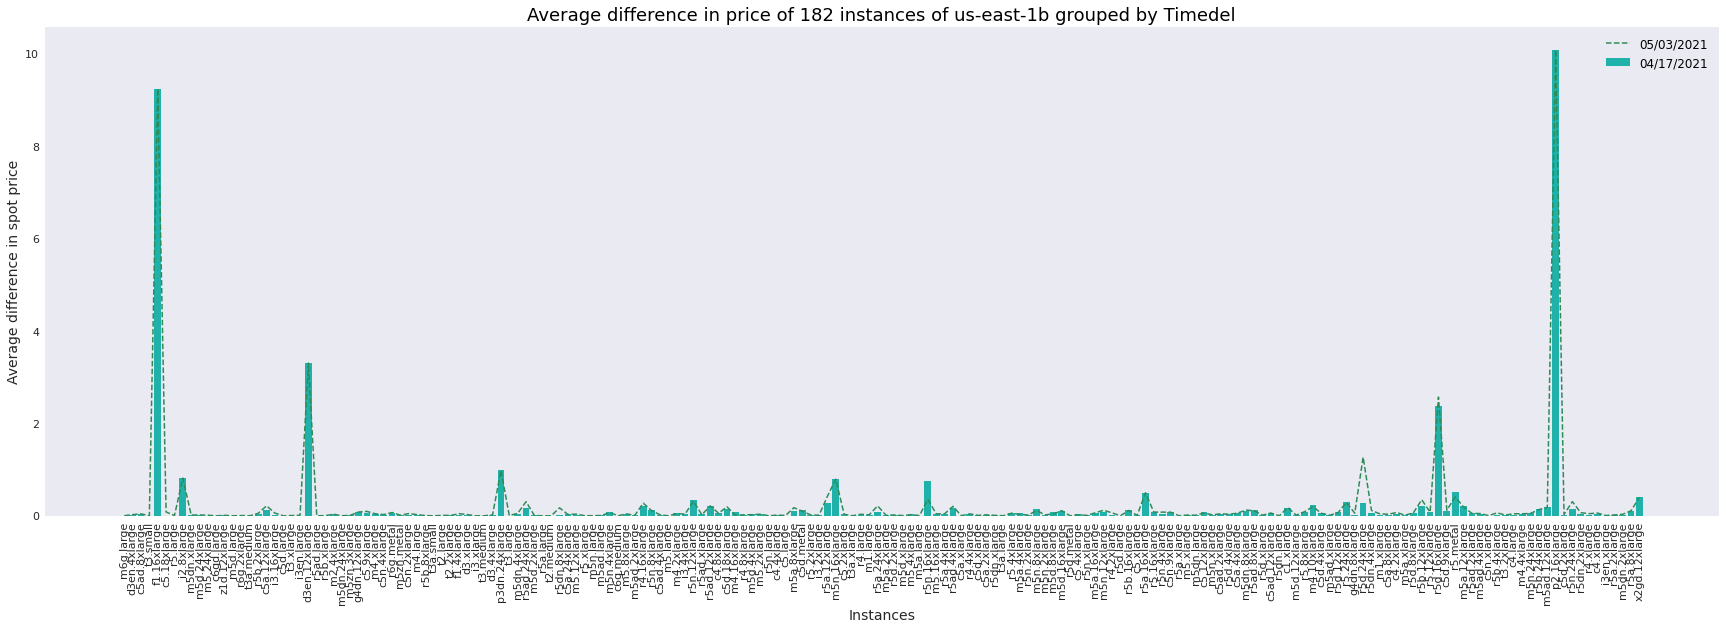

In [25]:
plot_mean_difference(us_east_1b1, us_east_1b2, u_east_1b_var)

### us-east-1d

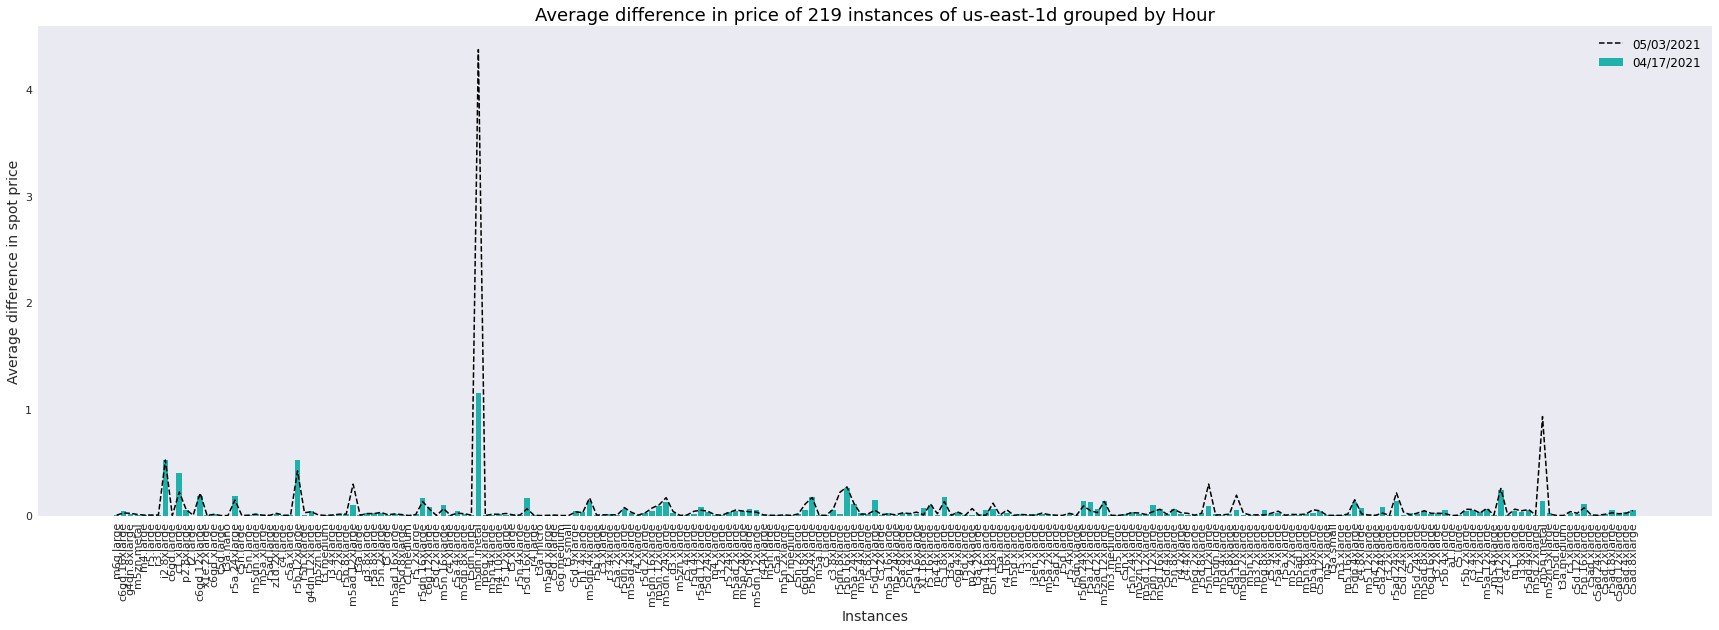

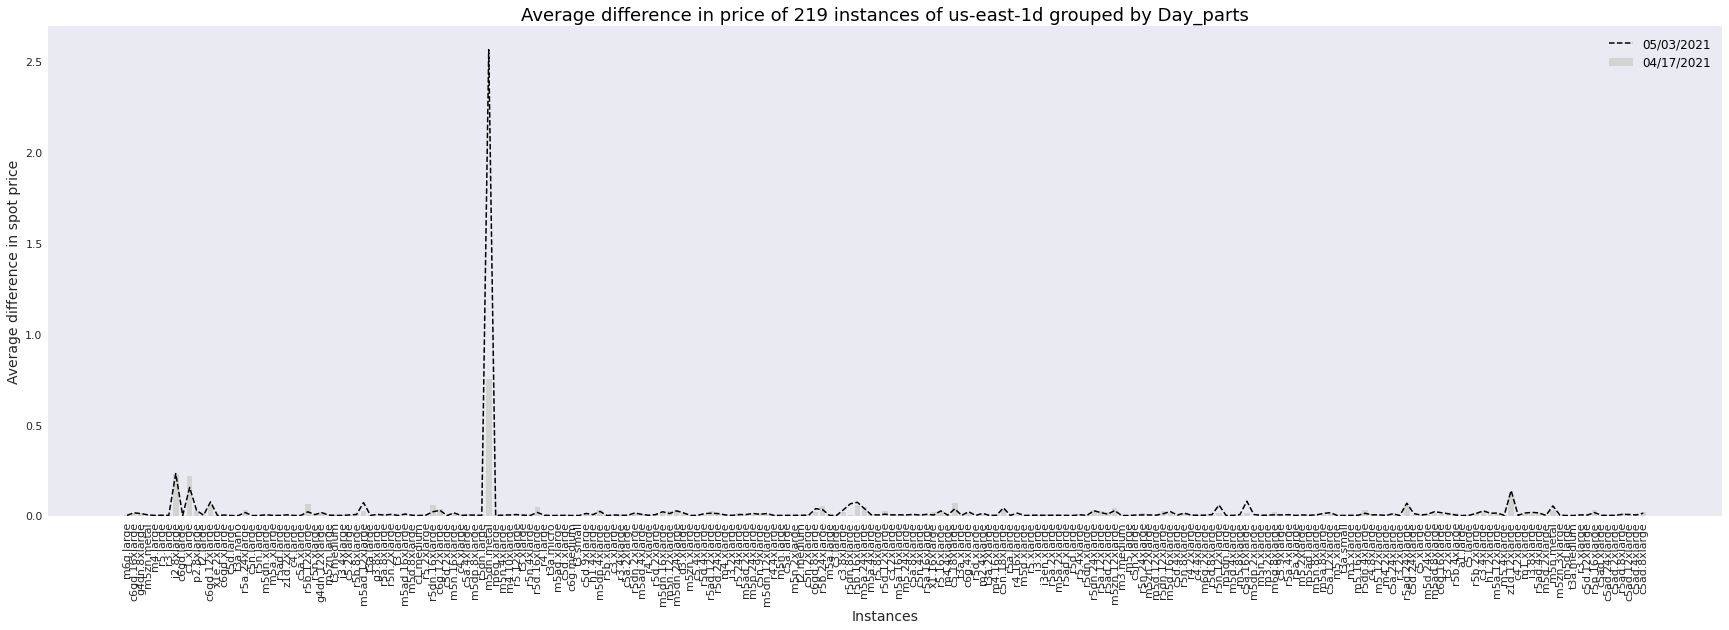

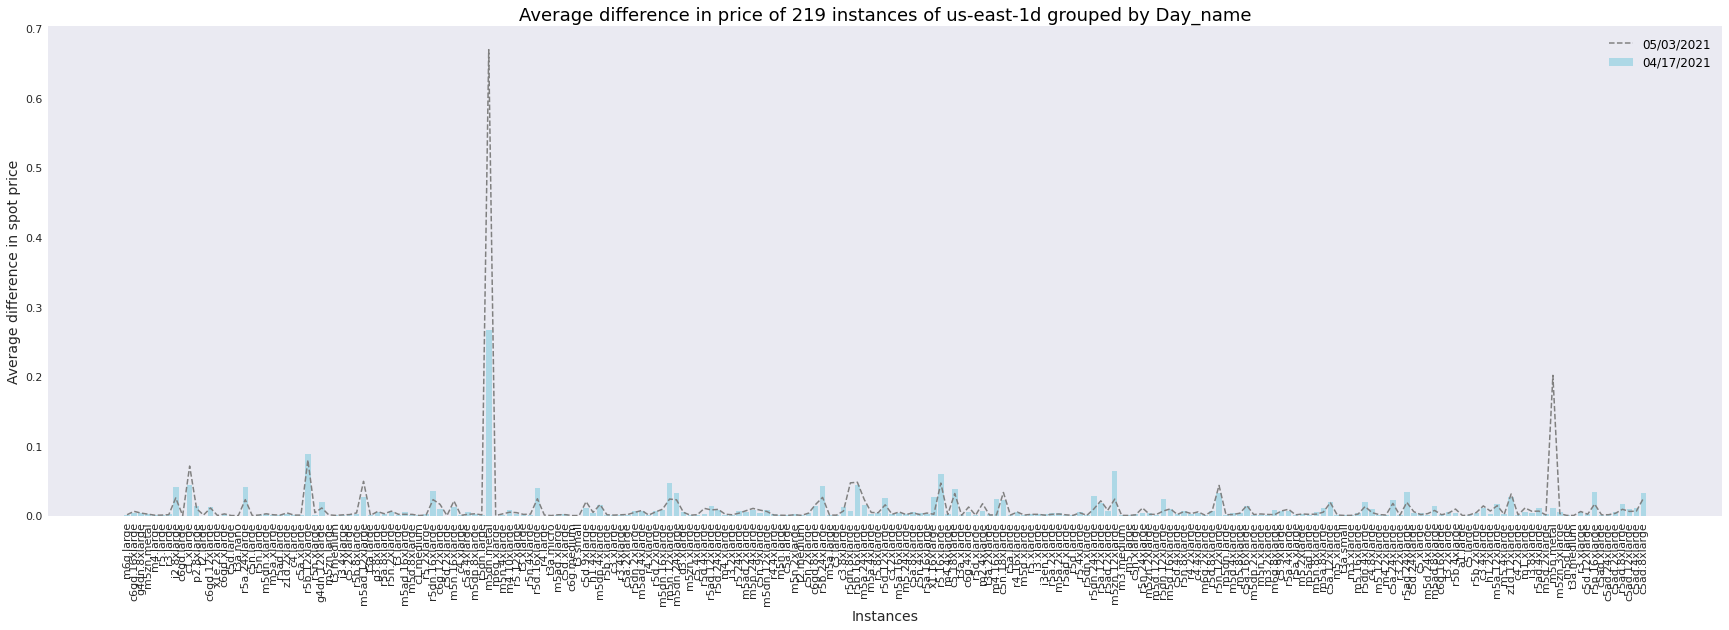

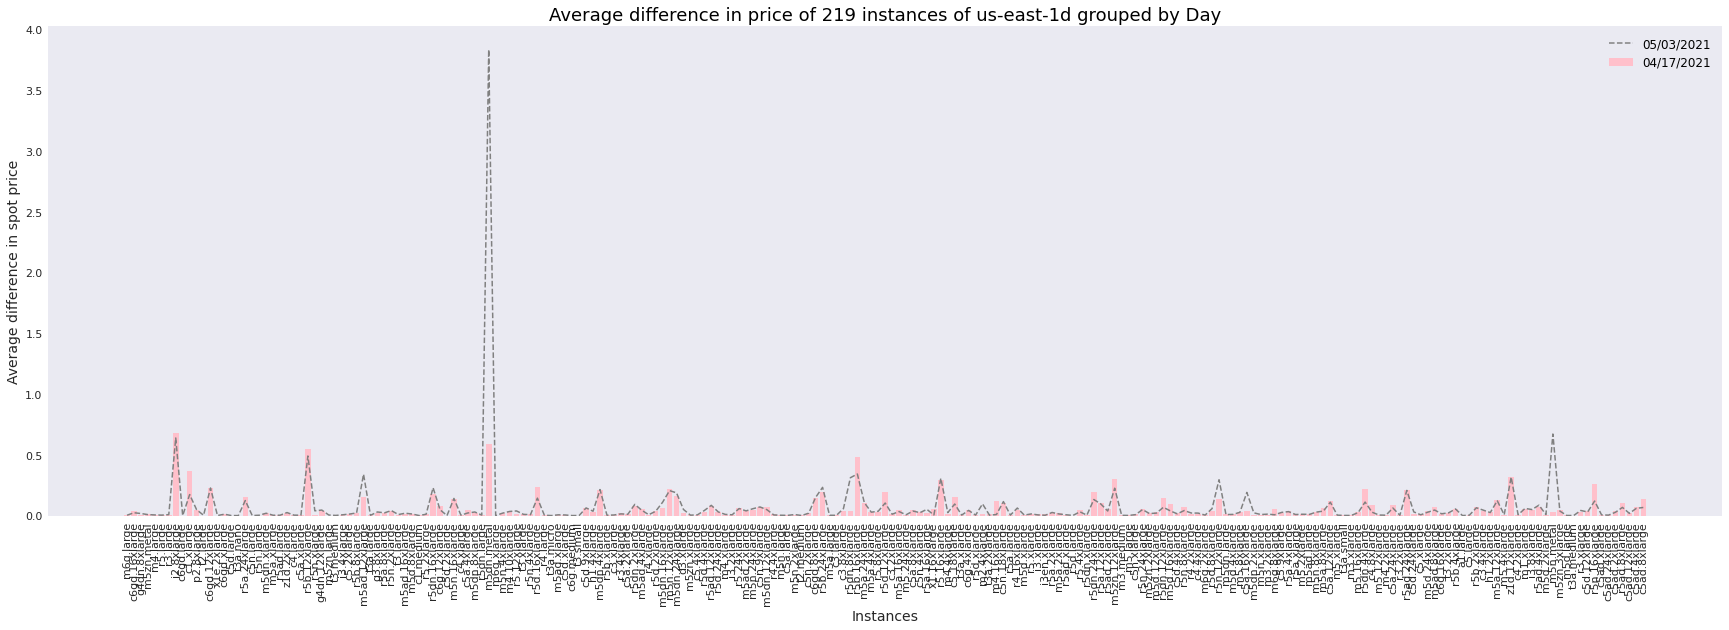

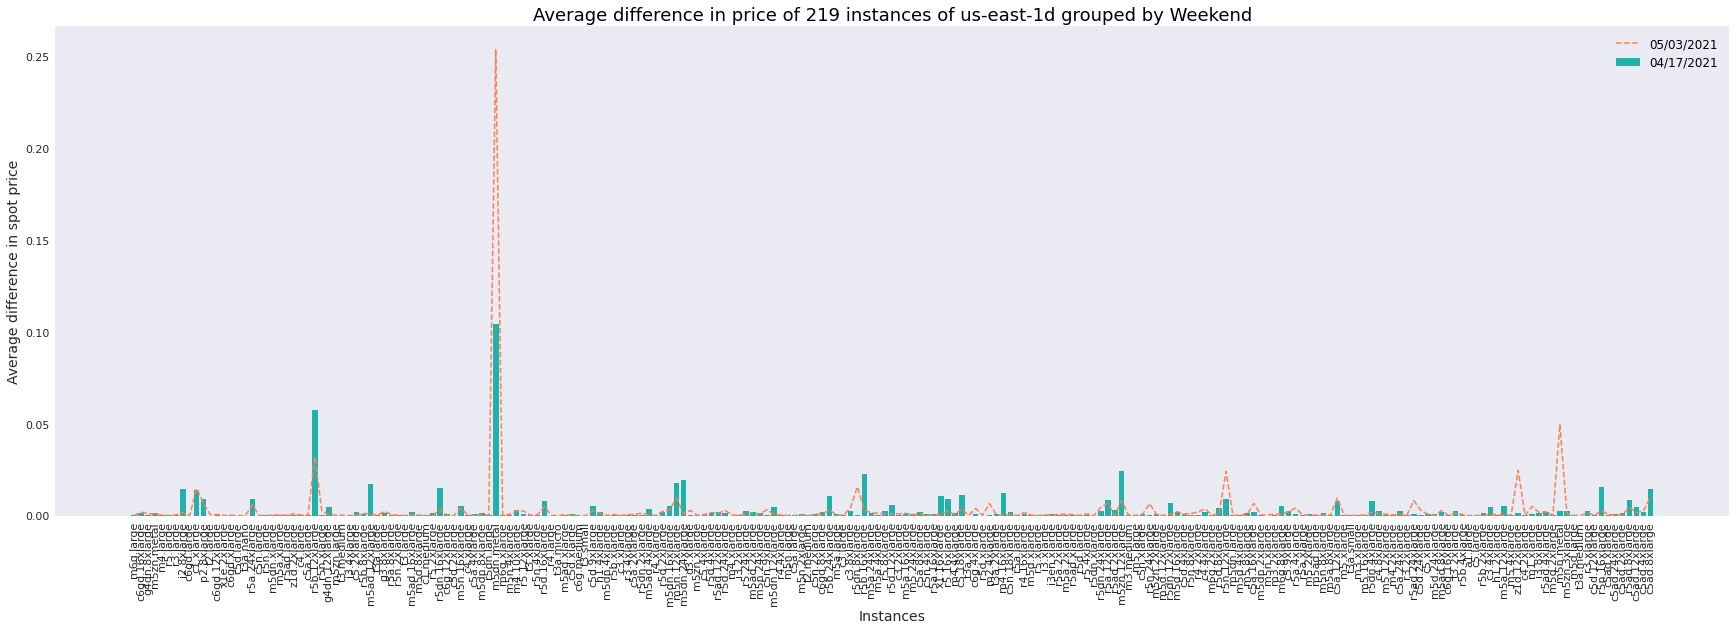

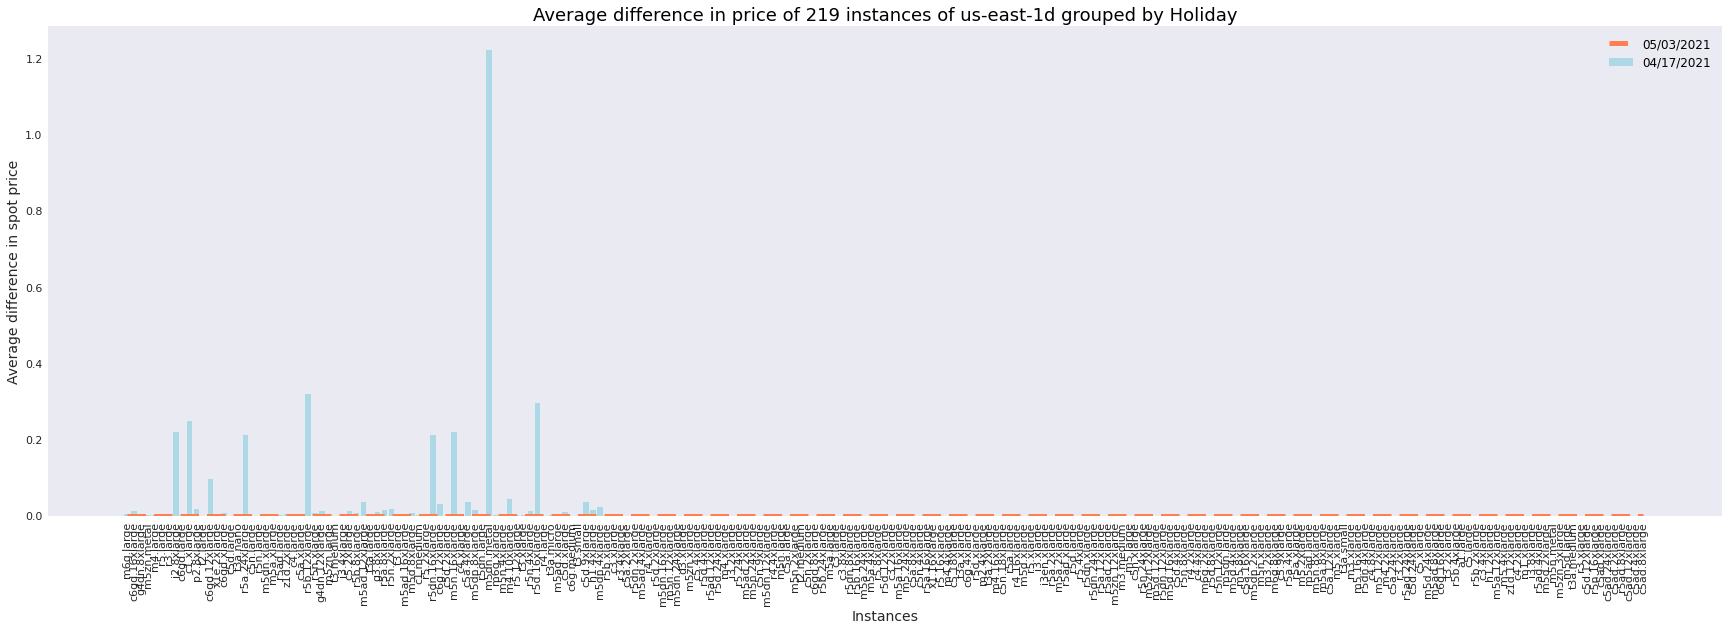

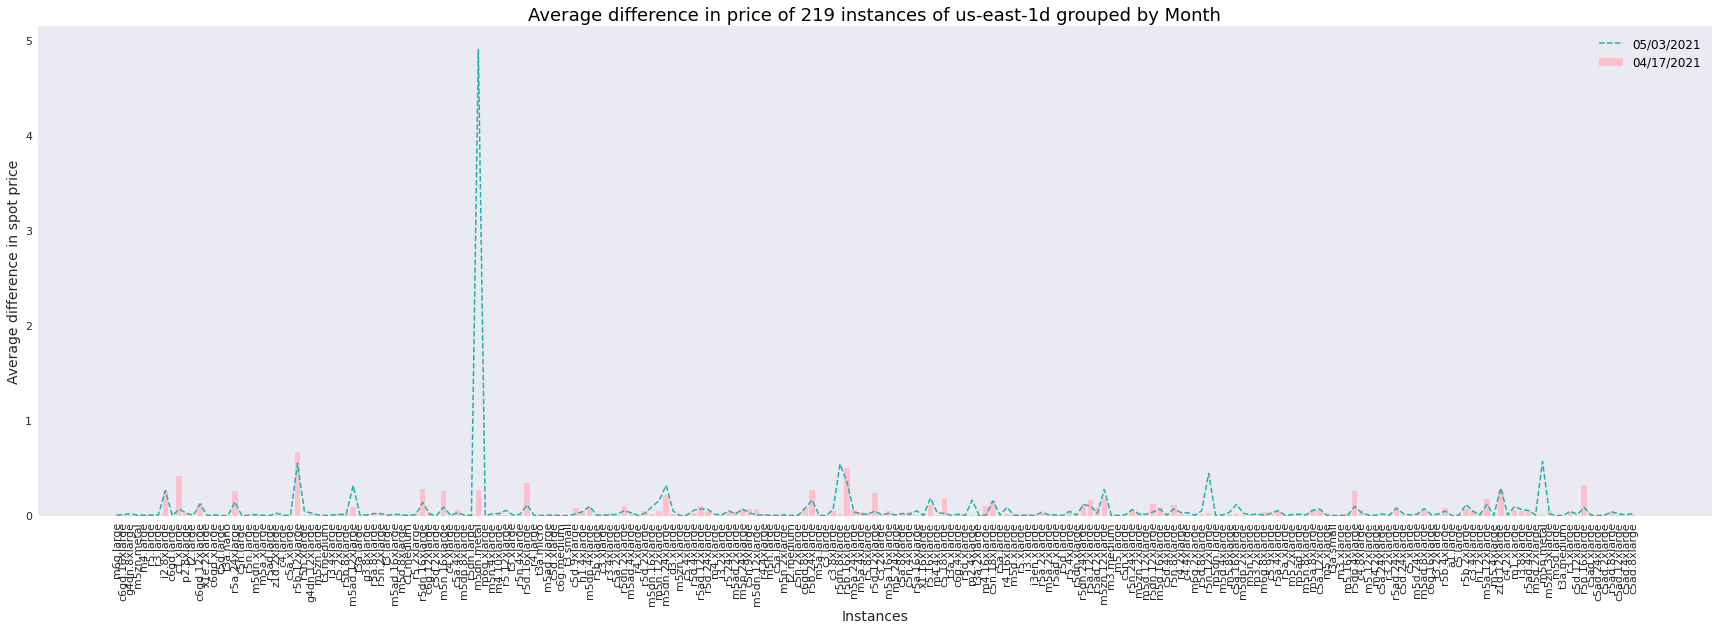

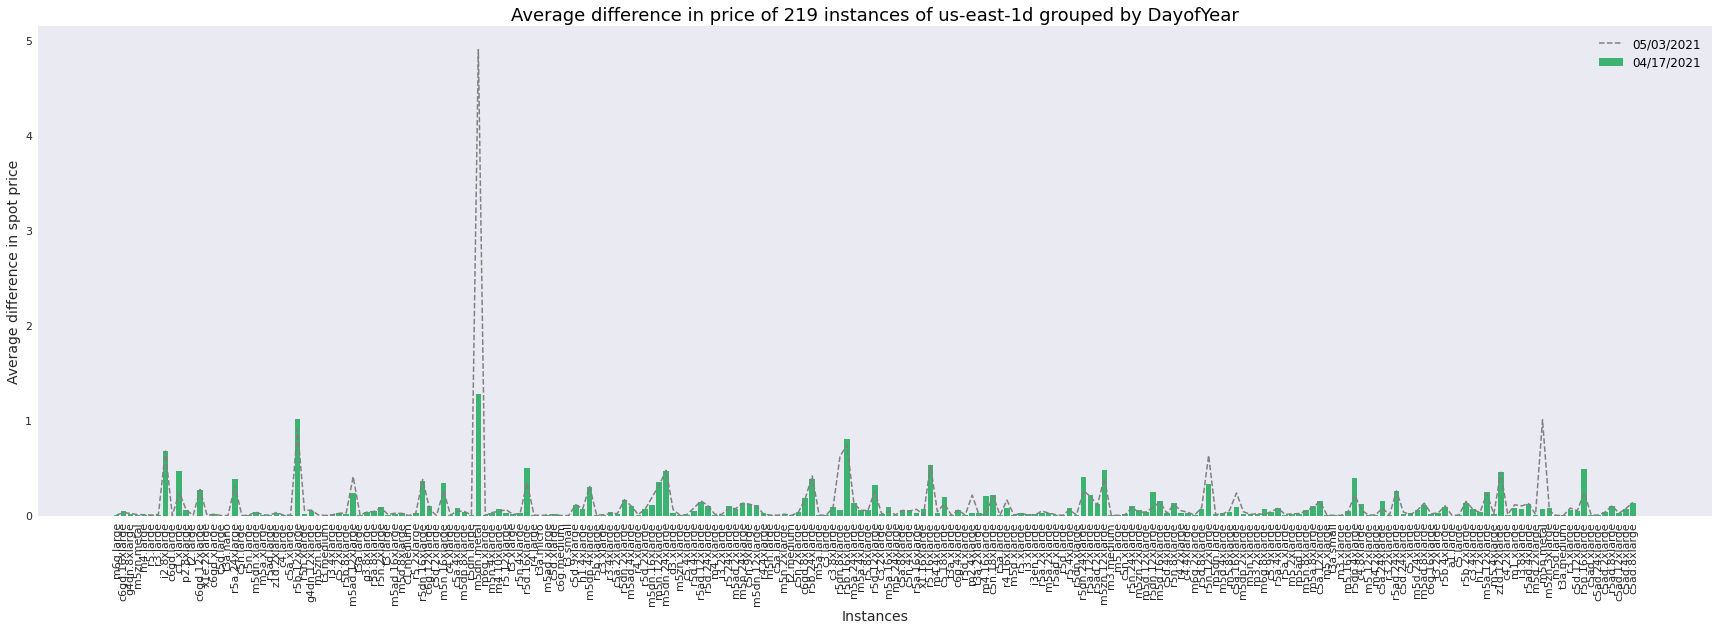

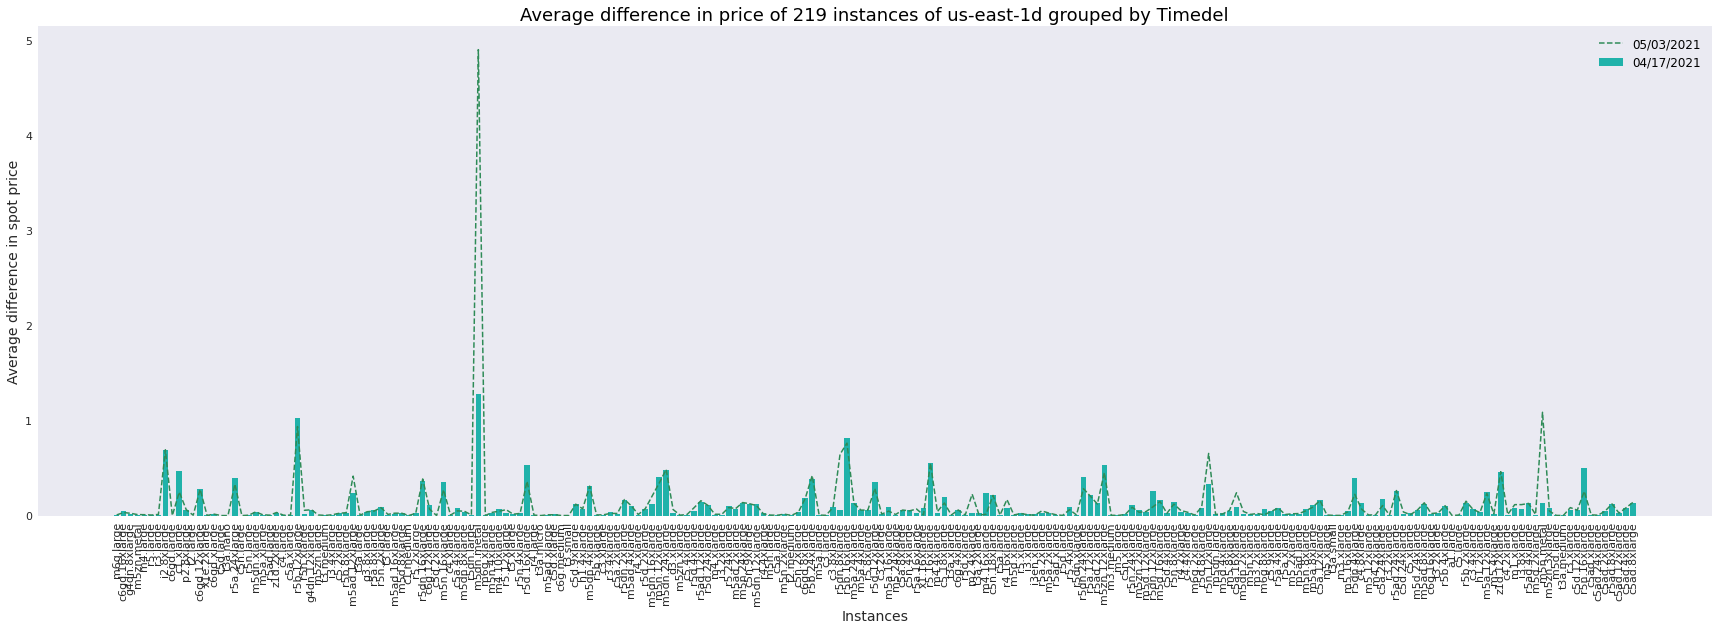

In [26]:
plot_mean_difference(us_east_1d1, us_east_1d2, u_east_1d_var)

### us-east-1e

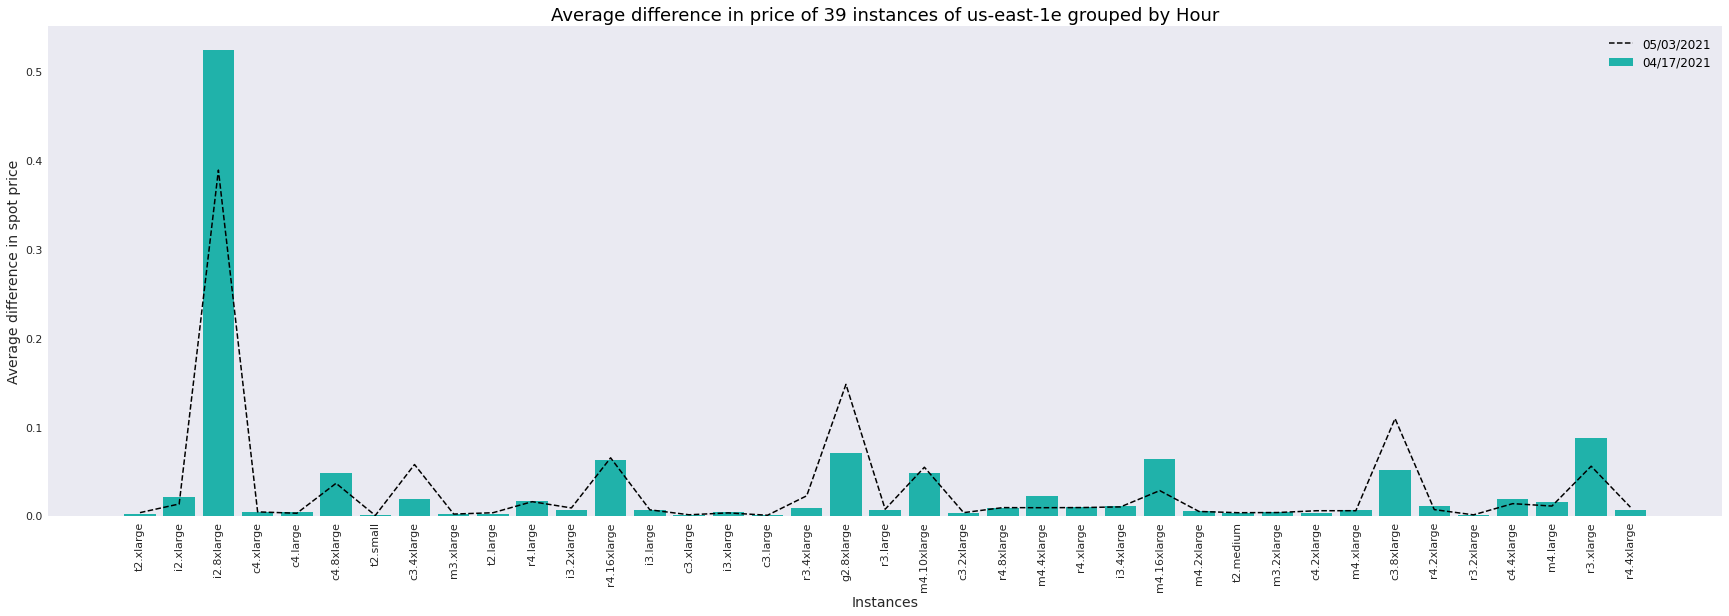

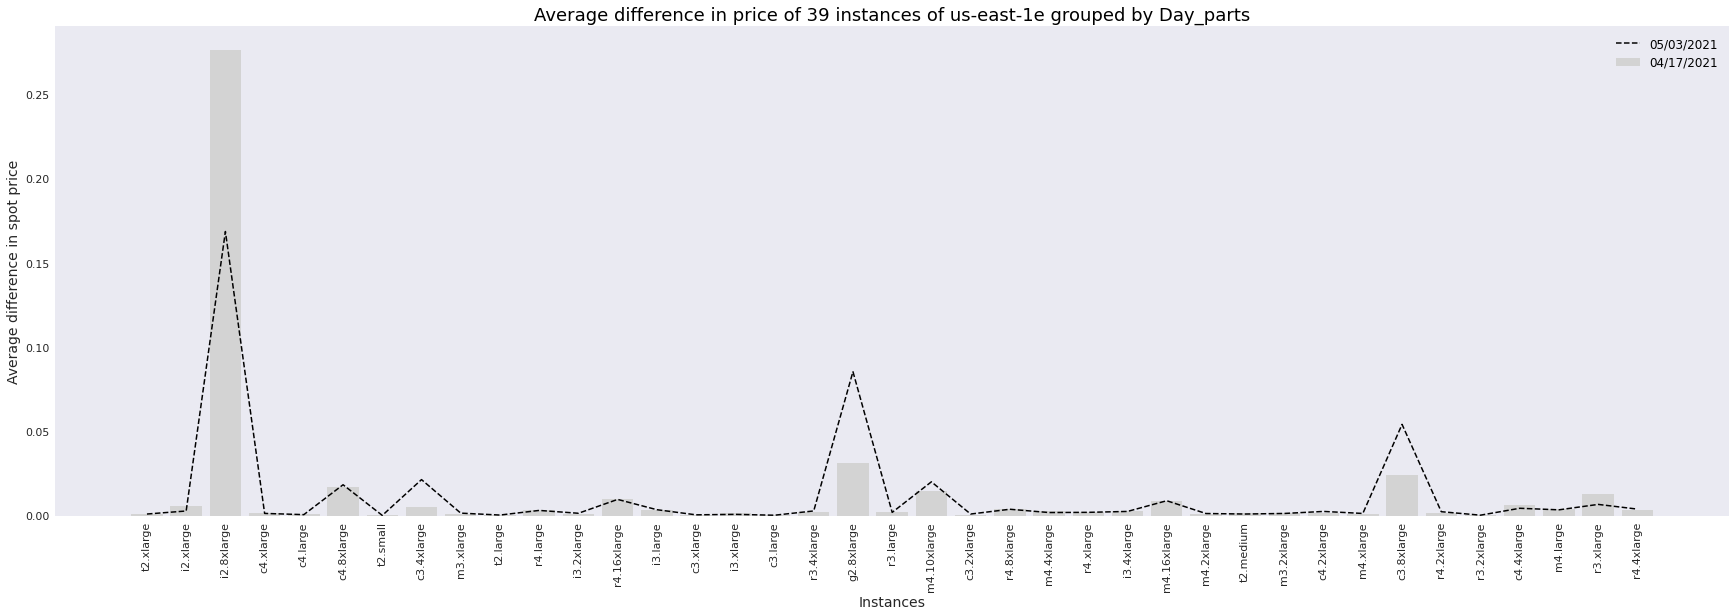

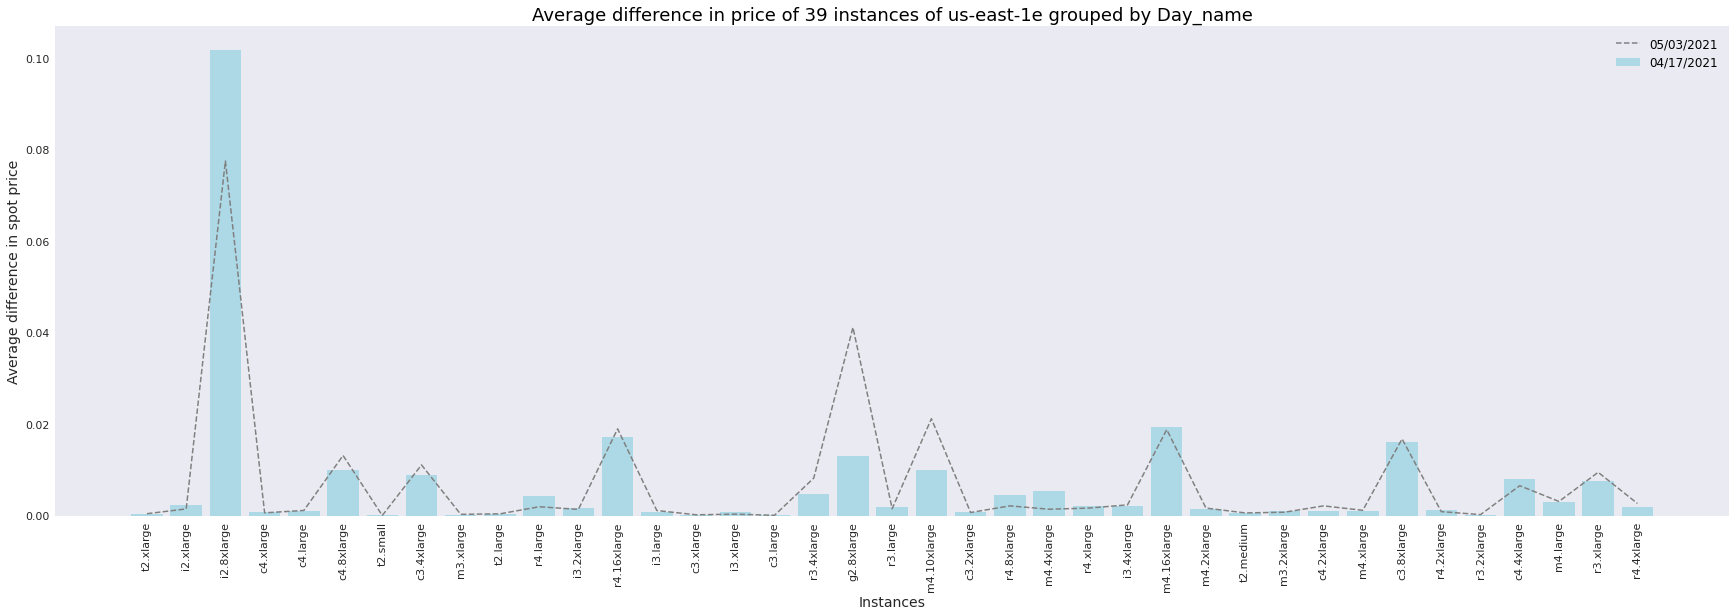

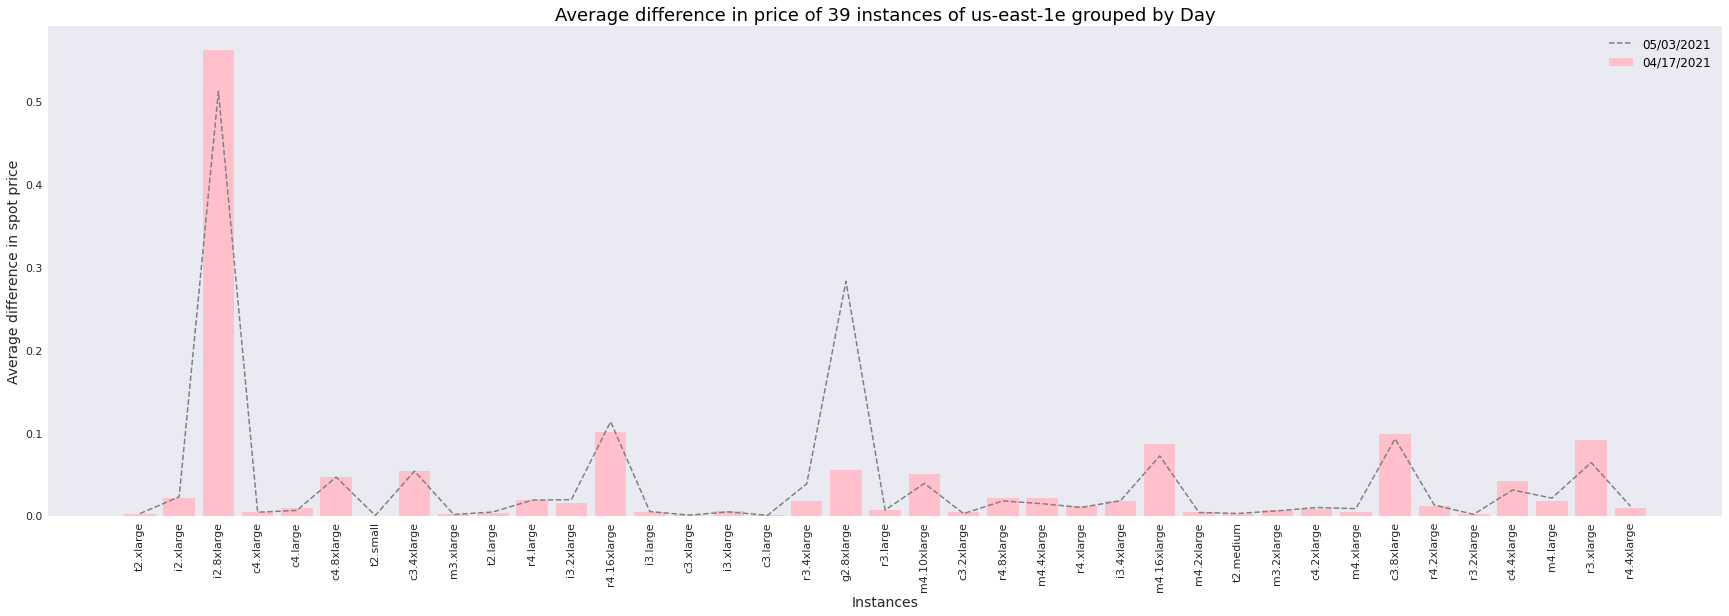

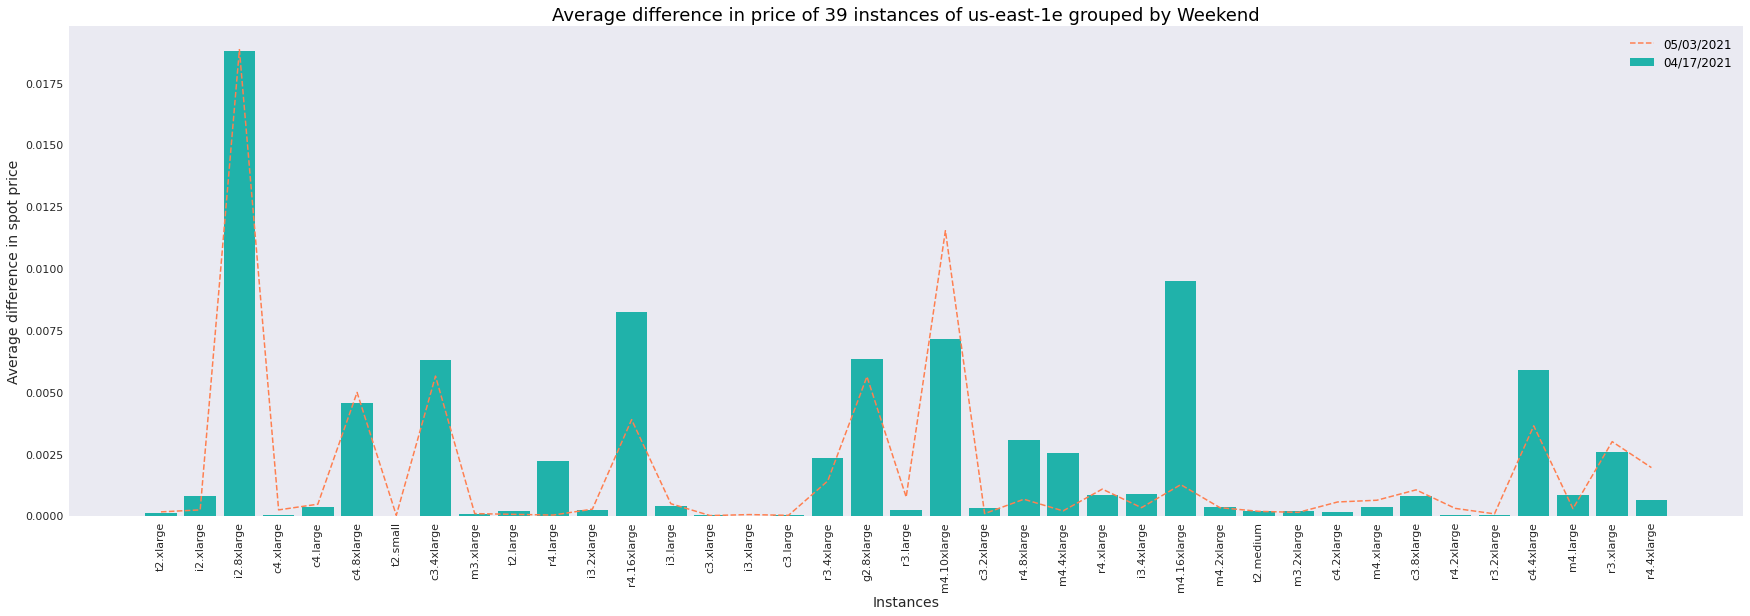

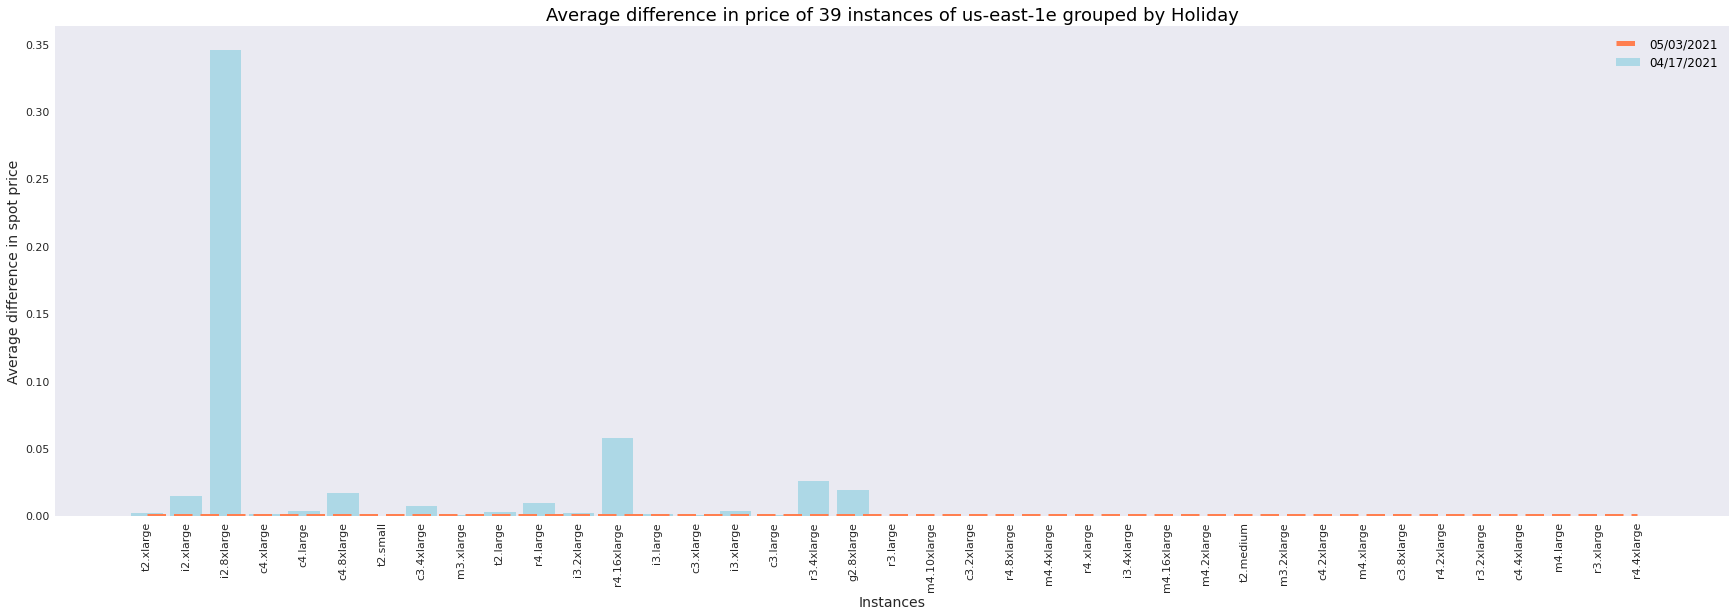

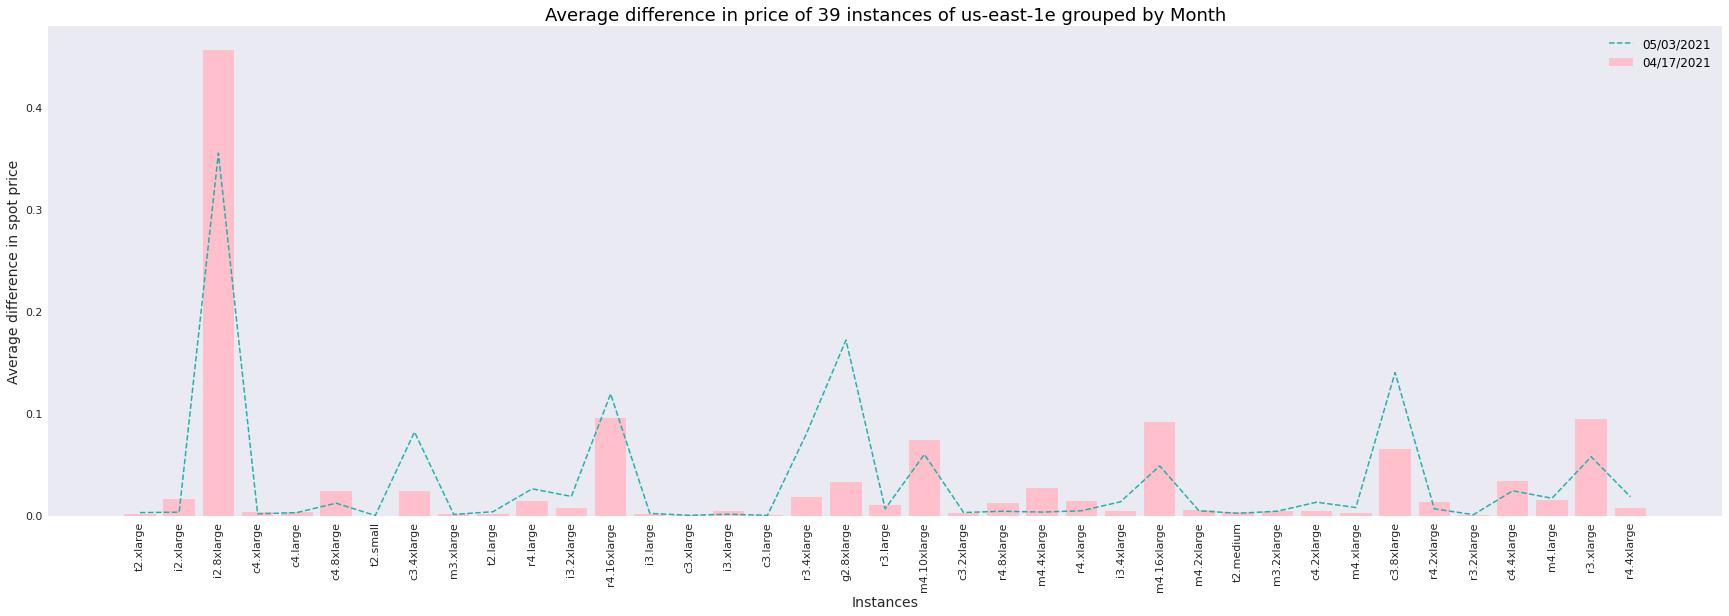

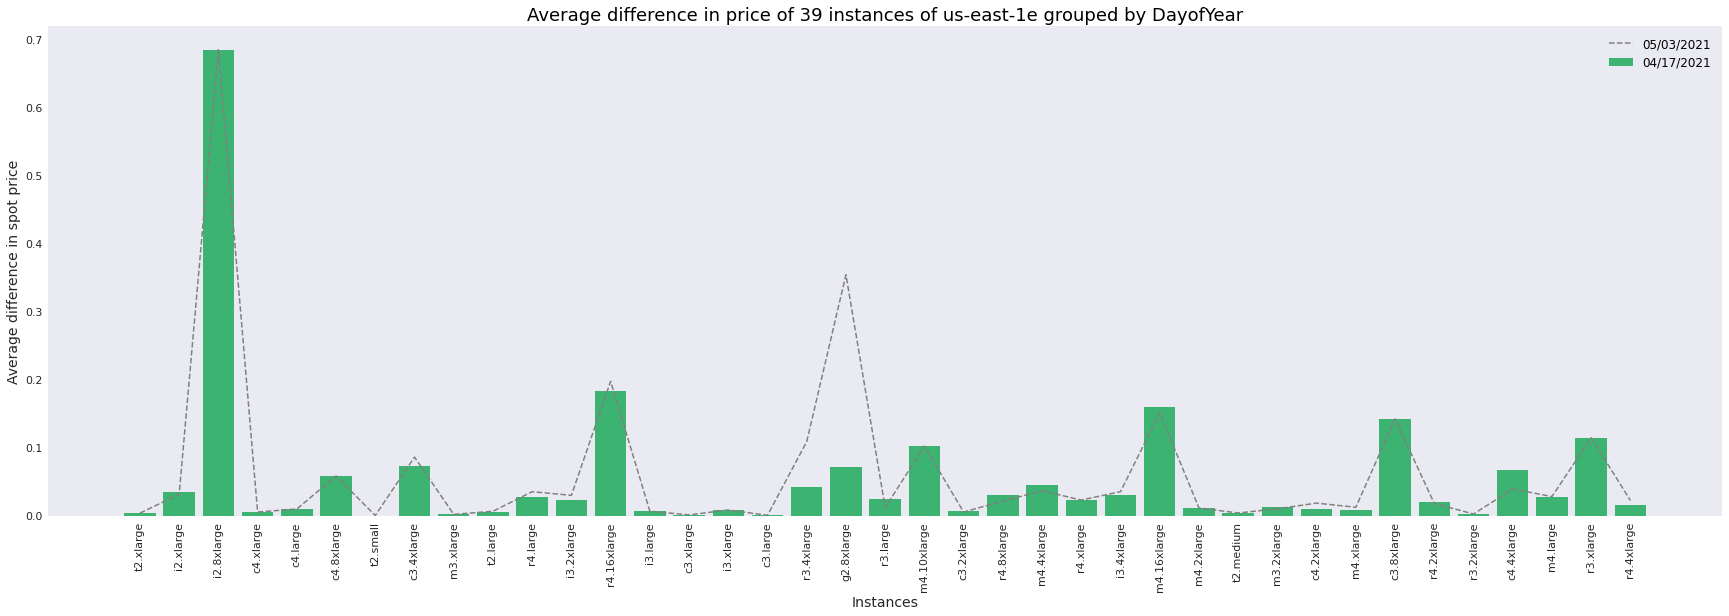

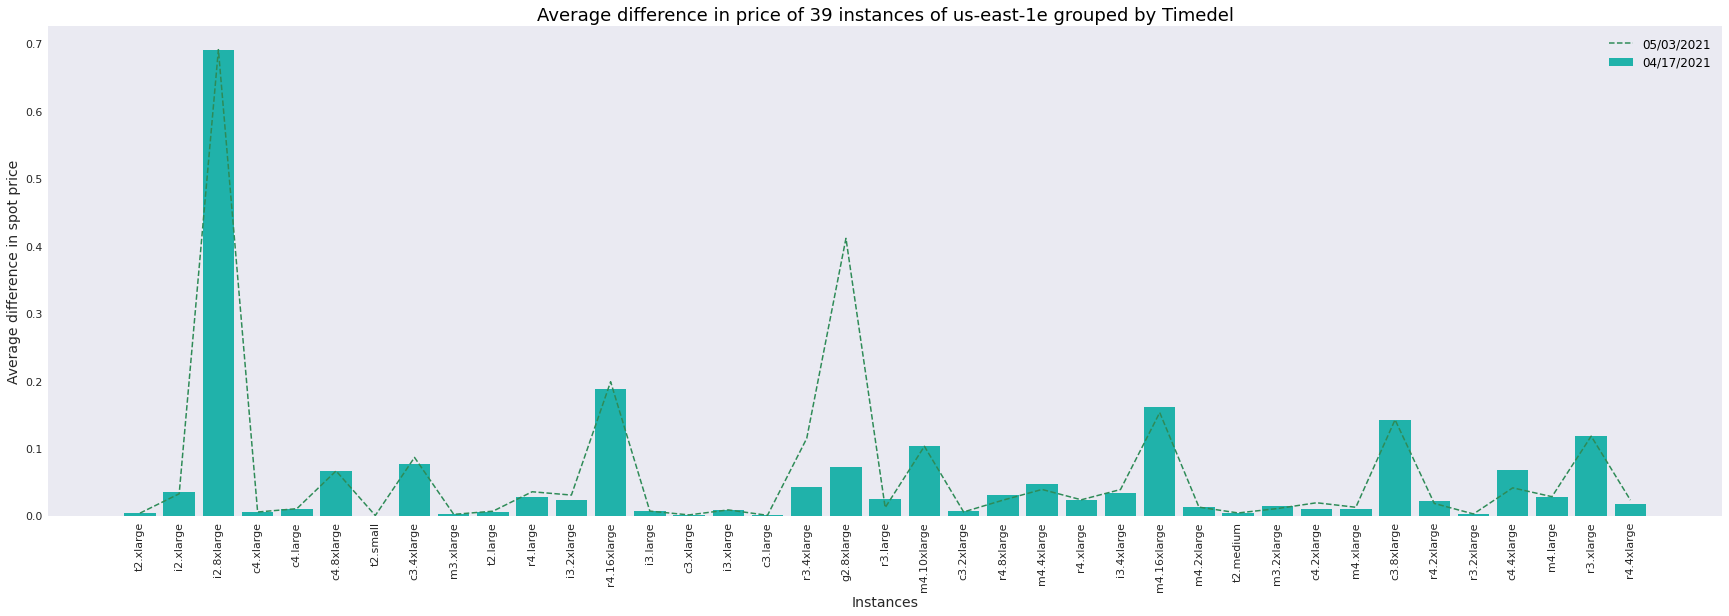

In [27]:
plot_mean_difference(us_east_1e1, us_east_1e2, u_east_1e_var)

### us-east-1f

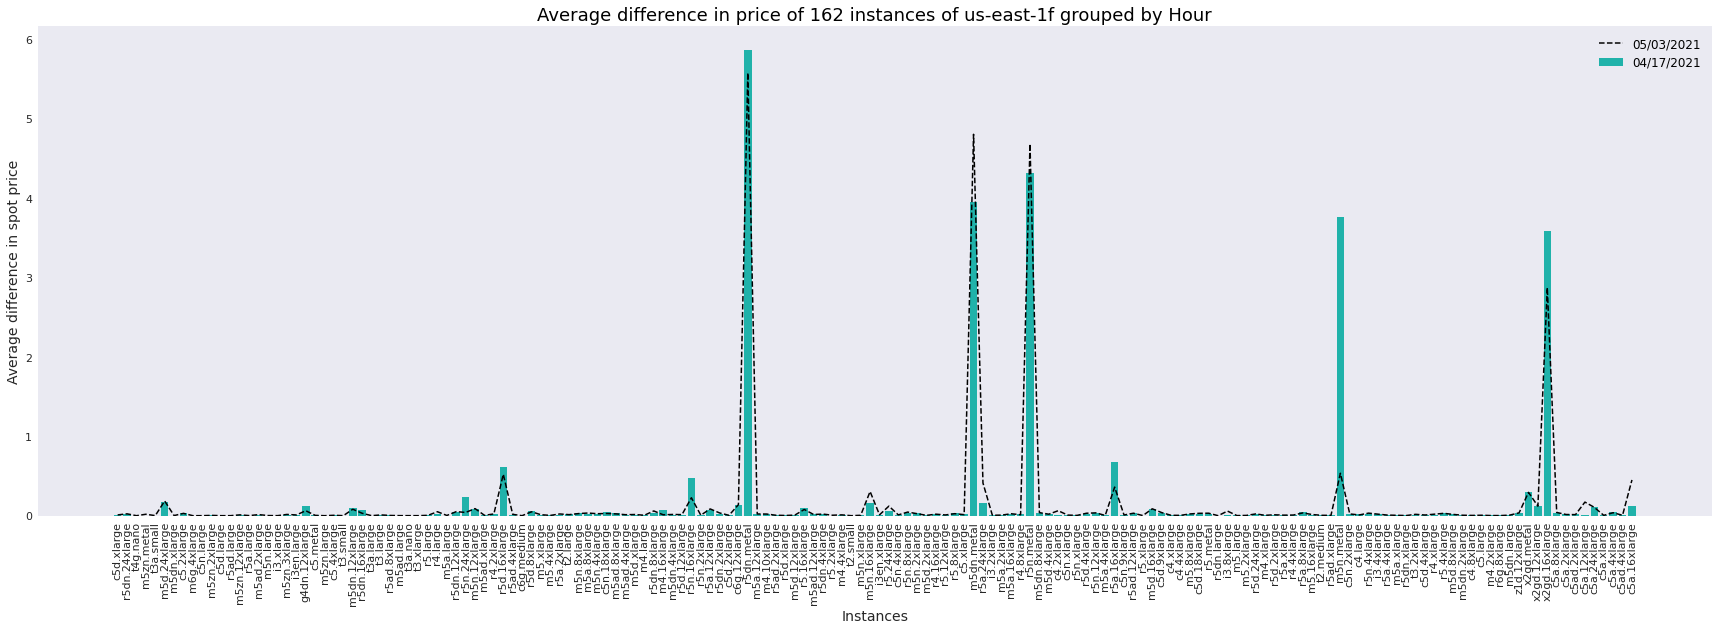

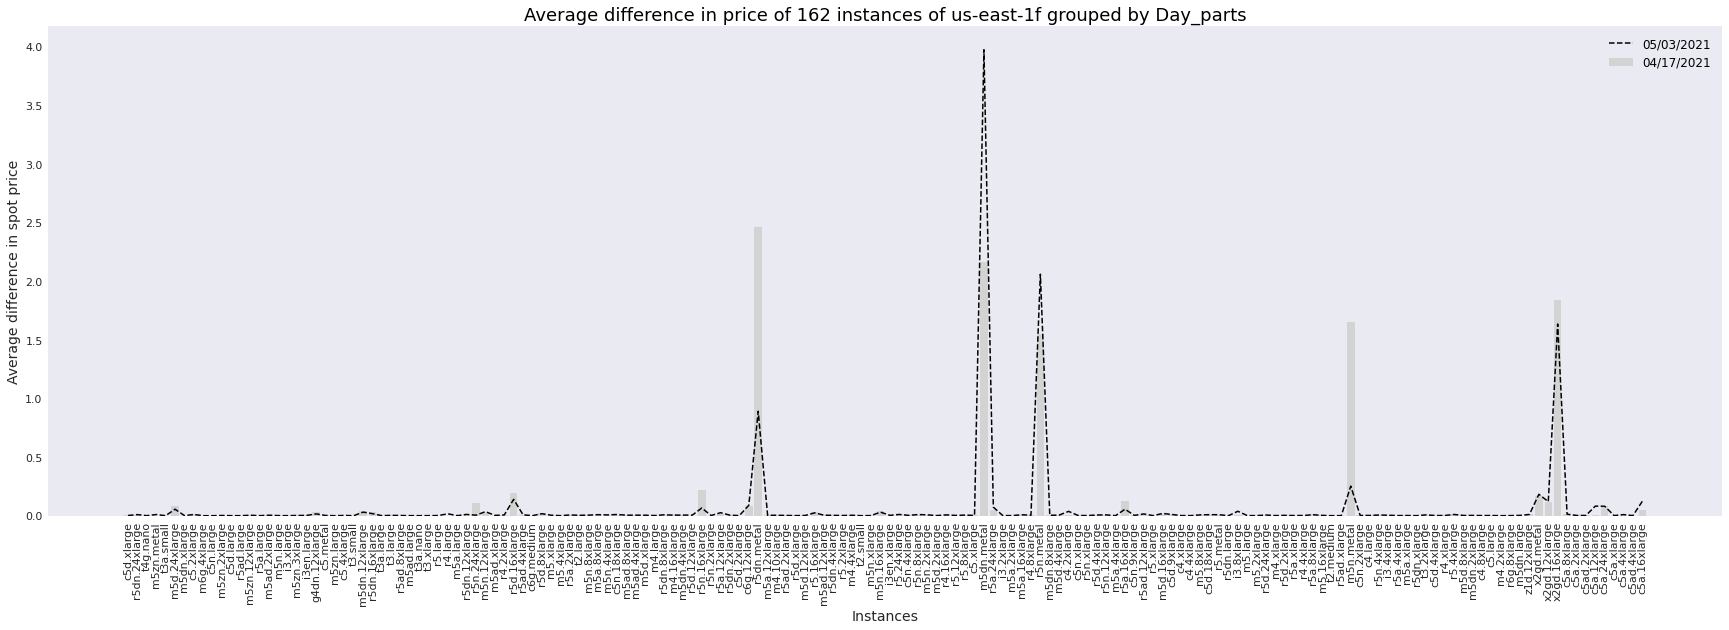

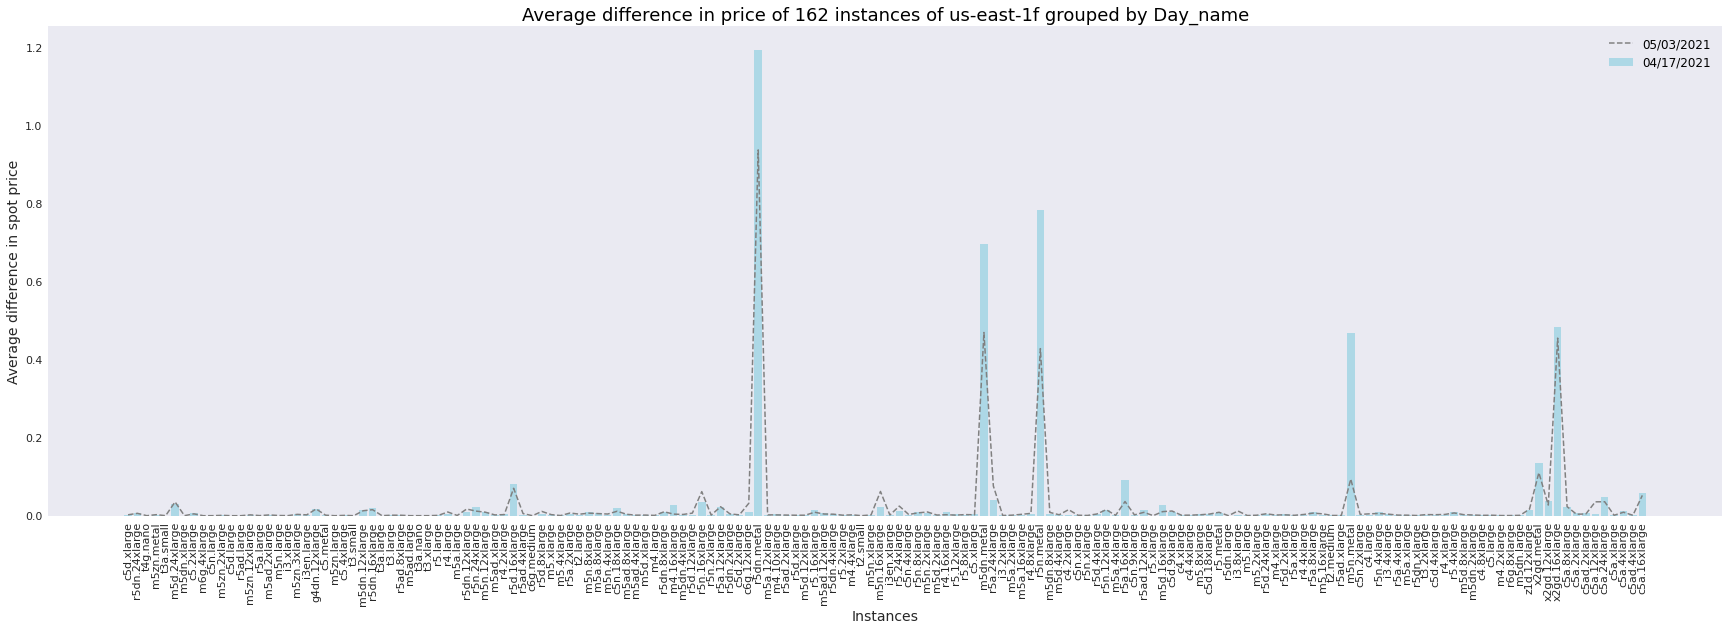

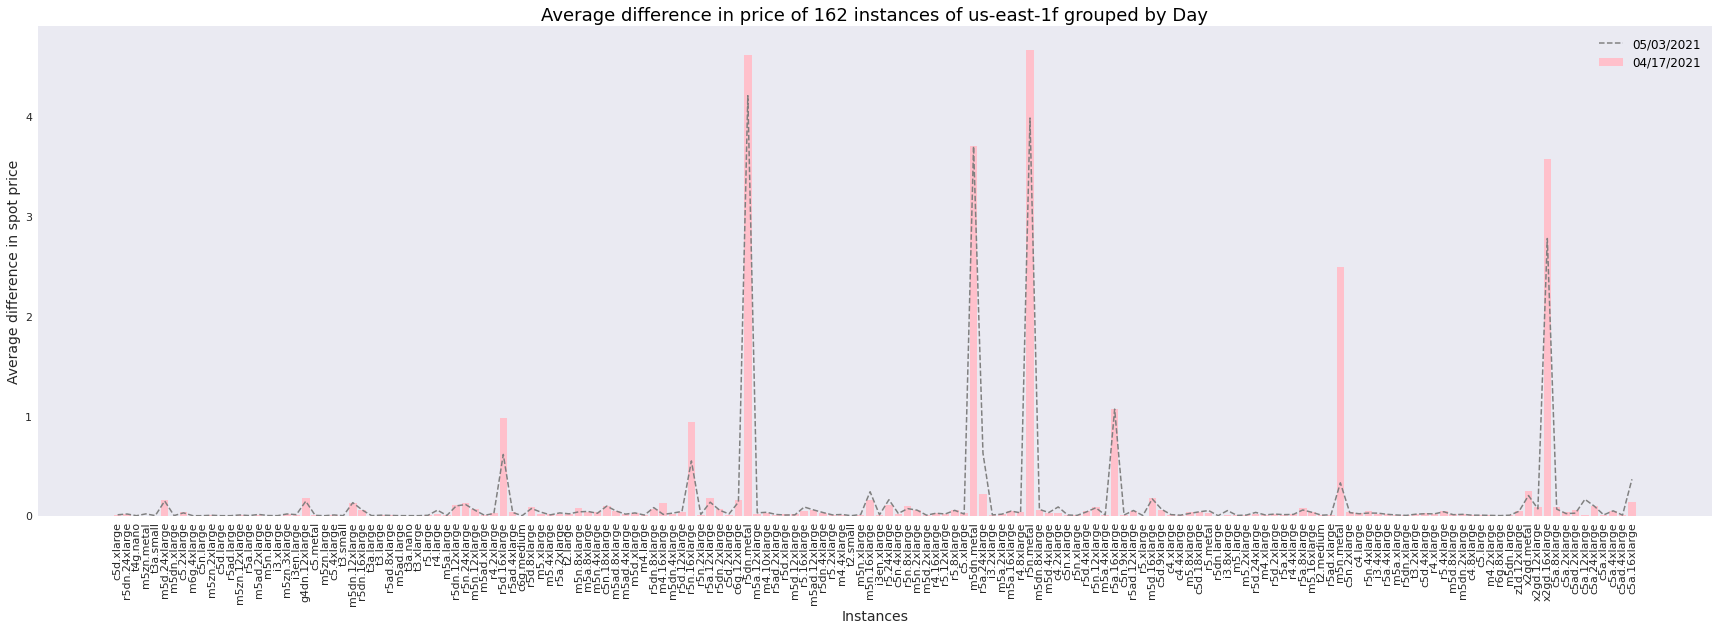

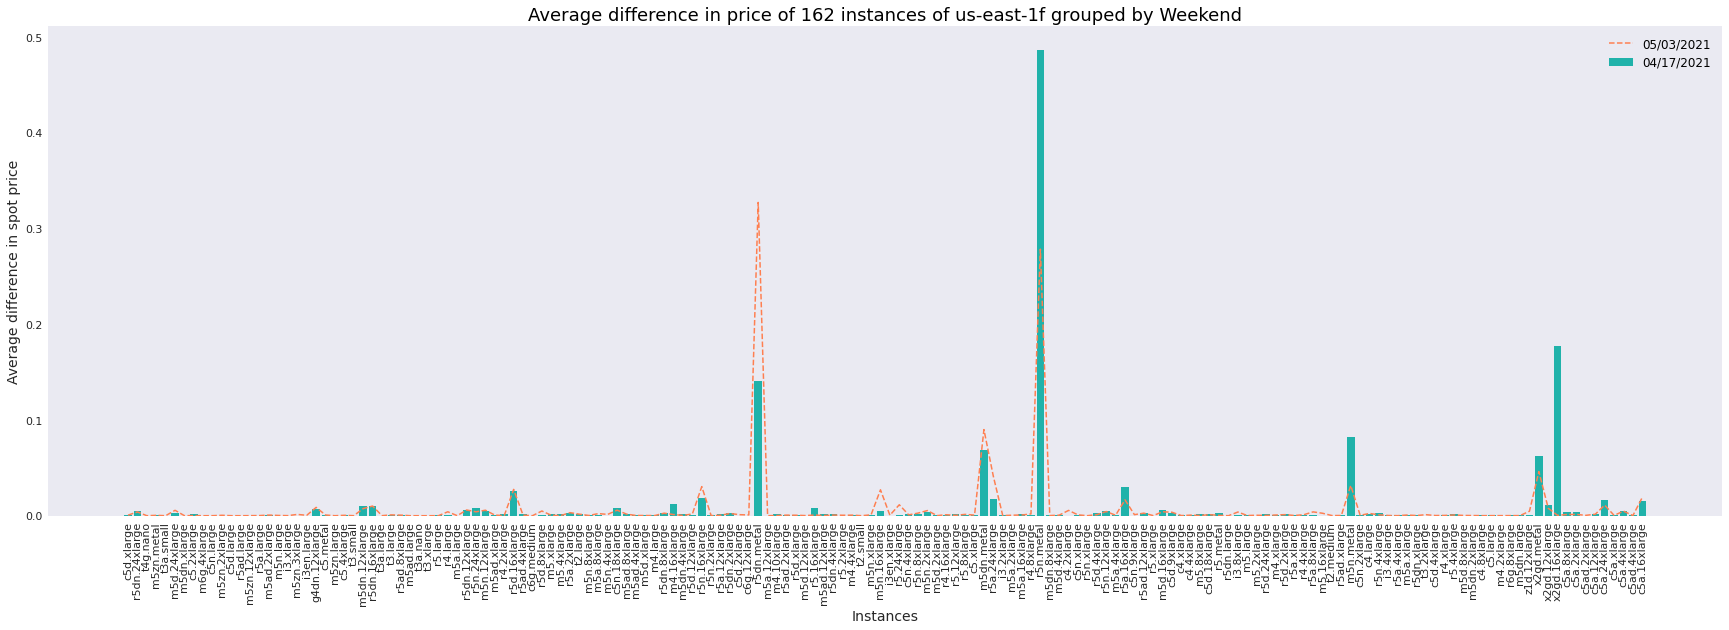

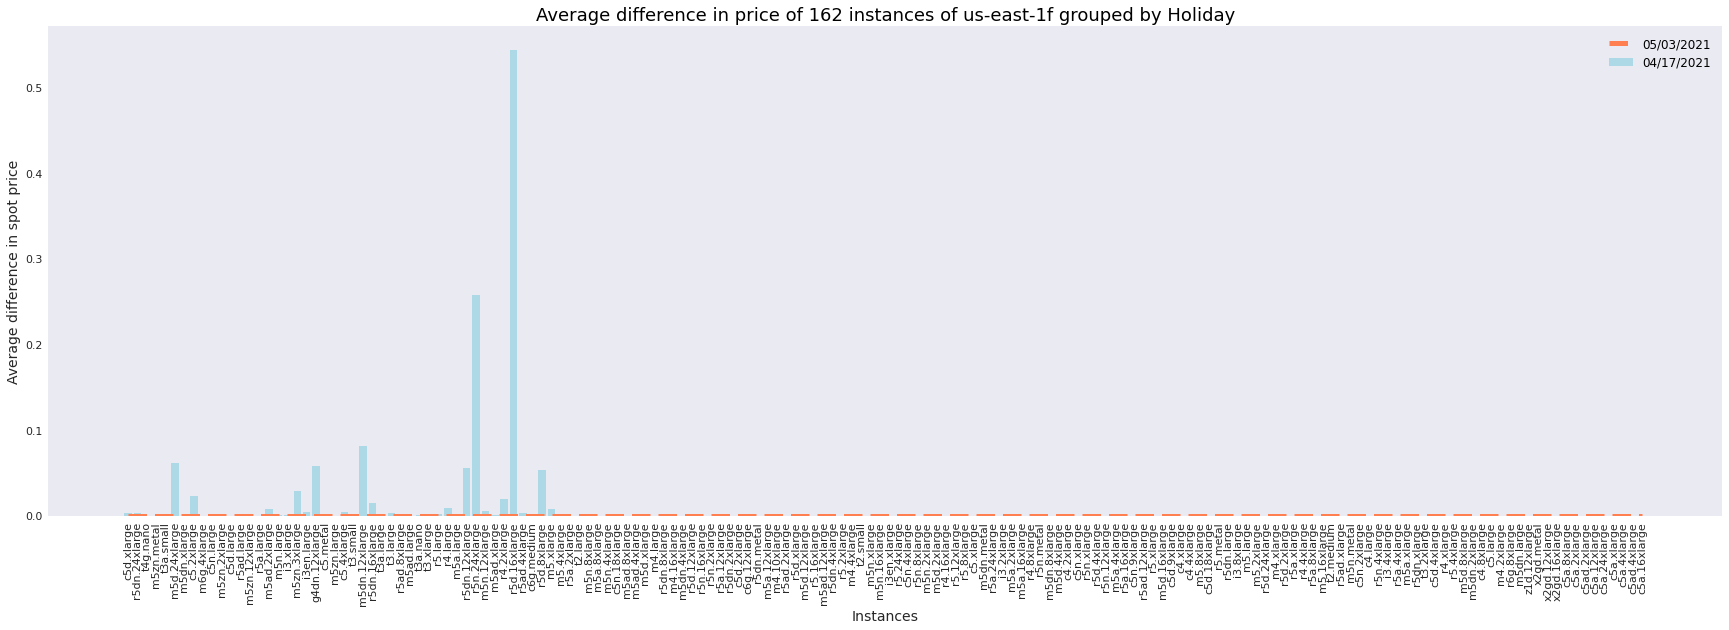

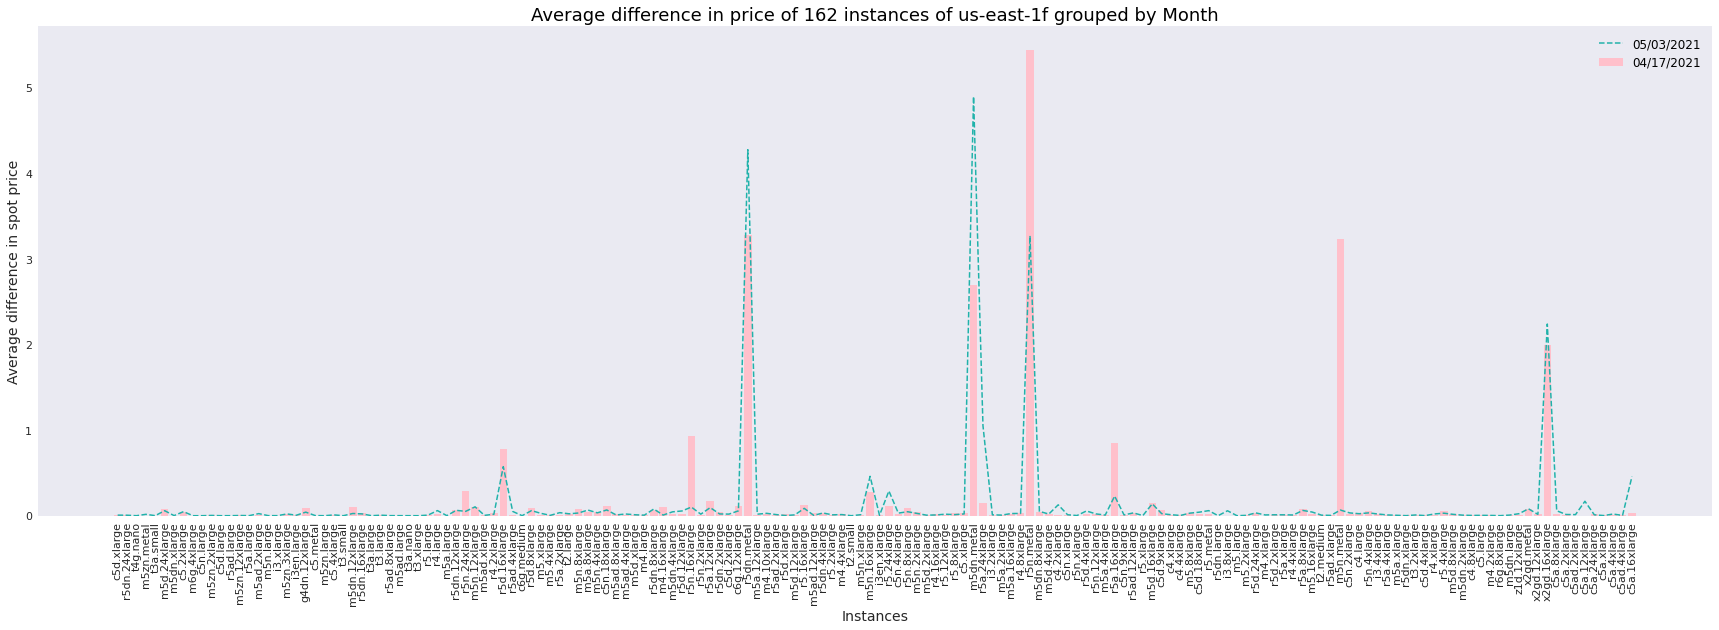

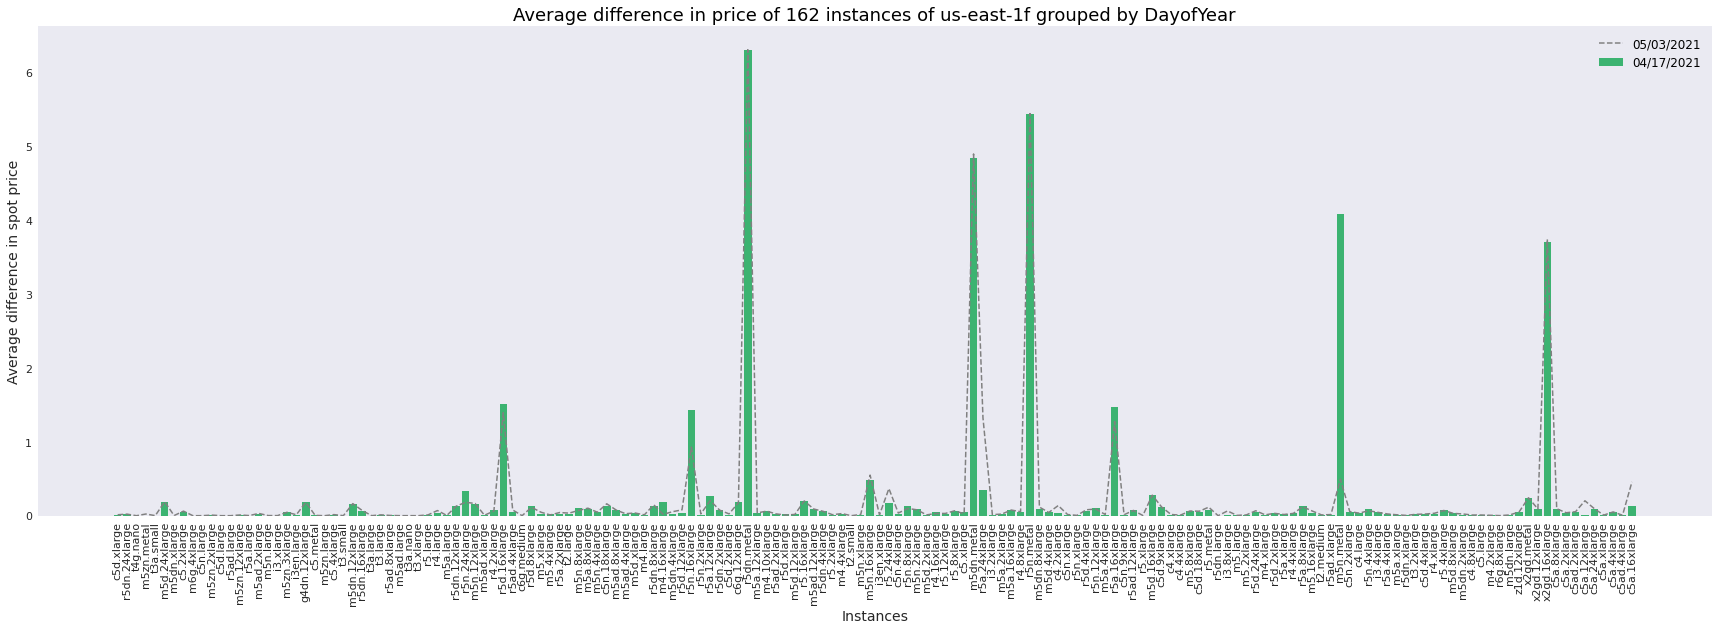

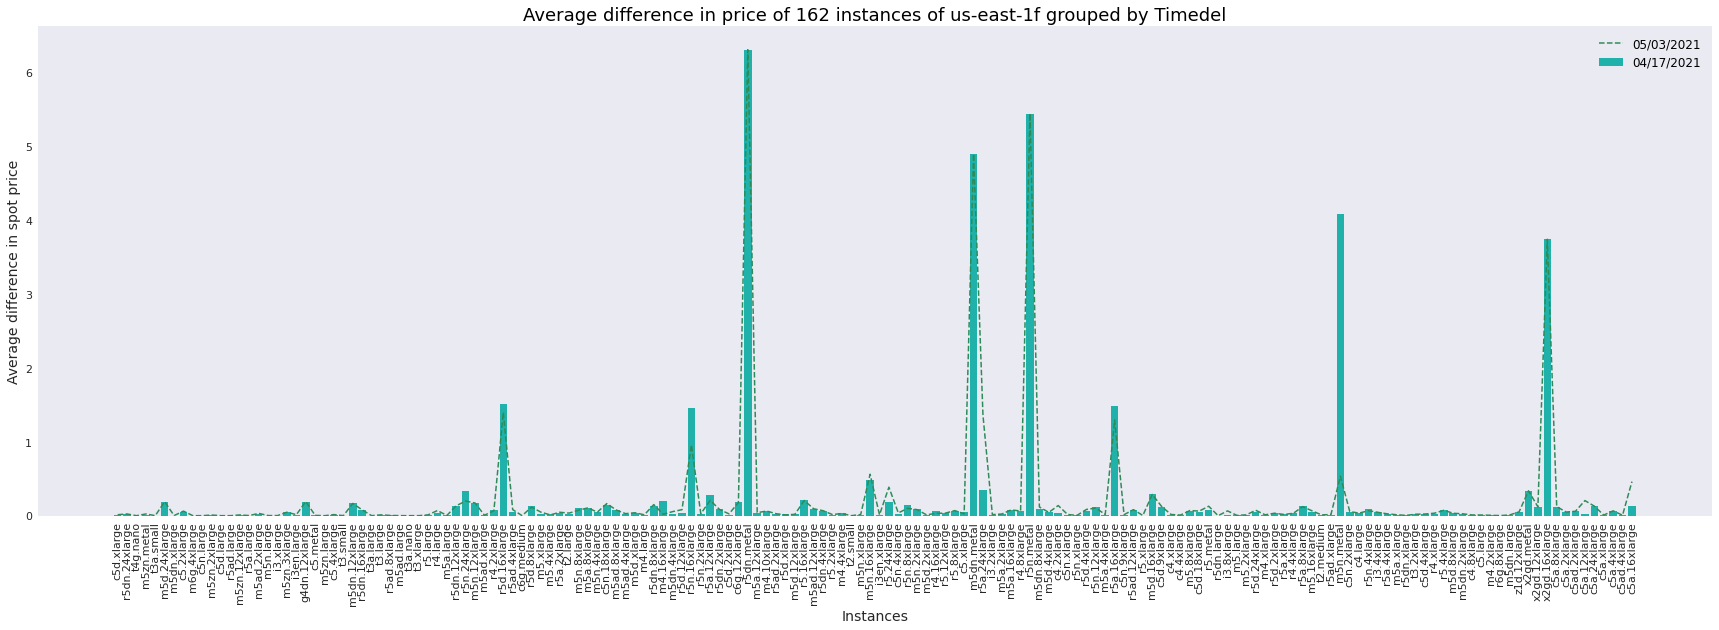

In [28]:
plot_mean_difference(us_east_1f1, us_east_1f2, u_east_1f_var)

## References

* https://towardsdatascience.com/feature-engineering-on-date-time-data-90f6e954e6b8
* https://pypi.org/project/holidays/